## Figures for Precambrian Research Submission - OFP
## **Trace & Major Elements**
  
Connor S. van Wieren, 2023

## Notes
- 

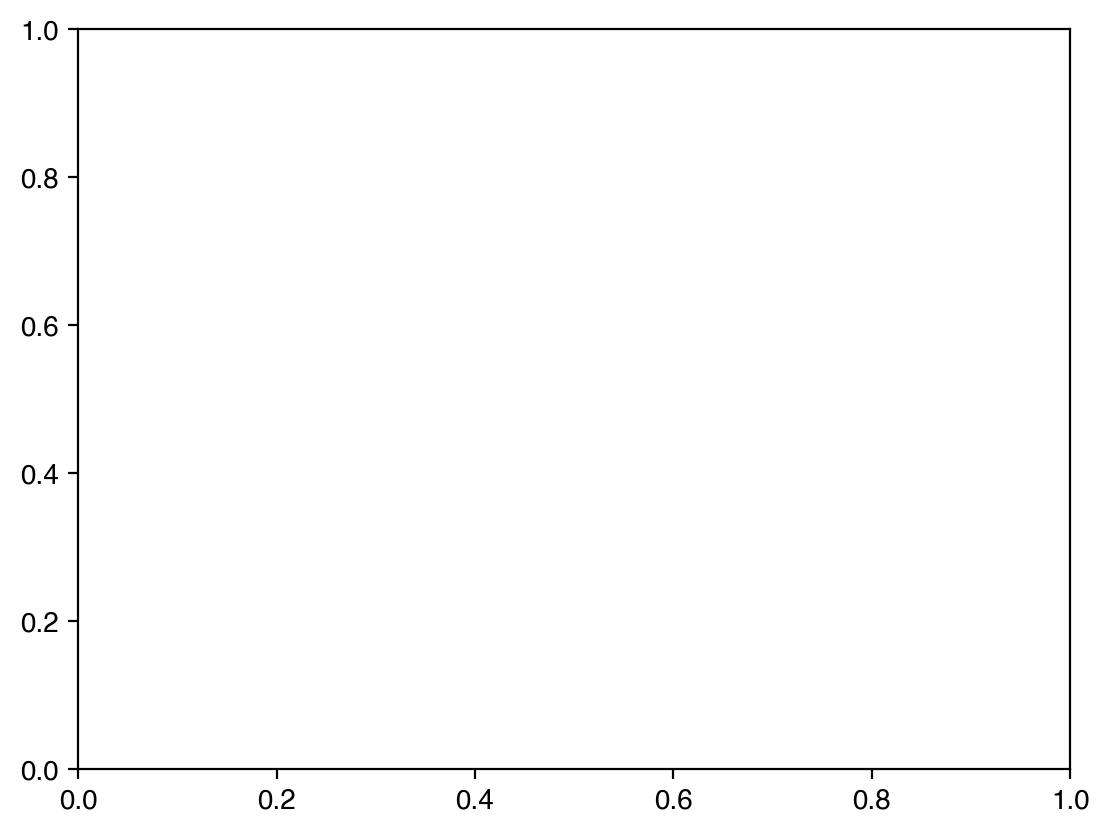

In [1]:
import numpy as np
import random
random.seed(10)
import numpy.polynomial.polynomial as pl
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap as lm
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle
import matplotlib.transforms as transforms
from matplotlib import colors
import matplotlib.cm as cm
import matplotlib
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy
from VanStrat.VanStrat_simple import *
import string
from scipy.ndimage import rotate
from matplotlib.ticker import FuncFormatter
import matplotlib.gridspec as gridspec
import pickle
import dill

## for reloading updated .py files without restarting kernel; 2 means to reload all imports, don't need to run this every time. when i save a .py file its auto reloaded
%load_ext autoreload
%autoreload 2 

import sys
sys.path.insert(0, '/Users/cvanwieren/Library/CloudStorage/Dropbox/GitHub/Useful_Code')
from funcs import *
%matplotlib inline

plt.rcParams['figure.figsize'] = (5.5, 3.5)
%config InlineBackend.figure_format='retina'

sns.set_style('ticks',{'axes.edgecolor':'.3',
                       'xtick.color':'.3',
                       'ytick.color':'.3',
                       'text.color': '.3',
                       'axes.labelcolor':'.3',
                       'axes.grid': False,
                       'grid.linestyle': u'-.'})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

# matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['ps.fonttype'] = 42

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_colwidth', None)

fig_dir = '/Users/cvanwieren/Library/CloudStorage/Dropbox/GitHub/Publications/OFP_PC/img/'

# load pickle
filename = './pickles/ofp_data.pkl'
dill.load_session(filename)

# read excels
secs = pd.read_excel(home+'./sections/sections_com.xlsx') # sections 
# get rid of secs duplicates
secs = secs.dropna(subset=['d13c_carb']).reset_index(drop=True)

# Lump all Fold limbs for GSM Type into one section
secs.loc[secs['index'].str.contains('GSM Type'),'index'] = 'GSM Type'

clasts = pd.read_excel(home+'./ICTs/icts_com.xlsx') # ICT clasts
nods = pd.read_excel(home+'./hand_samples/nodules.xlsx') # GSM Authigenic Nodules
fans = pd.read_excel(home+'./hand_samples/fans.xlsx') # WMM aragonite fan clasts

# combine clasts and fans
clasts = pd.concat([clasts,fans]).reset_index(drop=True)

## Function to convert X/Ca to X/Ca+Mg

In [2]:
sys.path.insert(0, '/Users/cvanwieren/Library/CloudStorage/Dropbox/GitHub/vanWieren_OFP_PrecRes')
from ofp_funcs import *

In [3]:
# # testing on first row of data in the round 2 reprocessing
# x_ca, x_mgca = mgca(df_x=1.64203e-05,df_mg=0.000141733,df_ca=2.03443E-07,out_ca=True) # Fe 
# # manually: 
# x_mgca_manual = 1.64203e-05/(2.03443E-07+0.000141733/1000) # Fe/Ca+Mg
# print(f'Fe/Ca = {x_ca:.6f}; Fe/(Ca+Mg) = {x_mgca:.6f}; manually Fe/(Ca+Mg) = {x_mgca_manual:.6f}')

In [4]:
# # testing again - seems to work
# x_ca, x_mgca = mgca(df_x=1.78772E-07,df_mg=0.000141733,df_ca=2.03443E-07,out_ca=True) # Sr 
# # manually: 
# x_mgca_manual = 1.78772E-07/(2.03443E-07+0.000141733/1000) # Sr/Ca+Mg
# print(f'Sr/Ca = {x_ca:.6f}; Sr/(Ca+Mg) = {x_mgca:.6f}; manually Sr/(Ca+Mg) = {x_mgca_manual:.6f}')

## add column for converted X/(Ca+Mg) trace data for clasts and secs 

### sections

In [5]:
# secs
targs_secs = secs.columns[secs.columns.str.contains('mol')]

for i in targs_secs:
    new_col_s = i+'_Mg'
    secs[new_col_s] = mgca(secs[i],secs['Mg_mmol_molCa'],df_ca=None,out_ca=False)

In [6]:
# check that it worked
# secs.head() # looks like it did

### clasts

In [7]:
# secs
targs_clasts = clasts.columns[clasts.columns.str.contains('mol')]

for i in targs_clasts:
    new_col_c = i+'_Mg'
    clasts[new_col_c] = mgca(clasts[i],clasts['Mg_mmol_molCa'],df_ca=None,out_ca=False)

In [8]:
# # check that it worked
# clasts.head() 

## Combine and Flag Data

In [9]:
nods['label']='Authigenic Nodules'
clasts['label'] = 'Clasts'
secs['label'] = 'Sections'

ofp = pd.concat([nods,clasts,secs])

## Comparing to James Busch Shuram Data

In [10]:
busch = pd.read_excel('/Users/cvanwieren/Library/CloudStorage/Dropbox/Documents/University/PhD/Lit Data/Busch Shuram Data (2022)/busch_2022_supps.xlsx')
busch = busch.rename(columns={'δ13C':'d13c_carb','δ18O':'d18o_carb','Sr/Ca (mmol/mol)':'Sr_mmol_molCa','Mn/Ca (μmol/mol)':'Mn_umol_molCa',
                             'Mg/Ca (mmol/mol)':'Mg_mmol_molCa','δ26Mg':'d26Mg_carb','δ25Mg':'d25Mg_carb',
                             'U/Ca (μmol/mol)':'U_umol_molCa'})
busch['Mn_mmol_molCa'] = busch['Mn_umol_molCa']/1000
secs['Mn/Sr (mmol/mmol)'] = secs['Mn_mmol_molCa_Mg']/secs['Sr_mmol_molCa_Mg']
clasts['Mn/Sr (mmol/mmol)'] = clasts['Mn_mmol_molCa']/clasts['Sr_mmol_molCa']

# weird zero value so make nan
busch.loc[busch['U_umol_molCa']==0,'U_umol_molCa'] = np.nan
aus = busch[busch['location']=='Australia']
om = busch[busch['location']=='Oman']

In [11]:
set(busch['location'])

{'Australia', 'Death Valley', 'NW Canada', 'Oman', 'Peru'}

## Compare with Jon Data

In [12]:
# sections
hms4 = pd.read_excel('/Users/cvanwieren/Library/CloudStorage/Dropbox/GitHub/OFP/OFP/data/Trace/examples/Husson_data_comparison/hussonetal_2014_AJS.xlsx',
                     'TE - m.s. 4',header=[1])
hms6 = pd.read_excel('/Users/cvanwieren/Library/CloudStorage/Dropbox/GitHub/OFP/OFP/data/Trace/examples/Husson_data_comparison/hussonetal_2014_AJS.xlsx',
                     'TE - m.s. 6',header=[1])
hms13 = pd.read_excel('/Users/cvanwieren/Library/CloudStorage/Dropbox/GitHub/OFP/OFP/data/Trace/examples/Husson_data_comparison/hussonetal_2014_AJS.xlsx',
                     'TE - m.s. 13',header=[1])
hus_secs = pd.concat([hms4,hms6,hms13]).reset_index(drop=True)

/Users/cvanwieren/anaconda3/envs/connor/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/Users/cvanwieren/anaconda3/envs/connor/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/Users/cvanwieren/anaconda3/envs/connor/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [13]:
hus_secs = hus_secs.rename(columns={'HEIGHT (in meters)':'sample_height',
                         'd13Ccarb':'d13c_carb',
                         'd18Ocarb':'d18o_carb',
                         'Mg/Ca':'Mg_mmol_molCa',
                         'Sr/Ca':'Sr_mmol_molCa',
                         'U/Ca':'U_umol_molCa',
                         'Mn/Ca':'Mn_mmol_molCa'})
hus_secs['Mn/Sr (mmol/mmol)'] = hus_secs['Mn_mmol_molCa']/hus_secs['Sr_mmol_molCa']

In [14]:
# clasts
hmtc = pd.read_excel('/Users/cvanwieren/Library/CloudStorage/Dropbox/GitHub/OFP/OFP/data/Trace/examples/Husson_data_comparison/hussonetal_2014_AJS.xlsx',
                     'TE - Mt Thomas clasts',header=[1])
hstrc = pd.read_excel('/Users/cvanwieren/Library/CloudStorage/Dropbox/GitHub/OFP/OFP/data/Trace/examples/Husson_data_comparison/hussonetal_2014_AJS.xlsx',
                     'TE - St Ronan clasts',header=[1])
hus_clasts = pd.concat([hmtc,hstrc]).reset_index(drop=True)

# clasts no trace elements
hmtc1 = pd.read_excel('/Users/cvanwieren/Library/CloudStorage/Dropbox/GitHub/OFP/OFP/data/Trace/examples/Husson_data_comparison/hussonetal_2014_AJS.xlsx',
                     'clasts - Mt Thomas',header=[0])

hooc1 = pd.read_excel('/Users/cvanwieren/Library/CloudStorage/Dropbox/GitHub/OFP/OFP/data/Trace/examples/Husson_data_comparison/hussonetal_2014_AJS.xlsx',
                     'clasts - Oodnapanicken',header=[0])

hstr1 = pd.read_excel('/Users/cvanwieren/Library/CloudStorage/Dropbox/GitHub/OFP/OFP/data/Trace/examples/Husson_data_comparison/hussonetal_2014_AJS.xlsx',
                     'clasts - St Ronan',header=[0])

hus_clasts1 = pd.concat([hmtc1,hooc1,hstr1]).reset_index(drop=True)


/Users/cvanwieren/anaconda3/envs/connor/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/Users/cvanwieren/anaconda3/envs/connor/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/Users/cvanwieren/anaconda3/envs/connor/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/Users/cvanwieren/anaconda3/envs/connor/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/Users/cvanwieren/anaconda3/envs/connor/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be re

In [15]:
# hmtc.columns

In [16]:
hus_clasts = hus_clasts.rename(columns={'HEIGHT (in meters)':'sample_height',
                         'd13Ccarb':'d13c_carb',
                         'd18Ocarb':'d18o_carb',
                         'Mg/Ca':'Mg_mmol_molCa',
                         'Sr/Ca':'Sr_mmol_molCa',
                         'U/Ca':'U_umol_molCa',
                         'Mn/Ca':'Mn_mmol_molCa'})
hus_clasts['Mn/Sr (mmol/mmol)'] = hus_clasts['Mn_mmol_molCa']/hus_clasts['Sr_mmol_molCa']

In [17]:
hus_clasts1 = hus_clasts1.rename(columns={'HEIGHT (in meters)':'sample_height',
                         'd13Ccarb':'d13c_carb',
                         'd18Ocarb':'d18o_carb'})

In [18]:
# # crusts
# hus_crust = pd.read_excel('/Users/cvanwieren/Library/CloudStorage/Dropbox/GitHub/OFP/OFP/data/Trace/examples/Husson_data_comparison/hussonetal_2014_AJS.xlsx',
#                      'TE - canyon-wall crusts',header=[1])

In [19]:
# hus_crust = hus_crust.rename(columns={'HEIGHT (in meters)':'sample_height',
#                          'd13Ccarb':'d13c_carb',
#                          'd18Ocarb':'d18o_carb',
#                          'Mg/Ca':'Mg_mmol_molCa',
#                          'Sr/Ca':'Sr_mmol_molCa',
#                          'U/Ca':'U_umol_molCa',
#                          'Mn/Ca':'Mn_mmol_molCa'})
# hus_crust['Mn/Sr (mmol/mmol)'] = hus_crust['Mn_mmol_molCa']/hus_crust['Sr_mmol_molCa']

## NOTES:
- Jon and James data not perfect match - **MATCHES WITH NEW JON DF**
- could be because Jon was all X/Ca+Mg except Mg, and James had to convert?
- why is sample size different

In [20]:
jon2 =  pd.read_excel('/Users/cvanwieren/Library/CloudStorage/Dropbox/GitHub/OFP/OFP/data/Trace/examples/Husson_data_comparison/cvw_SOM-datatableV3_TOSHARE.xlsx',
                    header=[0])

/Users/cvanwieren/anaconda3/envs/connor/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [21]:
jon2 = jon2.rename(columns={'sample height/name':'sample_height',
                         'Mg/Ca (mmol/mol)':'Mg_mmol_molCa',
                         'Sr/Ca (mmol/mol)':'Sr_mmol_molCa',
                         'U/Ca (umol/mol)':'U_umol_molCa',
                         'Mn/Ca (mmol/mol)':'Mn_mmol_molCa'})
jon2['Mn/Sr (mmol/mmol)'] = jon2['Mn_mmol_molCa']/jon2['Sr_mmol_molCa']
jon2['Mn/Sr Clast'] = jon2['Mn (ppm)']/jon2['Sr (ppm)']

- Targets: Sr/Ca, Mn/Ca, U/Ca, Mn/Sr, Mg/Ca
- Jon's new datasheet matches James Busch's data
- will use Jon data for Aus so I can split clasts and sections, and will use Busch for Oman, NW Canada
- Jon new dataframe clast data Sr and Mn is in ppm, no Ca data so can only do Mn/Sr ratio

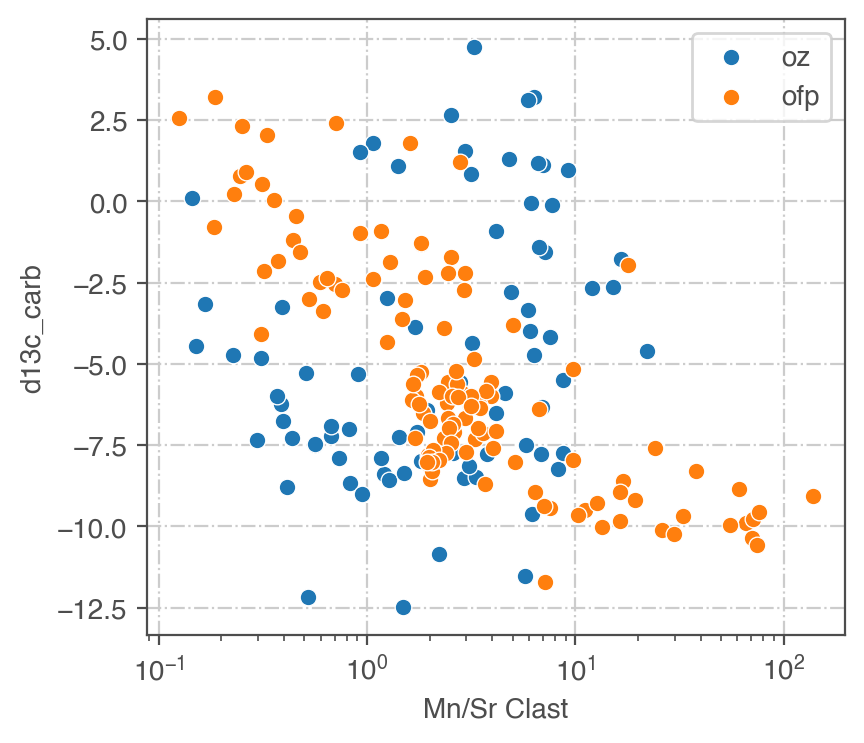

In [22]:
cl = jon2[~jon2['index'].str.contains('SECTION')]
fig,ax = plt.subplots(figsize=(4.5,4))
sns.scatterplot(data=cl,x='Mn/Sr Clast',y='d13c_carb',label='oz')
sns.scatterplot(data=clasts,x='Mn/Sr (mmol/mmol)',y='d13c_carb',label='ofp')
ax.set_xscale('log')
ax.grid()

In [23]:
# datasets
busch_aus = busch[busch['location']=='Australia']
busch_oman = busch[busch['location']=='Oman']
busch_nwc = busch[busch['location']=='NW Canada']
jon2_sec = jon2[jon2['index'].str.contains('SECTION')]
jon2_clast = jon2[jon2['index'].str.contains('BRECCIAS')]

dat = {'Oman':busch_oman,
       'Australia':jon2_sec,
       'NW Canada':busch_nwc,
       'OFP Sections':secs,
       'OFP Clasts':clasts}

wmm_secs = secs[secs['member']=='WMM'].copy()
wmm_secs['type'] = 'WMM sections'
tlm_secs = secs[secs['member']=='TLM'].copy()
tlm_secs['type'] = 'TLM sections'
clasts['type'] = 'OFP clasts'
comb = pd.concat([clasts,wmm_secs,tlm_secs]).reset_index(drop=True)
comb = comb.sort_values('type',ascending=True)
comb = comb.dropna(subset=['Sr_mmol_molCa']).reset_index(drop=True)


## Oxygen means

In [24]:
oxm = []
l = []
for i in set(secs['index']):
    sub = secs[secs['index']==i]  
    m = np.mean(sub['d18o_carb'])
    oxm.append(m)
    l.append(i)
d = dict(zip(l,oxm))
np.mean(oxm)

-15.471608086370463

In [25]:
oxm = []
l = []
for i in set(secs['index']):
    sub = secs['d18o_carb'][secs['index']==i]  
    mx = max(sub)
    mnx = min(sub)
    print(f'{i}; max = {mx}; min = {mnx}')

Wolverine; max = -13.28641415; min = -16.38692474
Temple Lake; max = -13.57635498; min = -18.02100754
Pyrite Point; max = -14.17494297; min = -14.84707451
McKale Creek; max = -15.43745422; min = -19.59428406
Railway; max = -14.67934418; min = -16.24526978
Marmot Road; max = -14.67012501; min = -16.2354641
GSM Type; max = -14.45478535; min = -16.05678558


## Oxygen Burial Temperature

In [26]:
comb['d18o_smow'] = 1.03092*comb['d18o_carb']+30.92
secs['d18o_smow'] = 1.03092*secs['d18o_carb']+30.92

In [27]:
m = secs['d18o_smow'].mean()
mv = secs['d18o_carb'].mean()
mmck = min(comb['d18o_smow'][comb['index']=='McKale Creek'])

In [28]:
print(mmck)

4.797017948543601


In [29]:
tc_o(mmck)

211.3057945219672

In [30]:
max(comb['d18o_carb'][comb['index']=='McKale Creek'])

-15.43745422

<Axes: xlabel='d18o_smow', ylabel='Density'>

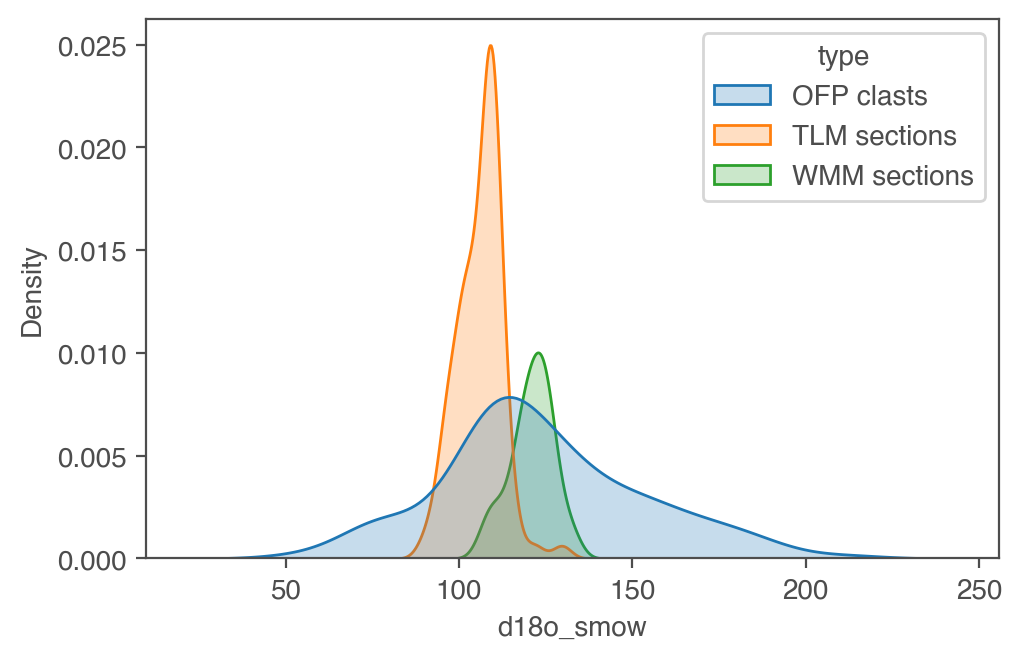

In [31]:
sns.kdeplot(x=tc_o(comb['d18o_smow'],dw=0),fill=True,hue=comb['type'])

# PCA using log10 transformed data (except $\delta^{13}$C, $\delta^{18}$O)
- Link to version in repository old commit [here](https://github.com/VanWieren/OFP/blob/7b81b2e00ba9a9302146995e4509348df1337385/OFP/Figures/PhD_Proposal/stratigraphy.ipynb)

### Clean dataframe and transform it with log10 (except for d13c and d18o)

In [32]:
trace_pca = pd.concat([secs,clasts]).dropna(subset=['Sr_mmol_molCa']).reset_index(drop=True)
trace_pca.columns

Index(['index', 'member', 'thickness', 'lithology', 'facies', 'grade',
       'features', 'sample_name', 'sample_height', 'sample_facies',
       'sample_features', 'facies_simplified', 'sample_facies_simplified',
       'trace_facies_simplified', 'sample_lith', 'trace_facies', 'd13c_carb',
       'd18o_carb', 'Li_umol_molCa', 'Na_mmol_molCa', 'Mg_mmol_molCa',
       'Al_mmol_molCa', 'K_mmol_molCa', 'V_umol_molCa', 'Mn_mmol_molCa',
       'Fe_mmol_molCa', 'Rb_umol_molCa', 'Sr_mmol_molCa', 'Th_umol_molCa',
       'U_umol_molCa', 'Li_umol_molCa_Mg', 'Na_mmol_molCa_Mg',
       'Mg_mmol_molCa_Mg', 'Al_mmol_molCa_Mg', 'K_mmol_molCa_Mg',
       'V_umol_molCa_Mg', 'Mn_mmol_molCa_Mg', 'Fe_mmol_molCa_Mg',
       'Rb_umol_molCa_Mg', 'Sr_mmol_molCa_Mg', 'Th_umol_molCa_Mg',
       'U_umol_molCa_Mg', 'label', 'Mn/Sr (mmol/mmol)', 'd18o_smow',
       'length_cm', 'width_cm', 'colour', 'id', 'clast_len_cm',
       'clast_width_cm', 'min_drildist_from_matrix_mm', 'Beam Area', 'type'],
      dtype='obj

## Data subsetting for playing with PCA

In [33]:
# remove McKale and Boomerang Clasts and see how the PCA looks
trace_pca_nomck = trace_pca[~(trace_pca['index'].str.contains('McKale Creek|Boomerang'))|(trace_pca['label']!='Clasts')]

### Prep data, normalize for pca

In [34]:
# want to avoid using certain things such as categorical data or data with sparse coverage
excl = ['index', 'member', 'thickness', 'lithology', 'facies', 'grade', 'features',
       'sample_name', 'sample_height', 'sample_facies', 'sample_features',
       'facies_simplified', 'sample_facies_simplified',
       'trace_facies_simplified', 'sample_lith', 'trace_facies',
        'label', 'Mn/Sr (mmol/mmol)', 'length_cm', 'width_cm',
       'colour', 'id', 'clast_len_cm', 'clast_width_cm',
       'min_drildist_from_matrix_mm', 'Beam Area','type','d18o_smow']
#excl_1 = list(trace_pca.columns[trace_pca.columns.str.contains('_Mg')]) # getting rid of Mg+Ca
excl_1 = ['Li_umol_molCa',
          'Na_mmol_molCa',
          'Mg_mmol_molCa_Mg',
          'Al_mmol_molCa',
          'Mn_mmol_molCa',
          'Fe_mmol_molCa',
          'Rb_umol_molCa',
          'Sr_mmol_molCa',
          'U_umol_molCa'] # including only Mg+Ca
excl = excl+excl_1

sub1 = [col for col in trace_pca.columns if col not in excl]

excl1 = trace_pca[sub1].columns[(trace_pca[sub1]<0).any()].tolist()[2:] # removing elements with bad data (K, V, Th) but not d13c and d18o
excl = excl+excl1
sub2 = [col for col in trace_pca.columns if col not in excl]
excla = excl
features1 = sub2 # good trace data plus carbon and oxygen isotopes

In [35]:
# reorder features
features2 = features1[2:]+features1[:2]
features2 = [
             'Li_umol_molCa_Mg',
             'Na_mmol_molCa_Mg',
             'Mg_mmol_molCa',
             'Al_mmol_molCa_Mg',
             'Mn_mmol_molCa_Mg',
             'Fe_mmol_molCa_Mg',
             'Rb_umol_molCa_Mg',
             'Sr_mmol_molCa_Mg',
             'U_umol_molCa_Mg',
             'd13c_carb',
             'd18o_carb']

# features2 = [
#              'Li_umol_molCa',
#              'Na_mmol_molCa',
#              'Mg_mmol_molCa',
#              'Al_mmol_molCa',
#              'Mn_mmol_molCa',
#              'Fe_mmol_molCa',
#              'Rb_umol_molCa',
#              'Sr_mmol_molCa',
#              'U_umol_molCa',
#              'd13c_carb',
#              'd18o_carb']
features2

['Li_umol_molCa_Mg',
 'Na_mmol_molCa_Mg',
 'Mg_mmol_molCa',
 'Al_mmol_molCa_Mg',
 'Mn_mmol_molCa_Mg',
 'Fe_mmol_molCa_Mg',
 'Rb_umol_molCa_Mg',
 'Sr_mmol_molCa_Mg',
 'U_umol_molCa_Mg',
 'd13c_carb',
 'd18o_carb']

### Clean up feature names

In [36]:
features = features2.copy()
for i in range(len(features)):
    if features[i] not in ['d13c_carb','d18o_carb']:
        features[i] = features[i].split('_')[0] # +'/Ca'
    if features[i]=='d13c_carb':
        features[i] = features[i][:4].replace('d13c','$\delta^{13}$C')
    if features[i]=='d18o_carb':
        features[i] = features[i][:4].replace('d18o','$\delta^{18}$O')
features

['Li',
 'Na',
 'Mg',
 'Al',
 'Mn',
 'Fe',
 'Rb',
 'Sr',
 'U',
 '$\\delta^{13}$C',
 '$\\delta^{18}$O']

## PCA - my own function (see funcs.py)

In [37]:
pca1 = PCAcv(data=trace_pca,excluded=excla,features=features2,features_renames=features,transform='log10')
pca2 = PCAcv(data=trace_pca_nomck,excluded=excla,features=features2,features_renames=features,transform='log10')

pca1.component_contributions

{'PC1': 44.20375959271984,
 'PC2': 15.86835829963687,
 'PC3': 13.158375147455423,
 'PC4': 8.697757383475357,
 'PC5': 6.015261115880045,
 'PC6': 4.035252582999296,
 'PC7': 2.4060784554982906,
 'PC8': 1.970797069426164,
 'PC9': 1.3562613626765443,
 'PC10': 1.2888462041481858,
 'PC11': 0.9992527860839805}

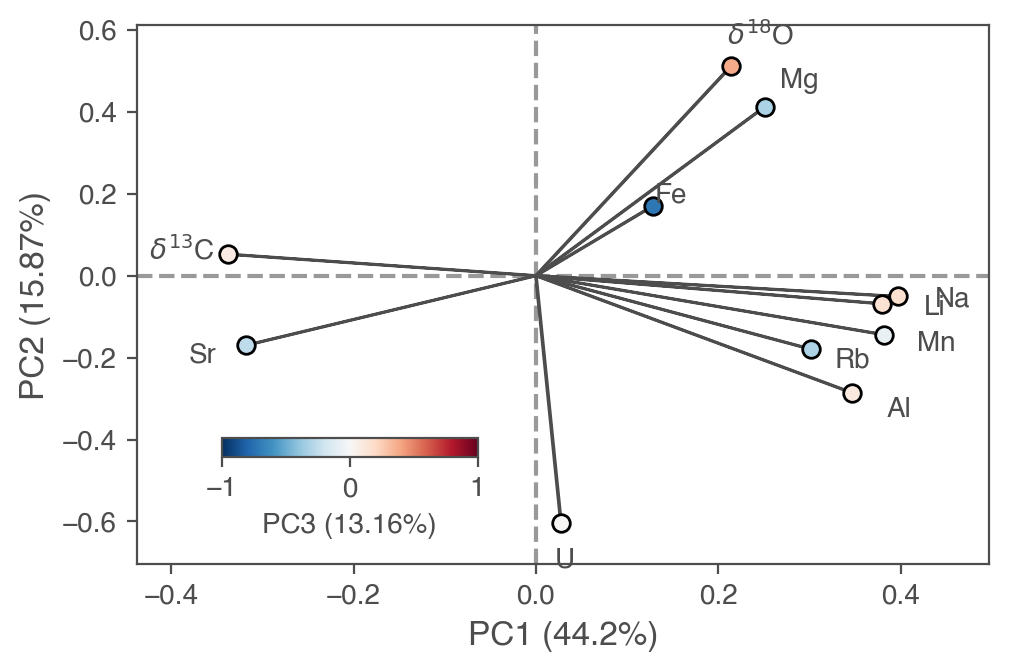

In [38]:
pca1.biplot()

### Scree Plot

Text(0.5, 1.0, 'data without mckale and boomerang clasts')

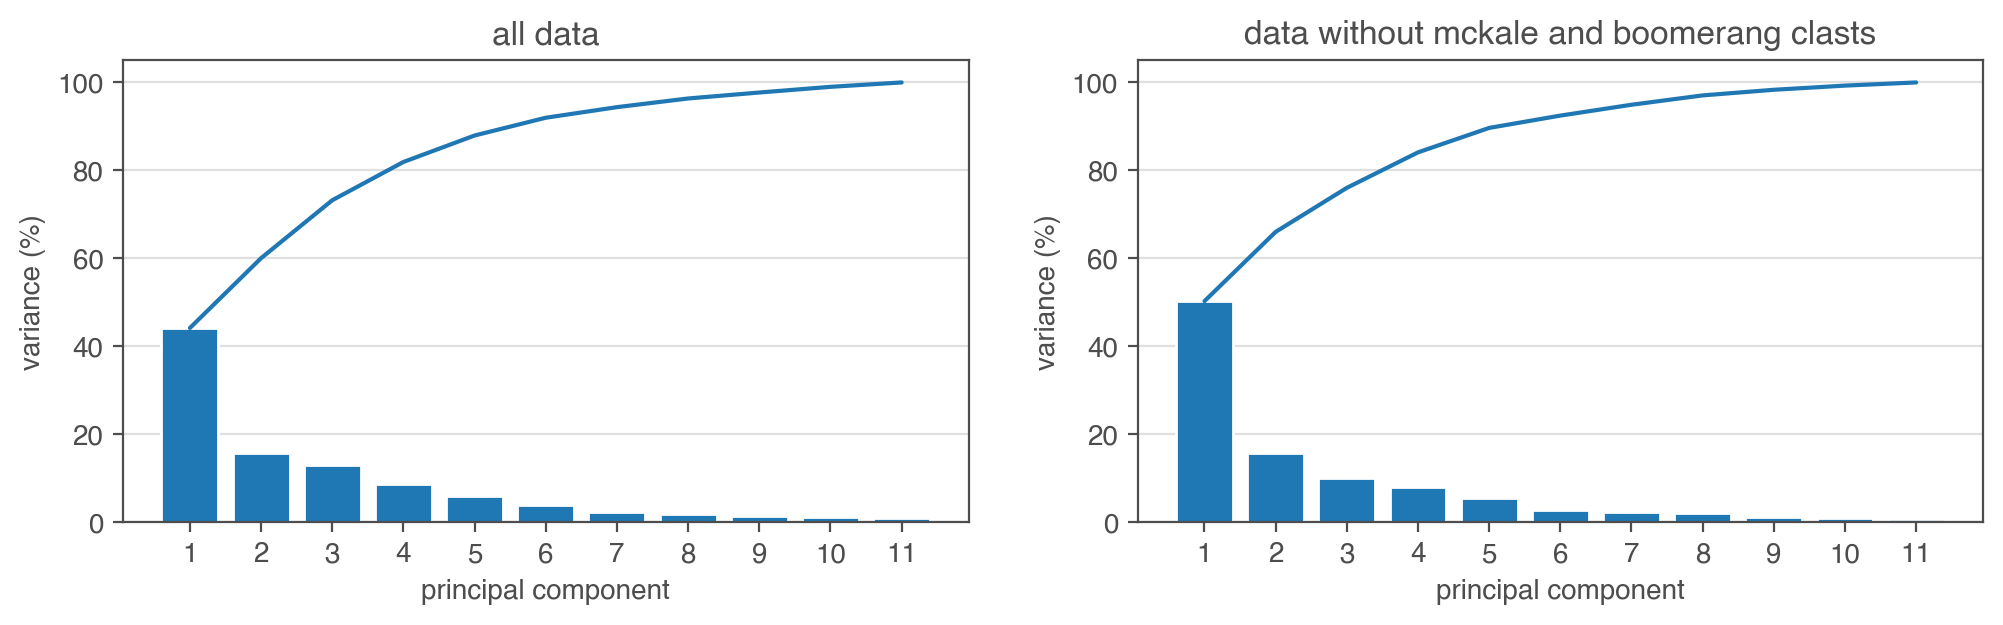

In [39]:
%matplotlib inline
fig,ax = plt.subplots(1,2,figsize=(12,3))
pca1.scree(ax=ax[0])
pca2.scree(ax=ax[1])
ax[0].set_title('all data')
ax[1].set_title('data without mckale and boomerang clasts')

# Publication Figures

### Add column for X/(Ca+Mg)

In [40]:
comb.head()

index member       sample_name  sample_height sample_facies  \
0      GSM Type    WMM      C1_171_ICT_1          171.0   ls mudstone   
1  McKale Creek    WMM  C16_256.0_ICT_22          256.0   ls mudstone   
2     Boomerang    WMM     C12_5.6_ICT_3            5.6     dolostone   
3     Boomerang    WMM     C12_5.6_ICT_4            5.6     dolostone   
4  McKale Creek    WMM  C16_256.0_ICT_20          256.0   ls mudstone   

  sample_features sample_facies_simplified sample_lith trace_facies  \
0             NaN              ls mudstone          ls  ls mudstone   
1             NaN              ls mudstone          ls  ls mudstone   
2             NaN                dolostone         dol    dolostone   
3             NaN                dolostone         dol    dolostone   
4             NaN              ls mudstone          ls  ls mudstone   

   length_cm  width_cm colour  d13c_carb  d18o_carb   id  clast_len_cm  \
0       15.0       2.0   grey  -4.322121 -15.890038  NaN           NaN   
1        NaN       NaN    NaN  -2.344838 -17.627228  NaN           NaN   
2        NaN       NaN    NaN  -9.684889 -11.699412  NaN           NaN   
3        NaN       NaN    NaN  -9.885686 -11.018311  NaN           NaN   
4        NaN       NaN    NaN  -2.995198 -17.593922  NaN           NaN   

   clast_width_cm  min_drildist_from_matrix_mm  Li_umol_molCa  Na_mmol_molCa  \
0             NaN                          NaN      20.079494       0.808736   
1             NaN                          NaN       4.059244       0.763672   
2             NaN                          NaN      37.494553       1.153022   
3             NaN                          NaN      25.650373       1.189076   
4             NaN                          NaN       2.600318       0.228277   

   Mg_mmol_molCa  Al_mmol_molCa  K_mmol_molCa  V_umol_molCa  Mn_mmol_molCa  \
0      24.976863       0.213600      1.408899      0.055166       2.617457   
1      19.058189       0.117275      0.712036      0.006541       1.361786   
2     571.447824       0.085904      2.165392      0.022325      18.153051   
3     587.854005       0.090723      2.609409     -0.205460      18.983847   
4      19.832929       0.067243      0.469536     -0.003159       1.225244   

   Fe_mmol_molCa  Rb_umol_molCa  Sr_mmol_molCa  Th_umol_molCa  U_umol_molCa  \
0       1.241445       2.110039       2.095753       0.003059      0.683157   
1       5.903971       1.107052       2.111124       0.014308      0.321558   
2      63.592978       3.456993       0.553421       0.007400      0.234369   
3      55.510674       4.366351       0.286552       0.006387      0.095831   
4       7.496906       0.637848       2.321251       0.002047      0.188568   

   Beam Area facies  Li_umol_molCa_Mg  Na_mmol_molCa_Mg  Mg_mmol_molCa_Mg  \
0        NaN    NaN         19.590193          0.789029         24.368221   
1        NaN    NaN          3.983329          0.749390         18.701767   
2        NaN    NaN         23.859878          0.733732        363.644160   
3        NaN    NaN         16.154113          0.748857        370.219178   
4        NaN    NaN          2.549749          0.223838         19.447233   

   Al_mmol_molCa_Mg  K_mmol_molCa_Mg  V_umol_molCa_Mg  Mn_mmol_molCa_Mg  \
0          0.208395         1.374567         0.053822          2.553675   
1          0.115081         0.698720         0.006418          1.336318   
2          0.054666         1.377960         0.014207         11.551800   
3          0.057136         1.643356        -0.129395         11.955663   
4          0.065935         0.460405        -0.003098          1.201417   

   Fe_mmol_molCa_Mg  Rb_umol_molCa_Mg  Sr_mmol_molCa_Mg  Th_umol_molCa_Mg  \
0          1.211194          2.058621          2.044683          0.002984   
1          5.793557          1.086348          2.071642          0.014041   
2         40.467763          2.199878          0.352173          0.004709   
3         34.959558          2.749844          0.180

## Oxygen version with no kde and spacing adjusted

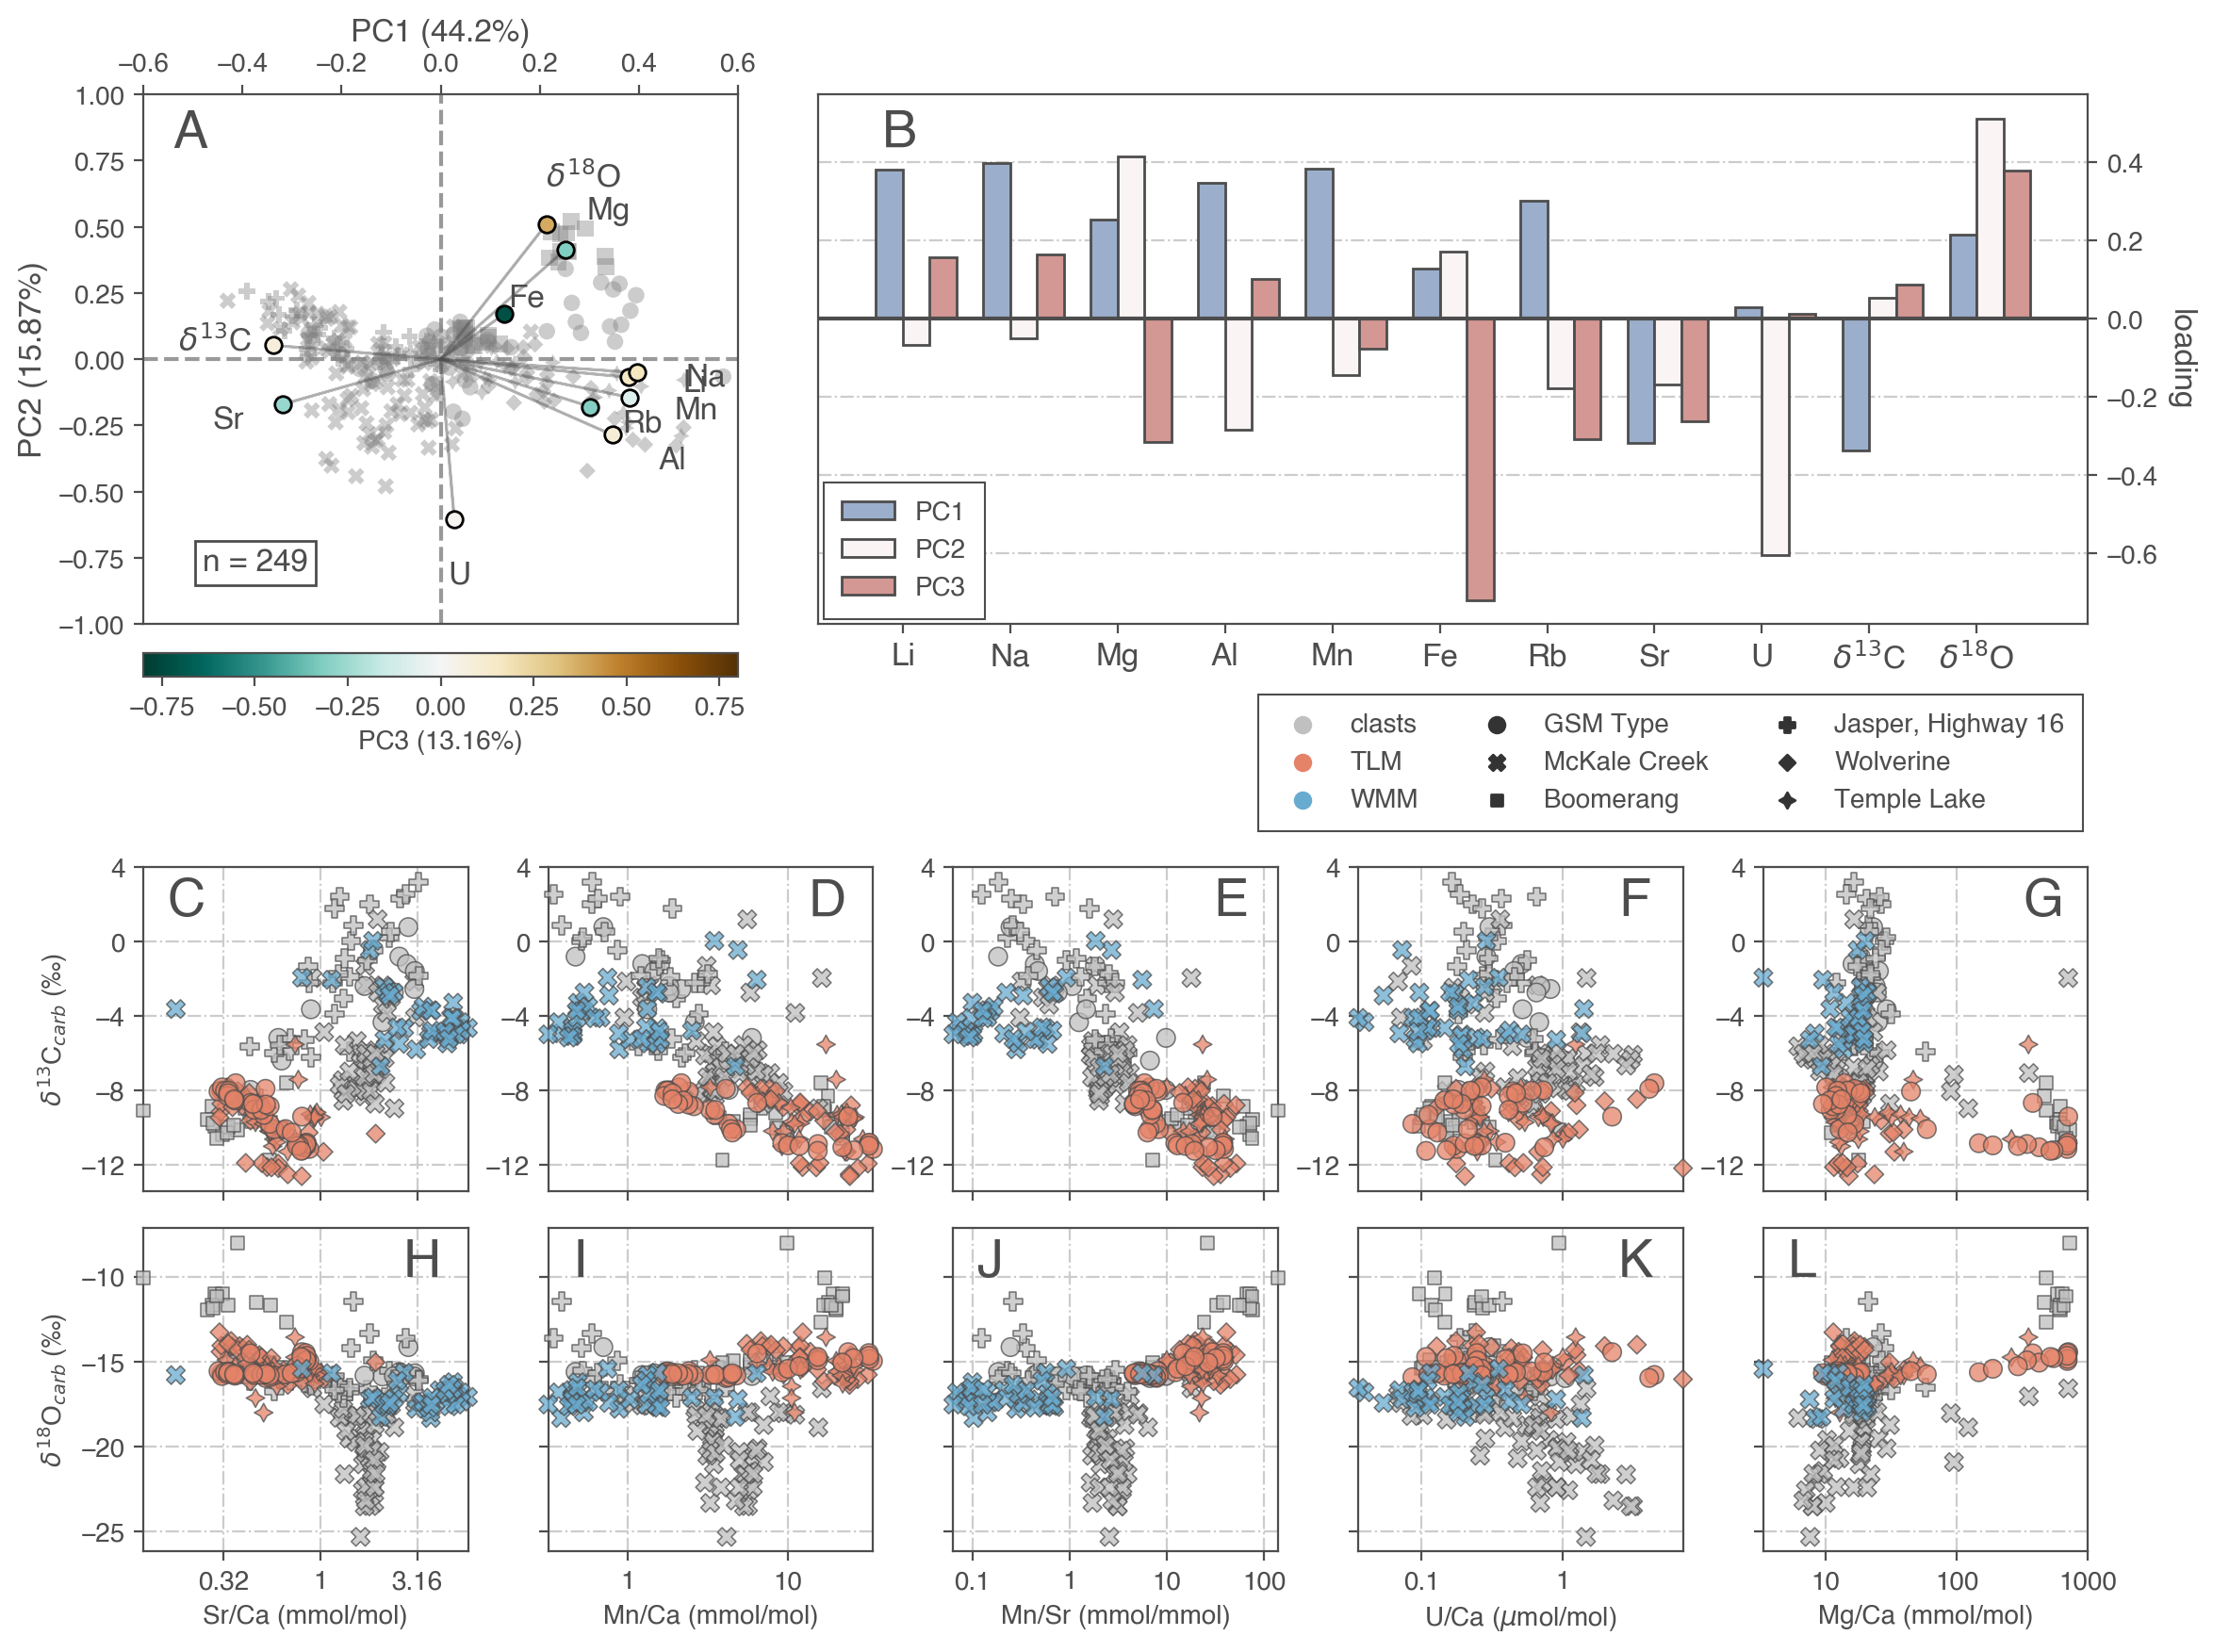

In [41]:
%matplotlib inline
# sns.set_context('paper')

fig = plt.figure(figsize=(14.5,13))

gs = gridspec.GridSpec(110,110)
# top row
ax0 = plt.subplot(gs[0:31,0:31])
ax1 = plt.subplot(gs[0:31,35:101])
# bottom row
d1 = 21
d2 = d1-4
end = 64
start = 45
diff = end-start
ax2 = plt.subplot(gs[start:end,0:d2])
ax3 = plt.subplot(gs[start:end,d1:d2+d1])
ax4 = plt.subplot(gs[start:end,2*d1:d2+2*d1])
ax5 = plt.subplot(gs[start:end,3*d1:d2+3*d1])
ax6 = plt.subplot(gs[start:end,4*d1:d2+4*d1])

# bottom row 2
d11 = 21
d22 = d1-4
start1 = end+2
end1 = start1+diff
ax12 = plt.subplot(gs[start1:end1,0:d22])
ax13 = plt.subplot(gs[start1:end1,d11:d22+d11])
ax14 = plt.subplot(gs[start1:end1,2*d11:d22+2*d11])
ax15 = plt.subplot(gs[start1:end1,3*d11:d22+3*d11])
ax16 = plt.subplot(gs[start1:end1,4*d11:d22+4*d11])

axs = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax12,ax13,ax14,ax15,ax16]

# pca
pca = pca1
pca.biplot(1,2,ax=ax0,pc_c=3,show='arrow',scale=1,labelsize=12,palette='BrBG_r',out=False,labelpad=1.35,s_size=40,style=trace_pca['index'],
                               markers=['o',(4,0,0),'X',(4,1,0),'P','s'],legend=False,
                              arrowalpha=0.4,cb_bbox=[0,-0.1,1,0.045],vmin=-0.8,vmax=0.8,scatter=True,facecolor='grey',edgecolor='none',alpha=0.4,s=40,clip_on=False)
ax0.set_ylim(-1,1)
ax0.set_xlim(-.6,.6)
ax0.xaxis.set_ticks_position('top')
ax0.xaxis.set_label_position('top')

# loadings
pca.loading_plot(ax=ax1,cmap='vlag',percent=False)
ax1.yaxis.set_ticks_position('right')
ax1.yaxis.set_label_position('right')
leg = ax1.legend(loc=3,framealpha=1)
frame = leg.get_frame()
frame.set_edgecolor('.3')
frame.set_linewidth(.75)
frame.set_boxstyle('square')

# geochemistry
targs = ['Sr_mmol_molCa','Mn_mmol_molCa','Mn/Sr (mmol/mmol)','U_umol_molCa','Mg_mmol_molCa']
xlabs = ['Sr/Ca (mmol/mol)','Mn/Ca (mmol/mol)','Mn/Sr (mmol/mmol)','U/Ca ($\mu$mol/mol)','Mg/Ca (mmol/mol)']
#xlabs = ['log$_{10}$'+i for i in xlabs]

pal = sns.color_palette('RdBu',n_colors=3).as_hex()
pal[1]='silver'
pal = ['silver','#e58368', '#68abd0'] # wasn't plotting in the order I wanted

for i,k,t,l in zip([ax2,ax3,ax4,ax5,ax6],[ax12,ax13,ax14,ax15,ax16],targs,xlabs):
    # ofp scatter - sections and clasts
    sns.scatterplot(x=np.log10(comb[t]),y=comb['d13c_carb'],hue=comb['type'],style=comb['index'],palette=pal,ax=i,legend=True,alpha=0.75,edgecolor='.3',s=50,
                    zorder=1000,clip_on=False)
    sns.scatterplot(x=np.log10(comb[t]),y=comb['d18o_carb'],hue=comb['type'],style=comb['index'],palette=pal,ax=k,legend=True,alpha=0.75,edgecolor='.3',s=50,
                    zorder=1000,clip_on=False)
    # ofp kde
    #sns.kdeplot(x=np.log10(comb[t]),hue=comb['type'],palette=pal,ax=j,common_norm=False,legend=False,fill=True,alpha=.2)
    #sns.histplot(x=np.log10(comb[t]),hue=comb['type'],palette=pal,ax=j,common_norm=False,legend=False,alpha=.2)

    # format
    k.sharex(i)
    # format x ticks with log scale
    ticks_x = FuncFormatter(lambda x, pos: '{0:g}'.format(round(10**x,2)))
    i.xaxis.set_major_formatter(ticks_x)
    k.xaxis.set_major_formatter(ticks_x)
    i.set_xlim(np.log10(np.nanmin(comb[t])),np.log10(np.nanmax(comb[t])))
    k.set_xlim(np.log10(np.nanmin(comb[t])),np.log10(np.nanmax(comb[t])))
    #i.set_xticks(np.linspace(np.log10(np.nanmin(comb[t])),np.log10(np.nanmax(comb[t])),4))
    # format
    i.set_ylabel('$\delta^{13}$C$_{carb}$ (‰)')
    i.set_xlabel(None)
    k.set_ylabel('$\delta^{18}$O$_{carb}$ (‰)')
    k.set_xlabel(l)
    if l!=xlabs[-1]:
        i.legend().remove()
    k.legend().remove()
    
    if l!=xlabs[0]:
        i.set_ylabel(None)
        i.set_yticklabels([])
        k.set_ylabel(None)
        k.set_yticklabels([])
    #i.spines[['top']].set_visible(False)
    i.grid()
    i.set_zorder(1000)
    i.set_yticks([-12,-8,-4,0,4])
    k.grid()
    k.set_zorder(1000)
    #k.set_yticks([-12,-8,-4,0,4])
    plt.setp(i.get_xticklabels(), visible=False)

# format legend for localities only and color legend for clasts, tlm secs, wmm secs
h,l = ax6.get_legend_handles_labels()
#leg = ax6.legend(h[1:4]+h[5:],l[1:4]+l[5:],framealpha=1,loc=1,ncol=3,bbox_to_anchor=(1,1.5))
leg = ax6.legend(h[1:4]+h[5:],['clasts','TLM','WMM']+l[5:],framealpha=1,loc=1,ncol=3,bbox_to_anchor=(1,1.55))

frame = leg.get_frame()
frame.set_edgecolor('.3')
frame.set_linewidth(.75)
frame.set_boxstyle('square')

# ax sharing carbon y axis
for i in [ax3,ax4,ax5,ax6]:
    i.sharey(ax2)

# label
labs = string.ascii_uppercase[:len(axs)]
for i,l in enumerate(labs):
    #print(i,l)
    if i<=1:
        axs[i].text(0.05,0.9,l,transform=axs[i].transAxes,fontsize=20,zorder=1000)
    elif l in ['C','I','J','L']:
        axs[i].text(0.075,0.85,l,transform=axs[i].transAxes,fontsize=20,zorder=1000)
    else:
        axs[i].text(0.8,0.85,l,transform=axs[i].transAxes,fontsize=20,zorder=1000)

# label n
ax0.text(0.1,0.1,f'n = {len(pca.trace_df)}',transform=ax0.transAxes,fontsize=12,bbox=dict(facecolor='w',edgecolor='.3',lw=1,mutation_aspect=1,boxstyle='square,pad=0.25'))

# set proper xticks
#zip([ax2,ax3,ax4,ax5,ax6],[ax12,ax13,ax14,ax15,ax16]
for idx,(i,j) in enumerate(zip([ax2,ax3,ax4,ax5,ax6],[ax12,ax13,ax14,ax15,ax16])):
    if idx>3:       
        i.set_xticks([np.log10(i) for i in [10,100,1000]])
        j.set_xticks([np.log10(i) for i in [10,100,1000]])

# save fig
#fig.savefig(fig_dir+'trace1.pdf',format='pdf',bbox_inches='tight',transparent=True)

In [42]:
# comb['Al_mmol_molCa']

## Version with just elemental plots (will have single biplot as a secondary figure)
- didn't include the kde's because they looked super bad with the axes limits I would like for data clarity

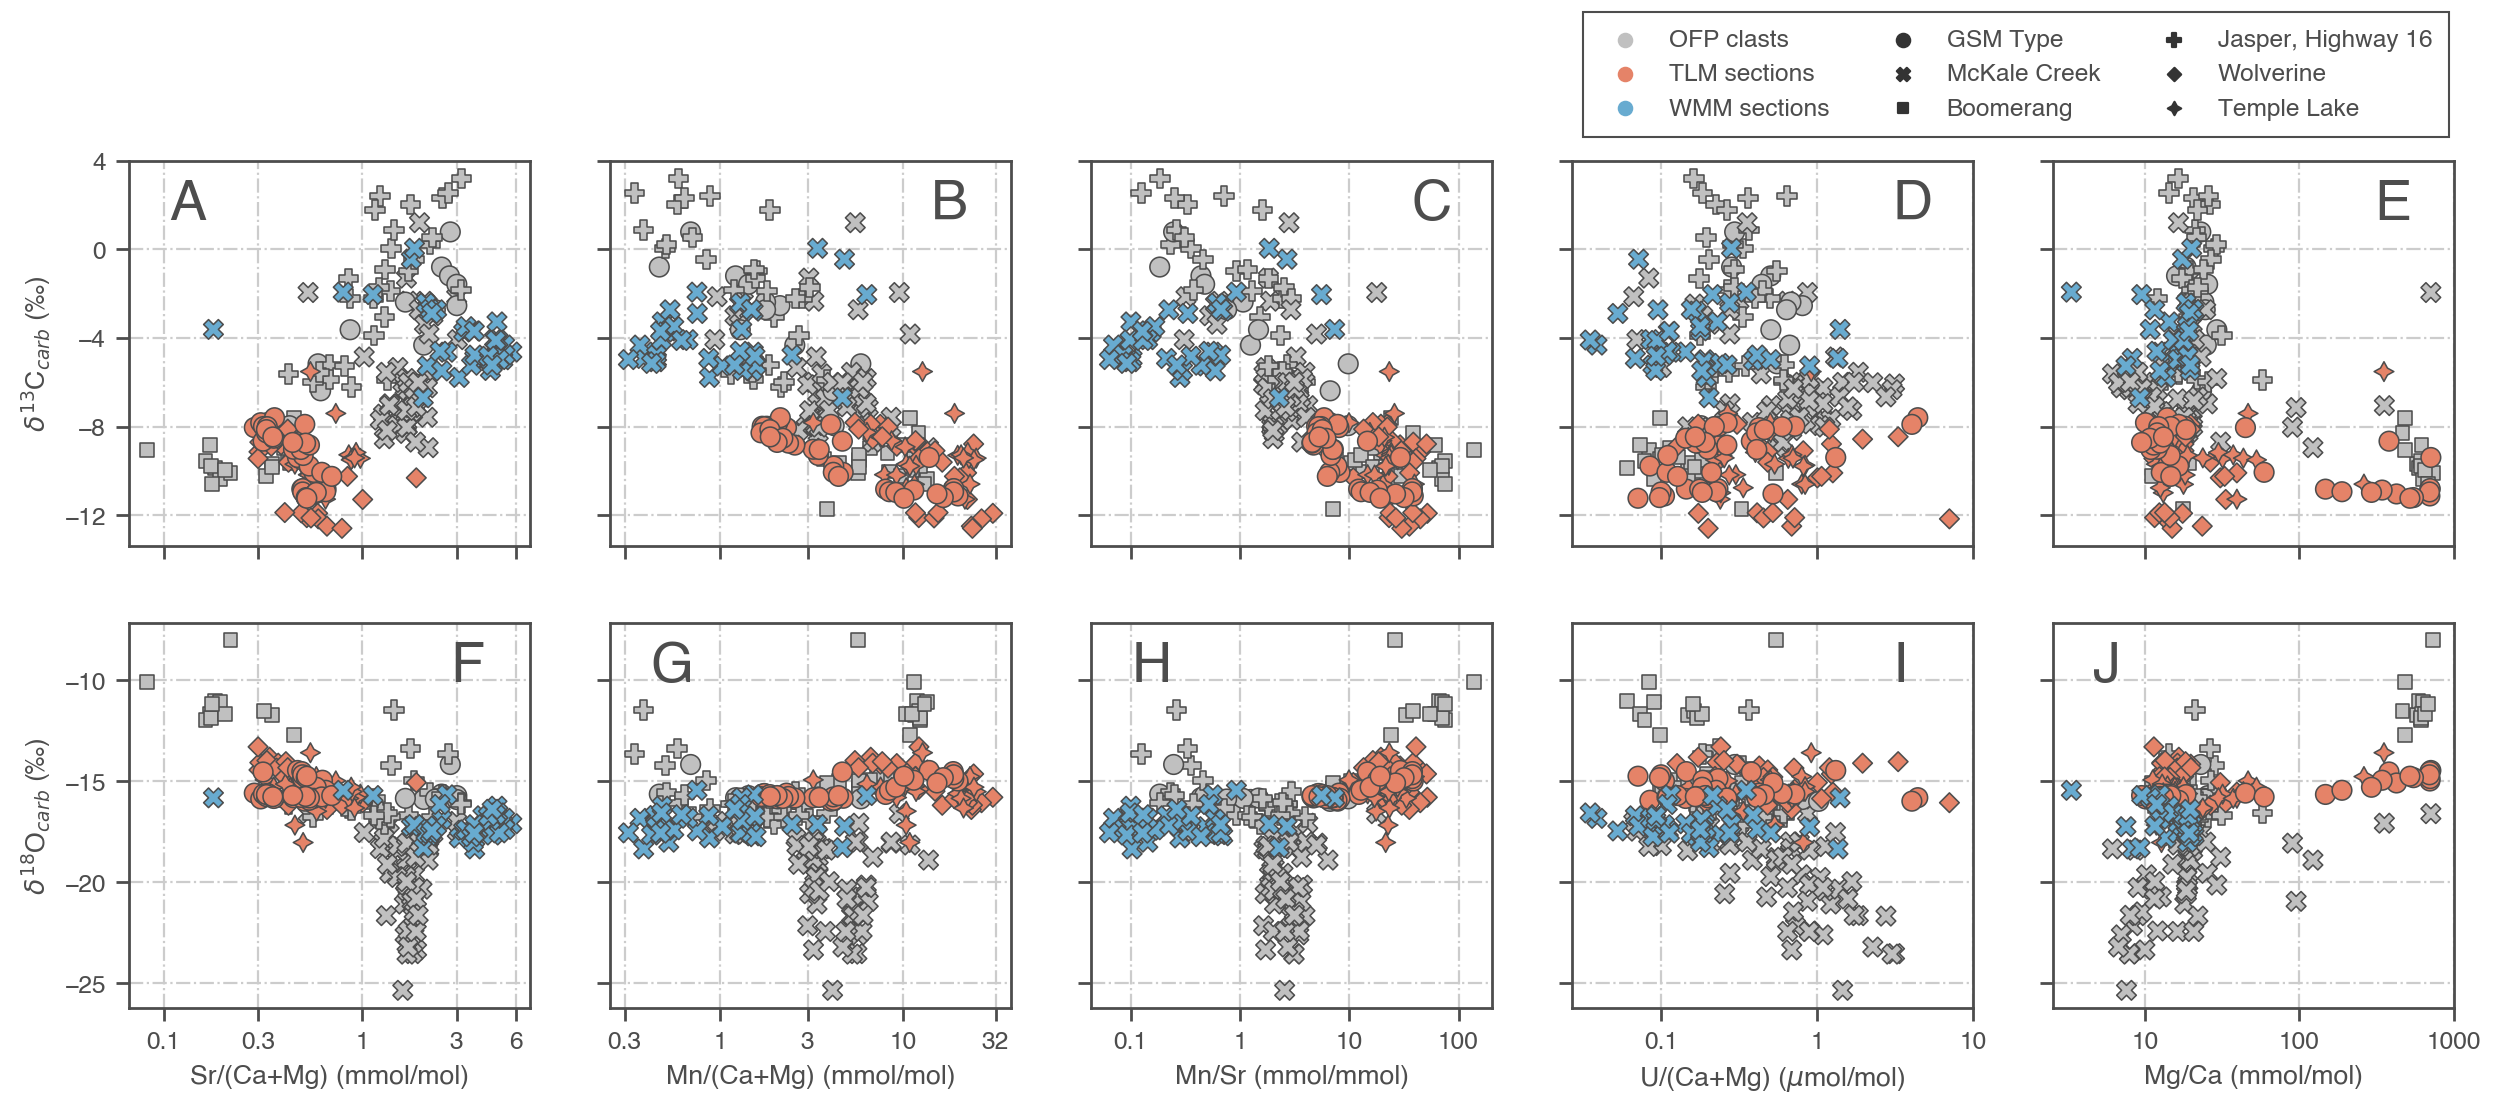

In [43]:
sns.set_context('paper')

fig,ax = plt.subplots(2,5,figsize=(15,5.5),sharex='col',sharey='row')
axs = ax.ravel()
# geochemistry
targs = ['Sr_mmol_molCa_Mg','Mn_mmol_molCa_Mg','Mn/Sr (mmol/mmol)','U_umol_molCa_Mg','Mg_mmol_molCa']
xlabs = ['Sr/(Ca+Mg) (mmol/mol)','Mn/(Ca+Mg) (mmol/mol)','Mn/Sr (mmol/mmol)','U/(Ca+Mg) ($\mu$mol/mol)','Mg/Ca (mmol/mol)']
#xlabs = ['log$_{10}$'+i for i in xlabs]

pal = sns.color_palette('RdBu',n_colors=3).as_hex()
pal[1]='silver'
pal = ['silver','#e58368', '#68abd0'] # wasn't plotting in the order I wanted

for i,j,t,l in zip(ax[0,:],ax[1,:],targs,xlabs):
    # ofp scatter - sections and clasts
    alpha=1
    sns.scatterplot(x=np.log10(comb[t]),y=comb['d13c_carb'],hue=comb['type'],style=comb['index'],palette=pal,ax=i,legend=True,alpha=alpha,edgecolor='.3',zorder=1000,clip_on=False,
                   s=50)
    sns.scatterplot(x=np.log10(comb[t]),y=comb['d18o_carb'],hue=comb['type'],style=comb['index'],palette=pal,ax=j,legend=True,alpha=alpha,edgecolor='.3',zorder=1000,clip_on=False,
                   s=50)

    # ofp kde
    #sns.kdeplot(x=np.log10(comb[t]),hue=comb['type'],palette=pal,ax=j,common_norm=False,legend=False,fill=True,alpha=.2)

    i.set_yticks([-12,-8,-4,0,4])
    #j.set_yticks([-12,-8,-4,0,4])

    ticks_x = FuncFormatter(lambda x, pos: '{0:g}'.format(round(10**x,2)))
    for k in [i,j]: 
        k.xaxis.set_major_formatter(ticks_x)
        #k.set_xlim(np.log10(np.nanmin(comb[t])),np.log10(np.nanmax(comb[t])))
        #k.set_xticks(np.linspace(np.log10(np.nanmin(comb[t])),np.log10(np.nanmax(comb[t])),4))
        # format
        k.grid()
        k.set_zorder(1000)
        k.set_xlabel(l)
    if l!=xlabs[-1]:
        i.legend().remove()
    j.legend().remove()
    i.set_ylabel('$\delta^{13}$C$_{carb}$ (‰)')
    j.set_ylabel('$\delta^{18}$O$_{carb}$ (‰)')
    
# label 
labs = string.ascii_uppercase[:len(ax.ravel())]
for i,l in zip(ax.ravel(),labs):
    if l in ['B','C','D','E','F','I']:
        i.text(0.8,0.85,l,transform=i.transAxes,fontsize=20,zorder=1000)
    else:
        i.text(0.1,0.85,l,transform=i.transAxes,fontsize=20,zorder=1000)

# format legend for localities only and color legend for clasts, tlm secs, wmm secs
h,l = ax[0,4].get_legend_handles_labels()
leg = ax[0,4].legend(h[1:4]+h[5:],l[1:4]+l[5:],framealpha=1,loc=1,ncol=3,bbox_to_anchor=(1,1.4))
frame = leg.get_frame()
frame.set_edgecolor('.3')
frame.set_linewidth(.75)
frame.set_boxstyle('square')

# fix ticks  
axs[-1].set_xticks([np.log10(i) for i in [10,100,1000]]) # Mg/Ca
axs[8].set_xticks([np.log10(i) for i in [0.1,1,10]]) # U/Ca
axs[6].set_xticks([np.log10(i) for i in [0.3,1,3,10,32]]) # Mn/Ca
axs[5].set_xticks([np.log10(i) for i in [0.1,0.3,1,3,6]]) # Sr/Ca

fig.savefig(fig_dir+'trace_cross.pdf',format='pdf',bbox_inches='tight',transparent=True)

## PCA Figure - Seperate from trace elements this time

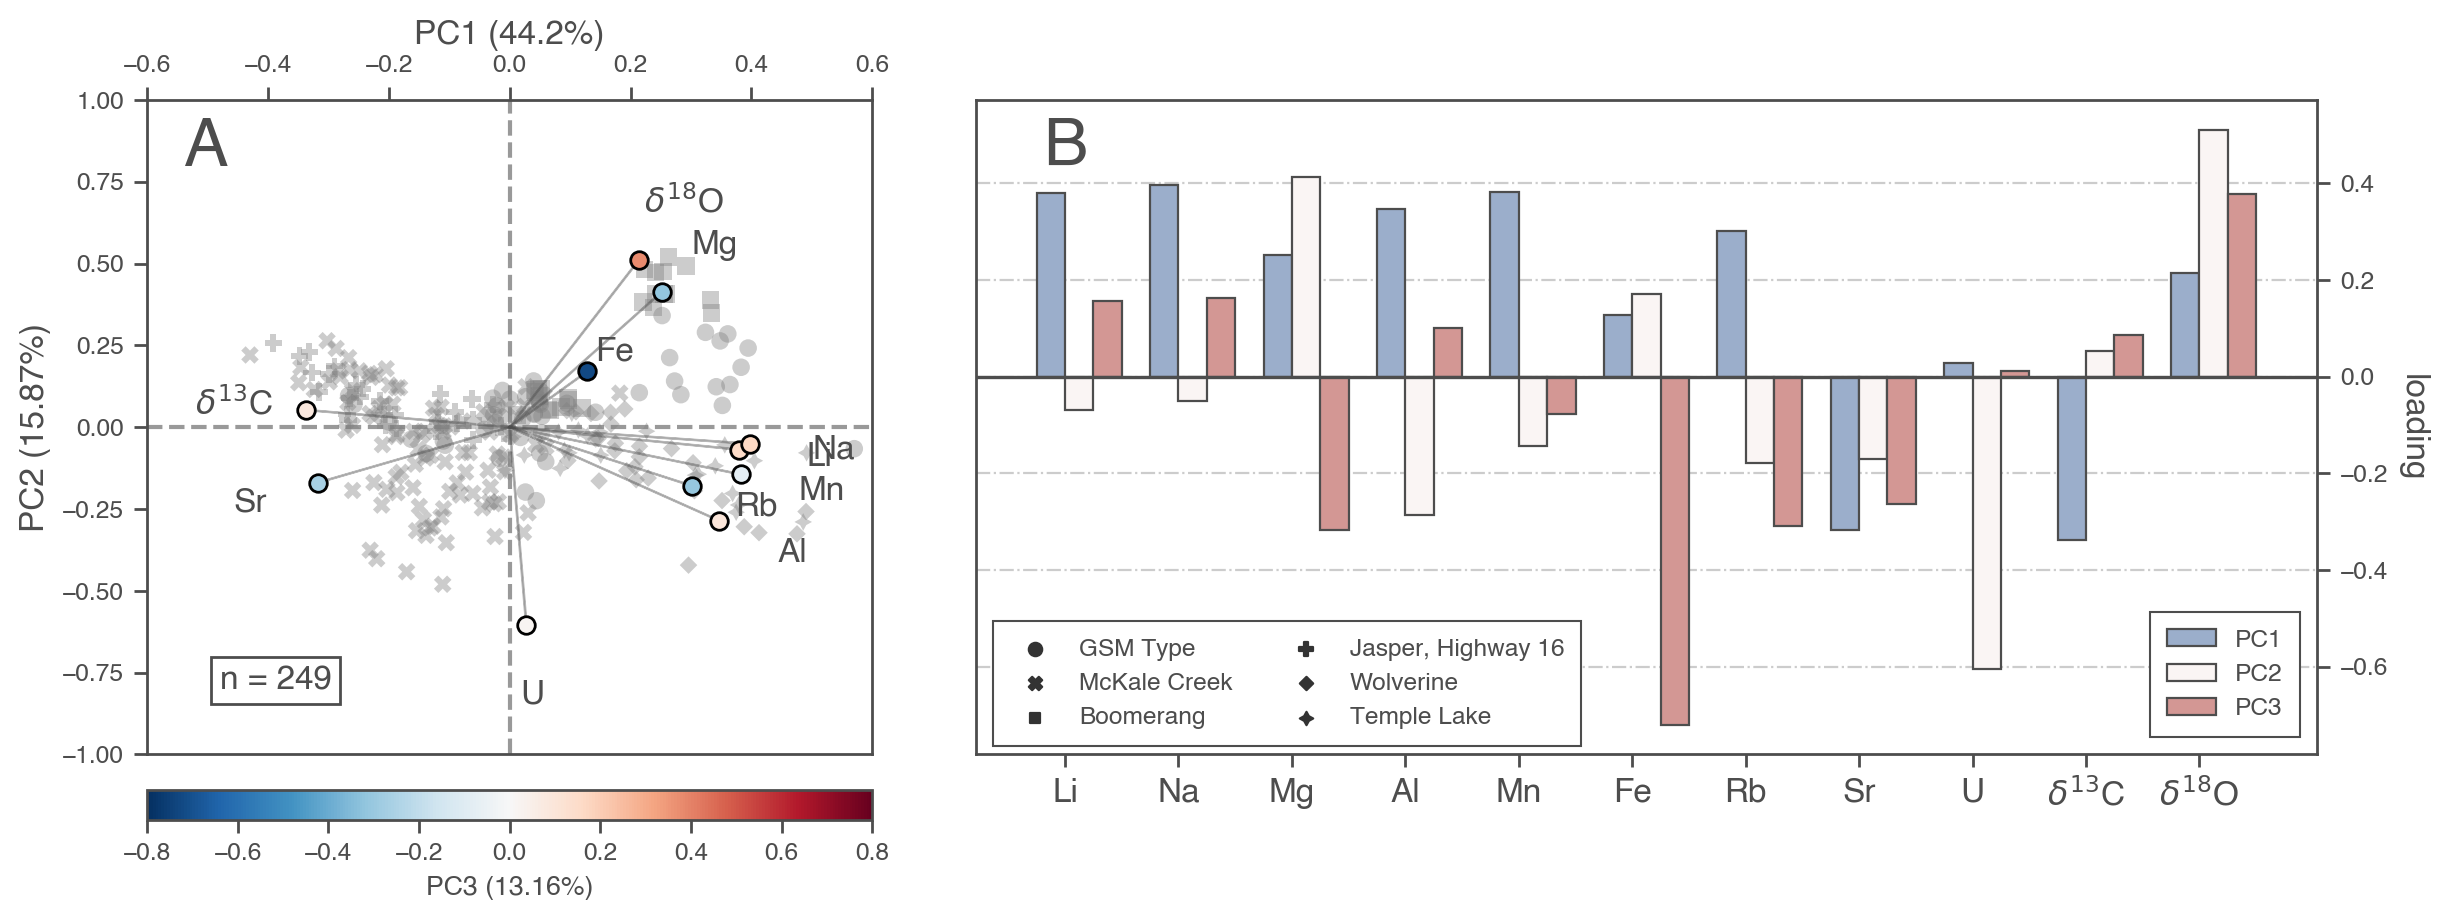

In [44]:
%matplotlib inline
# sns.set_context('paper')
fig,ax = plt.subplots(1,2,figsize=(14,4.25),width_ratios=[1,1.85])
plt.subplots_adjust(wspace=0.1)

# pca
pca = pca1
pca.biplot(1,2,ax=ax[0],pc_c=3,show='arrow',scale=1,labelsize=12,palette='RdBu_r',out=False,labelpad=1.35,s_size=40,style=trace_pca['index'],
                               markers=['o',(4,0,0),'X',(4,1,0),'P','s'],legend=False,
                              arrowalpha=0.4,cb_bbox=[0,-0.1,1,0.045],vmin=-0.8,vmax=0.8,scatter=True,facecolor='grey',edgecolor='none',alpha=0.4,s=40,clip_on=False)
ax[0].set_ylim(-1,1)
ax[0].set_xlim(-.6,.6)
ax[0].xaxis.set_ticks_position('top')
ax[0].xaxis.set_label_position('top')

# loadings
pca.loading_plot(ax=ax[1],cmap='vlag',percent=False)
ax[1].yaxis.set_ticks_position('right')
ax[1].yaxis.set_label_position('right')
leg1 = ax[1].legend(loc=4,framealpha=1,borderaxespad=1)
frame1 = leg1.get_frame()
frame1.set_edgecolor('.3')
frame1.set_linewidth(.75)
frame1.set_boxstyle('square')

# label
labs = string.ascii_uppercase[:len(axs)]
for i,lab in zip([0,1],labs):
    ax[i].text(0.05,0.9,lab,transform=ax[i].transAxes,fontsize=24,zorder=1000)
    
# label n
ax[0].text(0.1,0.1,f'n = {len(pca.trace_df)}',transform=ax[0].transAxes,fontsize=12,bbox=dict(facecolor='w',edgecolor='.3',lw=1,mutation_aspect=1,boxstyle='square,pad=0.25'))

# add legend with handels and labels from other plot
leg = ax[0].legend(h[5:],l[5:],framealpha=1,loc=3,ncol=2,bbox_to_anchor=(1.16,0.005))
frame = leg.get_frame()
frame.set_edgecolor('.3')
frame.set_linewidth(.75)
frame.set_boxstyle('square')
ax[0].set_zorder(1000)

# save fig
fig.savefig(fig_dir+'PCA.pdf',format='pdf',bbox_inches='tight',transparent=True)

In [45]:
secs['sample_name'][(secs['index']=='McKale Creek')&(secs['Sr_mmol_molCa']<1)]

230    C16_183.5
267    C16_269.3
Name: sample_name, dtype: object

# Zoom Plots for Interpreting (not for paper)

In [46]:
def eplot(by='d13c_carb',wmm=True,tlm=True):
    if by=='d13c_carb':
        xl = '$\delta^{13}$C (‰)'
    elif by=='d18o_carb':
        xl = '$\delta^{18}$O (‰)'
    # geochemistry
    targs = ['Sr_mmol_molCa_Mg','Mn_mmol_molCa_Mg','Mn/Sr (mmol/mmol)','U_umol_molCa_Mg','Mg_mmol_molCa']
    xlabs = ['Sr/Ca (mmol/mol)','Mn/Ca (mmol/mol)','Mn/Sr (mmol/mmol)','U/Ca ($\mu$mol/mol)','Mg/Ca (mmol/mol']
    xlabs = ['log$_{10}$'+i for i in xlabs]
    d = string.ascii_uppercase[:len(targs)]+'\n'+string.ascii_uppercase[len(targs):2*len(targs)]
    fig, ax = plt.subplot_mosaic(d,figsize=(18,6.5),sharey=False,sharex=False)#,layout='constrained')
    axs = list(ax.keys())
    se = comb[comb['label']=='Sections']
    cl = comb[comb['label']=='Clasts']
    if not wmm:
        se = se[se['index']!='McKale Creek'] 
    if not tlm:
        se = se[se['index']=='McKale Creek'] 
        cl = cl[~cl['index'].str.contains('Boomerang')] 

    a = sns.color_palette('tab10',n_colors=8).as_hex()
    pal = sns.color_palette(a[4:])
    for i,j,t,l in zip(axs[:len(targs)],axs[len(targs):],targs,xlabs):
        sns.scatterplot(x=np.log10(se[t]),y=se[by],hue=comb['index'],ax=ax[i],legend=True,alpha=0.75,edgecolor='.3',zorder=1000,style=comb['sample_lith'],clip_on=False)
        sns.scatterplot(x=np.log10(cl[t]),y=cl[by],hue=comb['index'],ax=ax[j],legend=True,alpha=0.75,edgecolor='.3',zorder=1000,style=comb['sample_lith'],clip_on=False)
        ax[i].legend(bbox_to_anchor=(1,-1.45),title='secs')
        ax[j].legend(bbox_to_anchor=(2,-.25),title='clasts')
        ax[i].set_ylabel(xl)
        ax[j].set_ylabel(xl)
        if i!='A':
            ax[i].legend().remove()
            ax[i].set_ylabel(None)
        if j!='F':
            ax[j].legend().remove()
            ax[j].set_ylabel(None)
        ax[i].grid()
        ax[i].set_xlabel(l)
        ax[j].grid()
        ax[j].set_xlabel(l)
        # format x ticks with log scale
        ticks_x = FuncFormatter(lambda x, pos: '{0:g}'.format(round(10**x,2)))
        ax[i].xaxis.set_major_formatter(ticks_x)
        ax[j].xaxis.set_major_formatter(ticks_x)
        ax[i].set_title('sections')
        ax[j].set_title('clasts')
        ax[i].set_xlabel(None)
        ax[i].set_xlim(min(np.log10(se[t])),max(np.log10(se[t])))
        ax[i].set_xticks(np.linspace(min(np.log10(se[t])),max(np.log10(se[t])),6))
        #ax[j].set_xlabel(None)
        ax[j].set_xlim(min(np.log10(cl[t])),max(np.log10(cl[t])))
        ax[j].set_xticks(np.linspace(min(np.log10(cl[t])),max(np.log10(cl[t])),6))

### PCA

Text(0.1, 0.1, 'n = 249')

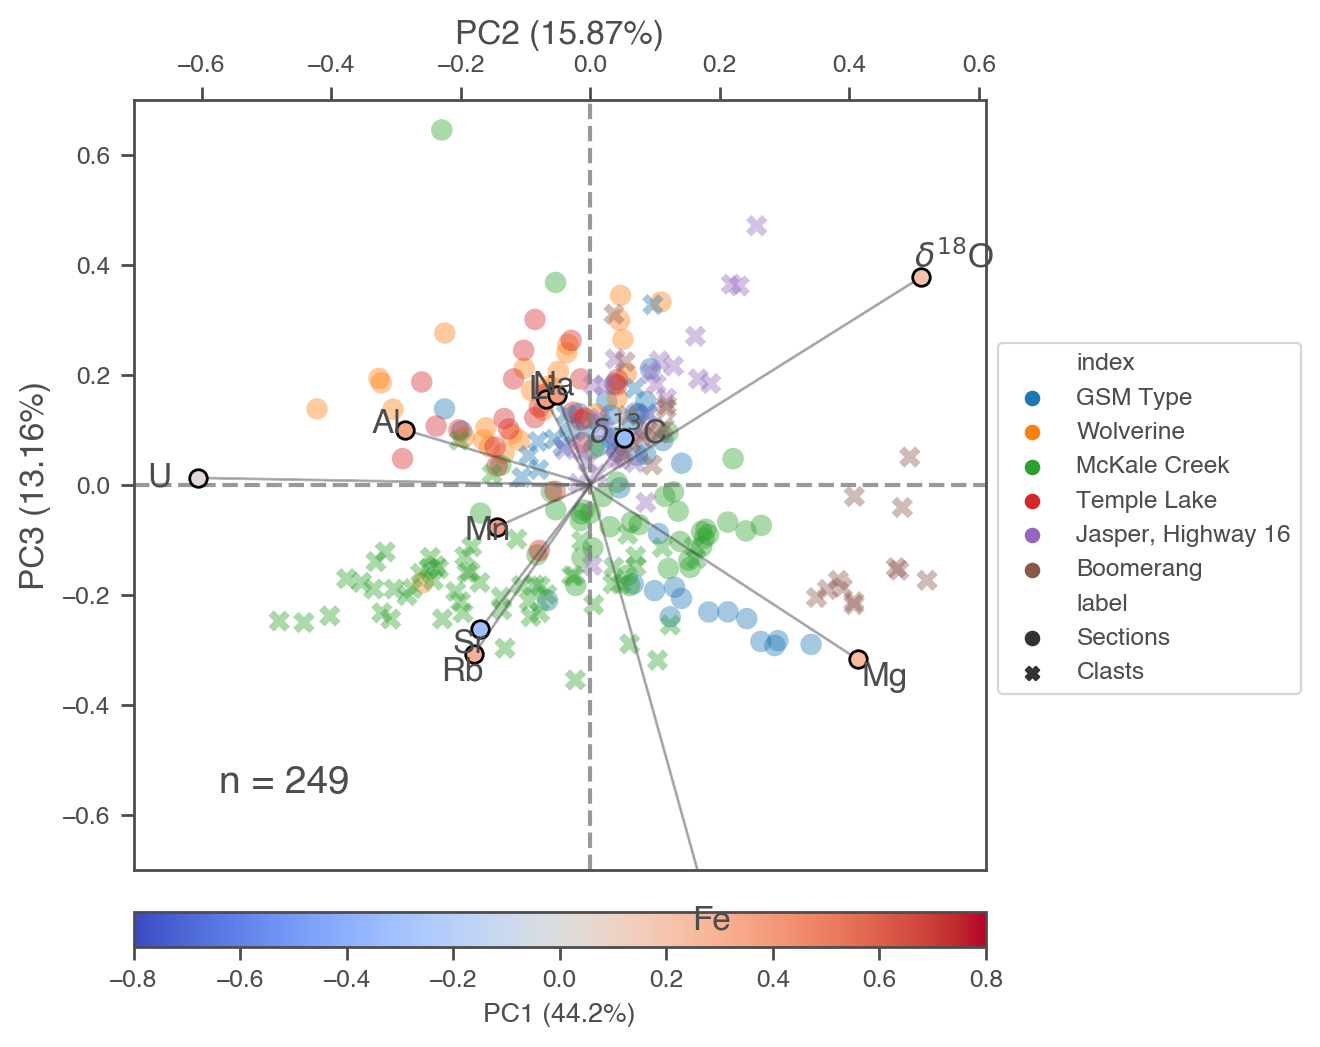

In [47]:
fig,ax = plt.subplots(figsize=(5.5,5))
p = pca1

p.biplot(2,3,ax=ax,pc_c=1,show='arrow',scale=1,labelsize=12,palette='coolwarm',out=False,labelpad=1.1,scale_scatter=True,hue=p.df['index'],style=p.df['label'],
                              arrowalpha=0.4,cb_bbox=[0,-0.1,1,0.045],vmin=-0.8,vmax=0.8,scatter=True,facecolor='grey',edgecolor='none',alpha=0.4,s=60,clip_on=False)
#ax.set_xlim(-.6,.6)
ax.set_ylim(-.7,.7)
ax.legend(loc=2,bbox_to_anchor=(1,0.7))
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.text(0.1,0.1,f'n = {len(p.df)}',transform=ax.transAxes,fontsize=14)

### Elements and Isotopes - Carbon

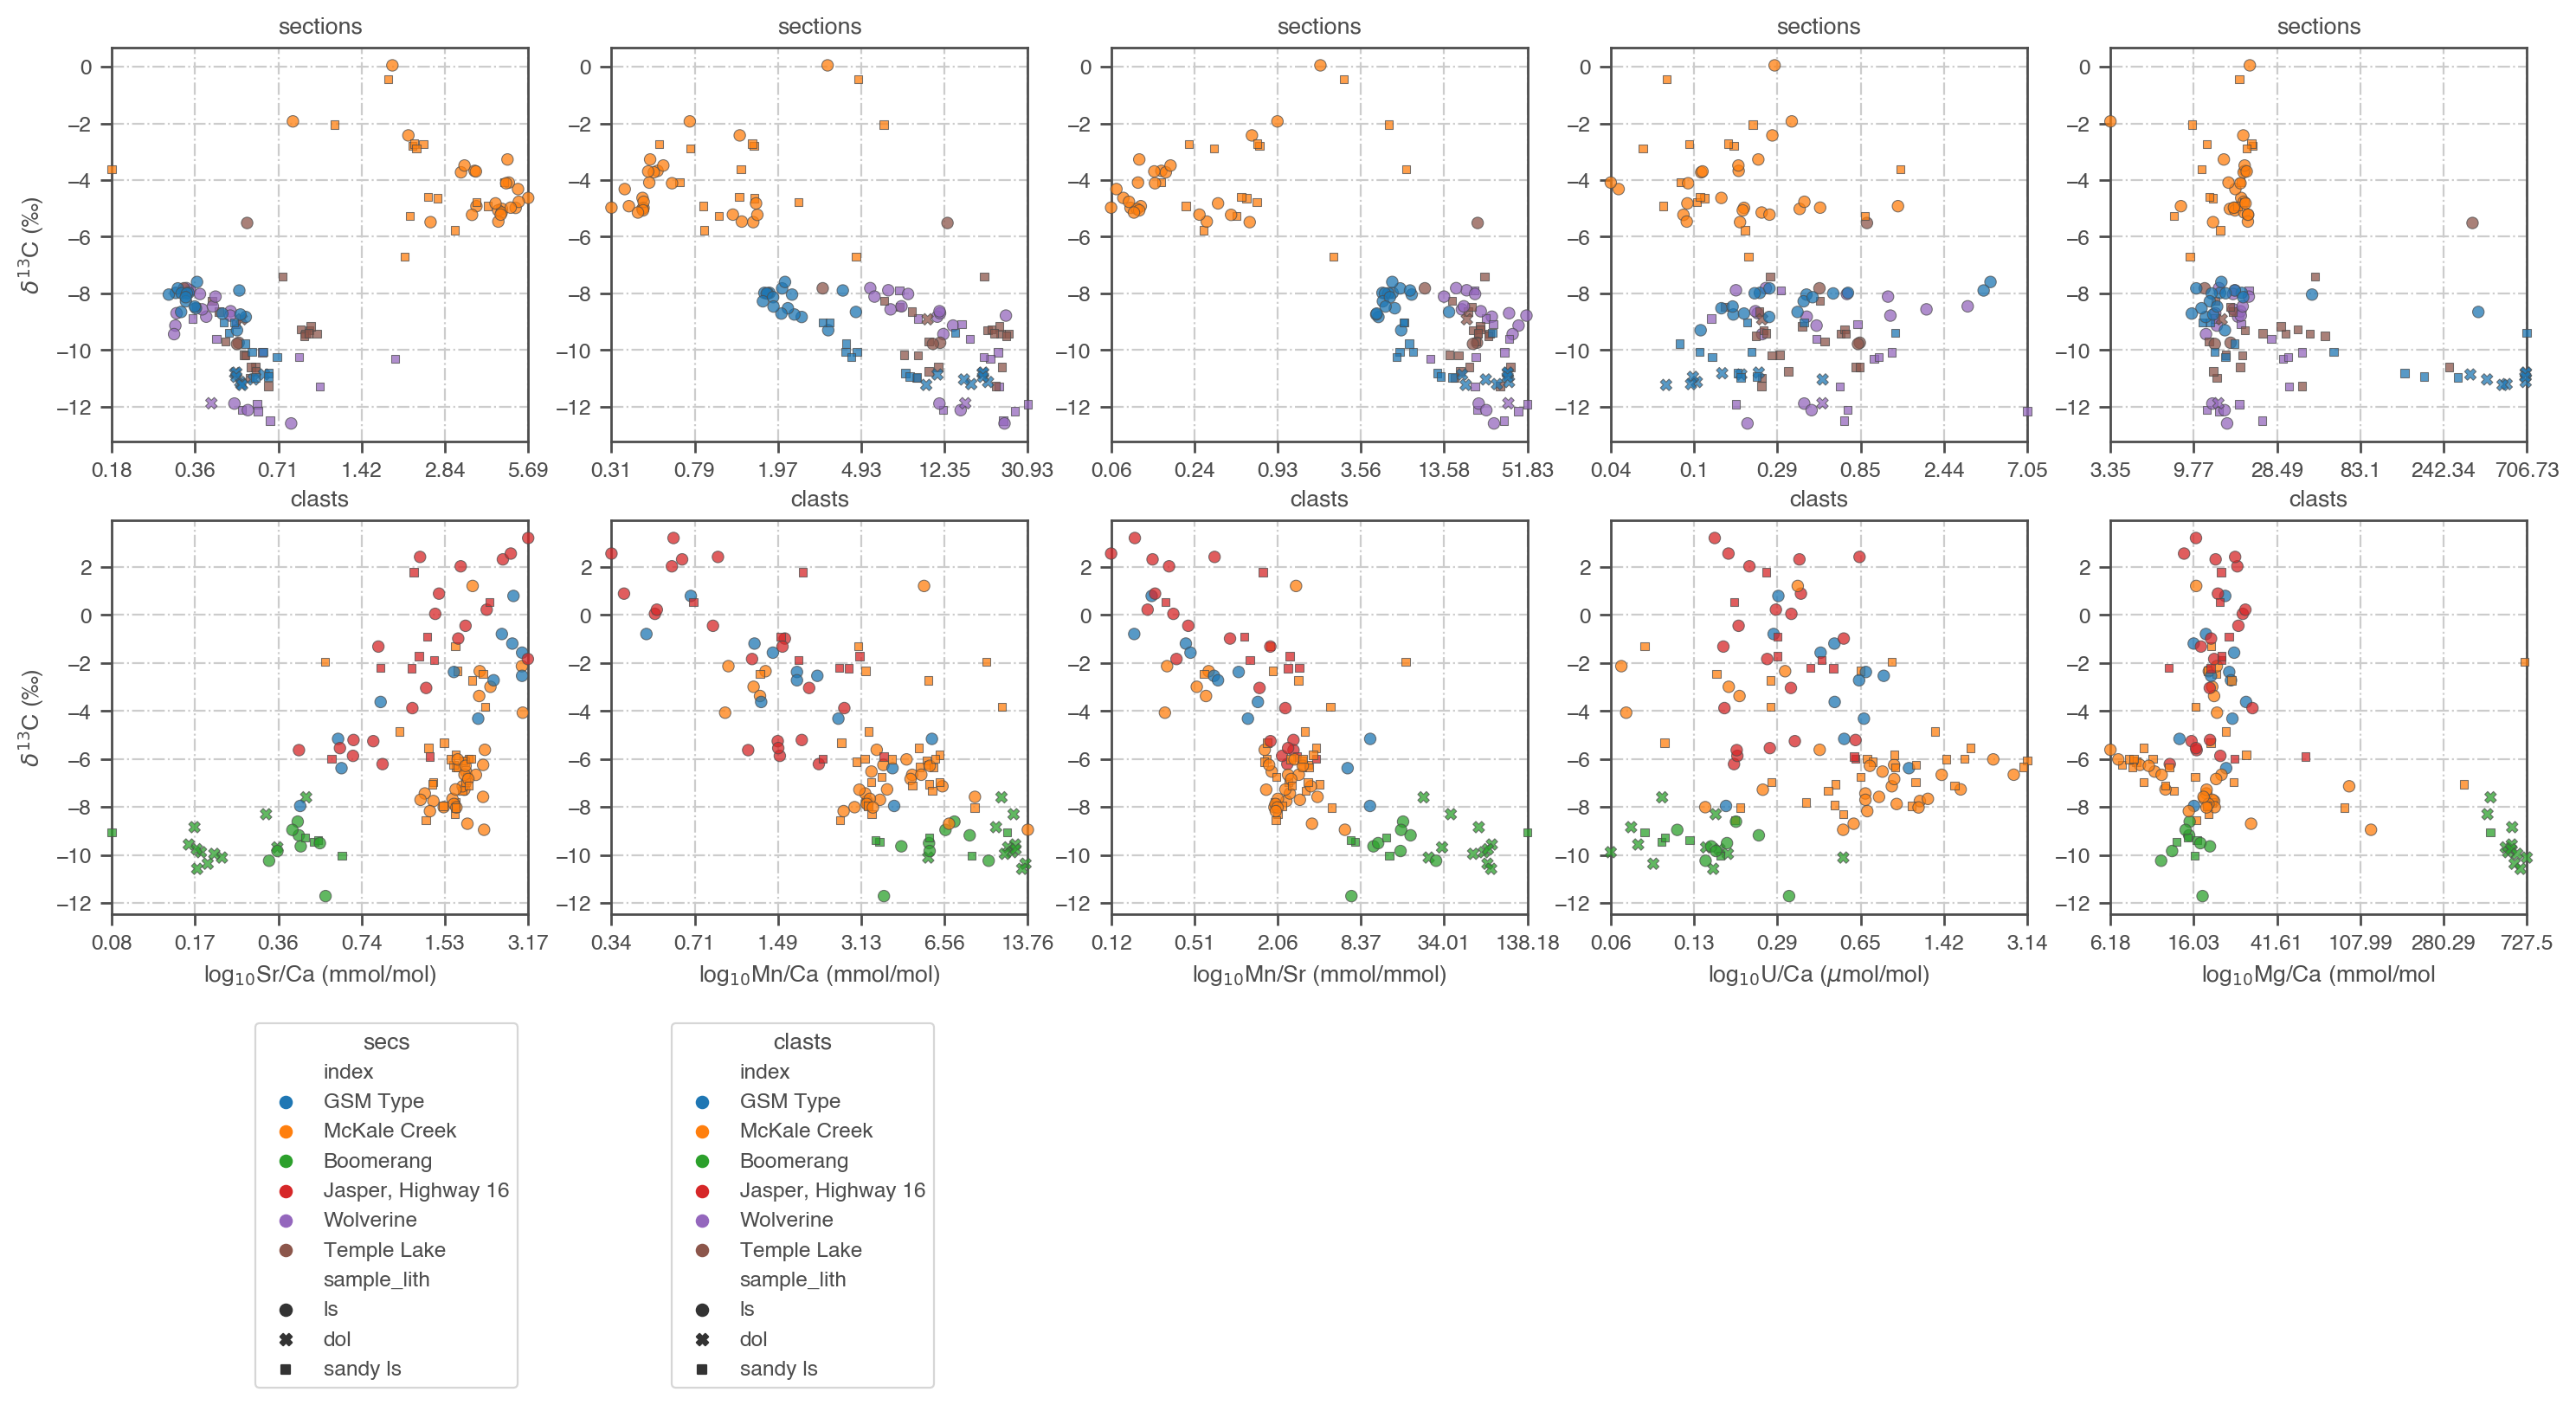

In [48]:
%matplotlib inline
eplot(by='d13c_carb',wmm=True,tlm=True)

### Elements and Isotopes - Oxygen

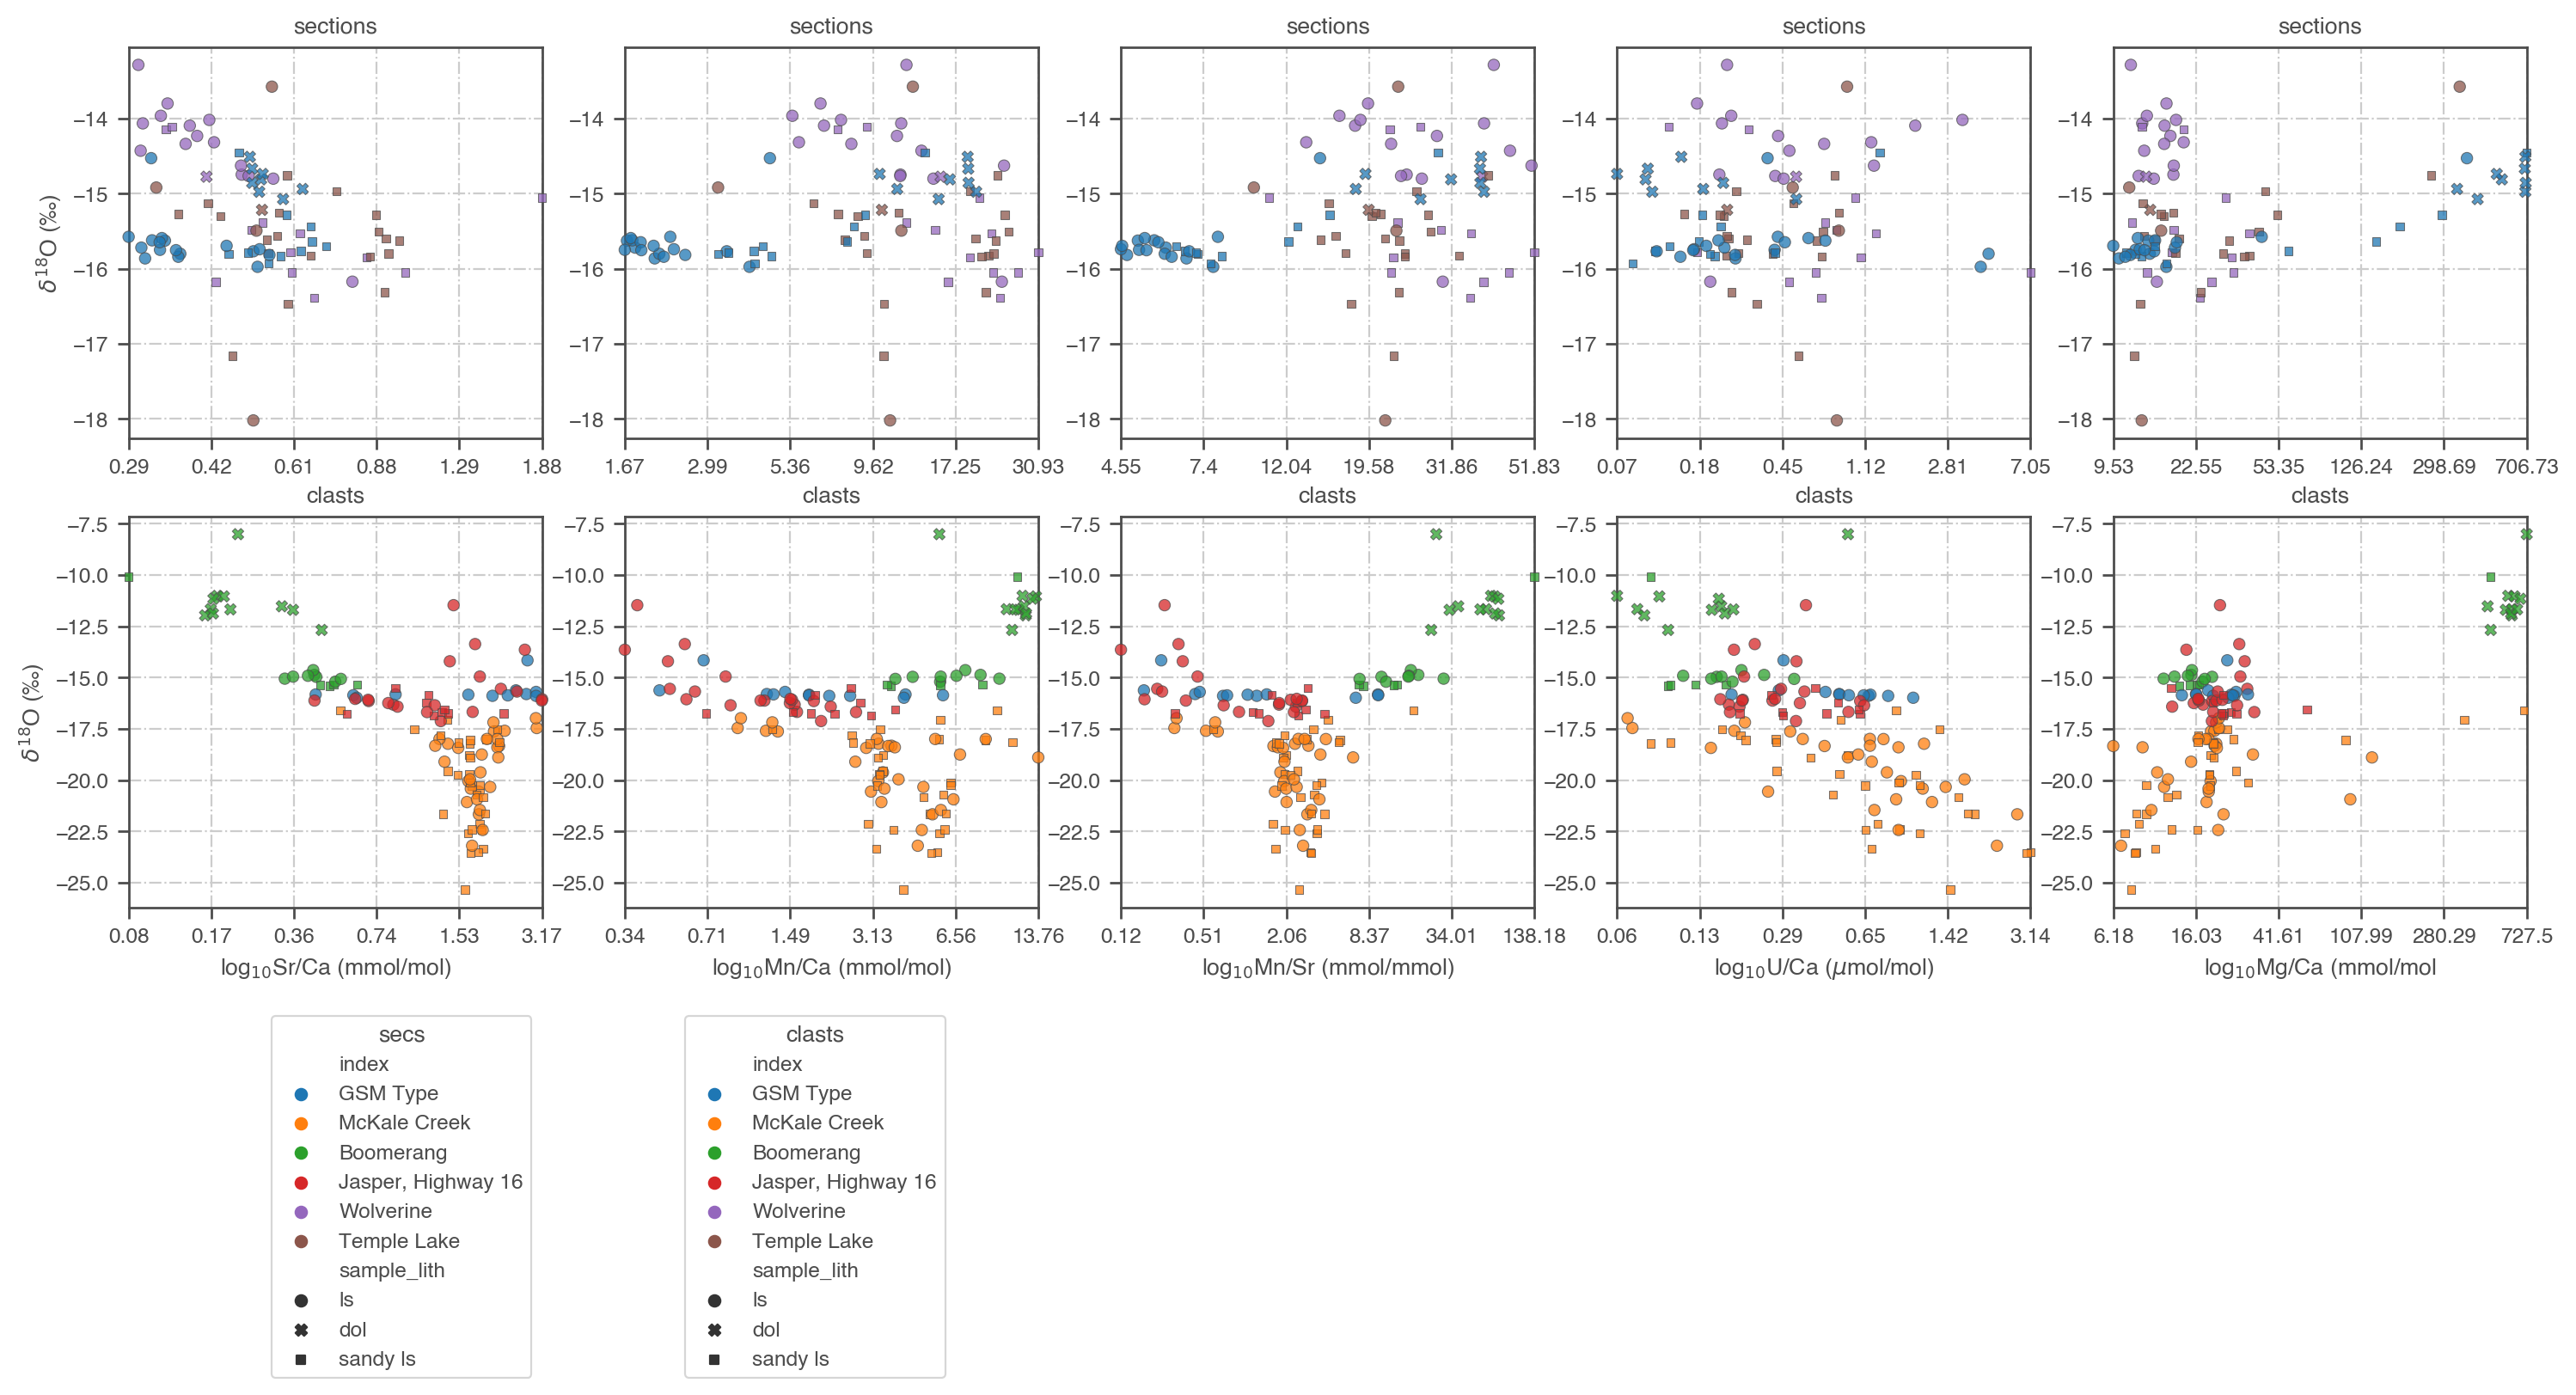

In [49]:
eplot(by='d18o_carb',wmm=False)

<Axes: xlabel='Al_mmol_molCa_Mg', ylabel='Density'>

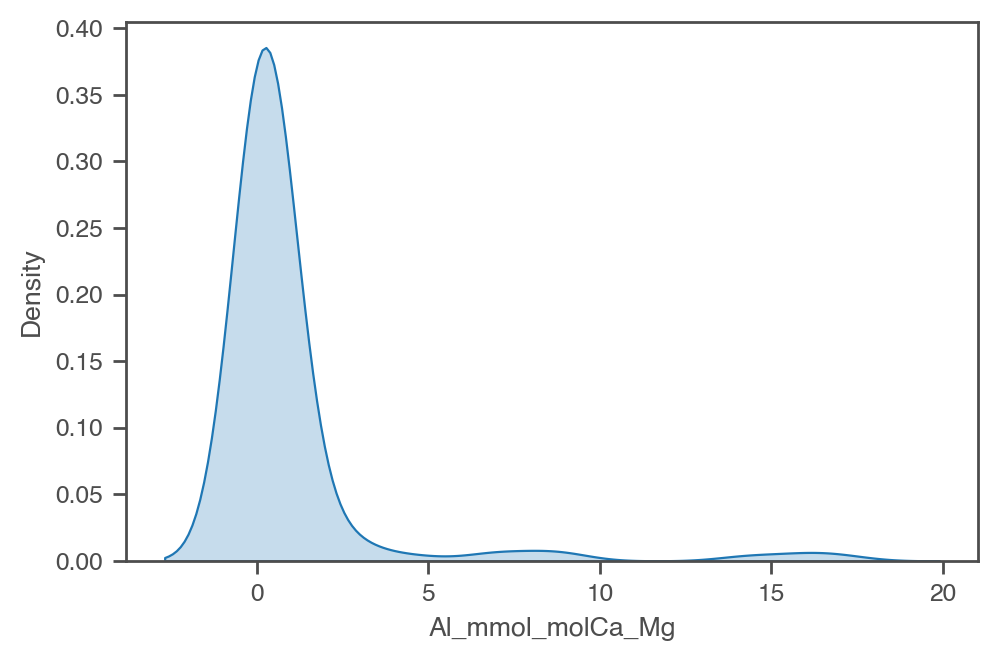

In [50]:
sns.kdeplot(comb['Al_mmol_molCa_Mg'],fill=True)

In [51]:
# fig,ax = plt.subplots(figsize=(5,4.5))
# d = tlm
# sns.scatterplot(x=np.log10(d['Fe_mmol_molCa']),y=np.log10(d['Mn_mmol_molCa']),hue=d['index'],s=40,ax=ax) # Mn_mmol_molCa
# ax.grid()
# ticks_x = FuncFormatter(lambda x, pos: '{0:g}'.format(round(10**x,2)))
# ax.xaxis.set_major_formatter(ticks_x)
# ax.yaxis.set_major_formatter(ticks_x)
# ax.legend(bbox_to_anchor=(1.35,1))
# # plt.plot(np.log10(d['Mg_mmol_molCa']),np.log10(d['Mg_mmol_molCa']),c='.3',)

## Plot of Mg/Ca vs Mn/Ca to suggest open system

In [52]:
# fig,ax = plt.subplots(1,2,figsize=(9,4),sharey=True)
# plt.subplots_adjust(wspace=.1)
# d = tlm.dropna(subset=['Mn_mmol_molCa'])
# x = np.log10(d['Mn_mmol_molCa'])
# xa = np.log10(d['Sr_mmol_molCa'])
# y = np.log10(d['Mg_mmol_molCa'])
# sns.scatterplot(x=x,y=y,hue=d['index'],s=60,ax=ax[0],edgecolor='.3',clip_on=False,zorder=100)
# sns.scatterplot(x=xa,y=y,hue=d['index'],s=60,ax=ax[1],edgecolor='.3',clip_on=False,zorder=100,legend=False) 

# [ax[i].grid() for i in [0,1]]
# ticks_x = FuncFormatter(lambda x, pos: '{0:g}'.format(round(10**x,2)))
# [ax[i].xaxis.set_major_formatter(ticks_x) for i in range(2)]
# [ax[i].yaxis.set_major_formatter(ticks_x) for i in range(2)]
# ax[0].set_xlabel('Mn/Ca (mmol/mol)')
# ax[1].set_xlabel('Sr/Ca (mmol/mol)')
# ax[0].set_ylabel('Mg/Ca (mmol/mol)')
# tkx = [np.log10(i) for i in [3,10,30]]
# tky = [np.log10(i) for i in [10,30,100,300,800]]
# tkz = [np.log10(i) for i in [0.3,0.6,1,2]]

# ax[0].set_xticks(tkx);
# ax[0].set_yticks(tky);
# ax[1].set_xticks(tkz)

# leg = ax[0].legend(framealpha=1,fontsize=10,borderaxespad=1,markerscale=1.5)
# frame = leg.get_frame()
# frame.set_edgecolor('.3')
# frame.set_linewidth(.75)
# frame.set_boxstyle('square')

# r,_,_,_,_ = linreg(x,y,type='pearson')
# rho,_,_,_,_ = linreg(x,y,type='spearman')

# print(f'r = {r:.2f}; rho = {rho:.2f}')
# t_stat, p_value = stats.ttest_ind(x,y) 
# print("T statistic:", t_stat)
# print("P-value:", p_value)

# # save fig
# fig.savefig(fig_dir+'open.pdf',format='pdf',bbox_inches='tight',transparent=True)

In [53]:
comb.head()

index member       sample_name  sample_height sample_facies  \
0      GSM Type    WMM      C1_171_ICT_1          171.0   ls mudstone   
1  McKale Creek    WMM  C16_256.0_ICT_22          256.0   ls mudstone   
2     Boomerang    WMM     C12_5.6_ICT_3            5.6     dolostone   
3     Boomerang    WMM     C12_5.6_ICT_4            5.6     dolostone   
4  McKale Creek    WMM  C16_256.0_ICT_20          256.0   ls mudstone   

  sample_features sample_facies_simplified sample_lith trace_facies  \
0             NaN              ls mudstone          ls  ls mudstone   
1             NaN              ls mudstone          ls  ls mudstone   
2             NaN                dolostone         dol    dolostone   
3             NaN                dolostone         dol    dolostone   
4             NaN              ls mudstone          ls  ls mudstone   

   length_cm  width_cm colour  d13c_carb  d18o_carb   id  clast_len_cm  \
0       15.0       2.0   grey  -4.322121 -15.890038  NaN           NaN   
1        NaN       NaN    NaN  -2.344838 -17.627228  NaN           NaN   
2        NaN       NaN    NaN  -9.684889 -11.699412  NaN           NaN   
3        NaN       NaN    NaN  -9.885686 -11.018311  NaN           NaN   
4        NaN       NaN    NaN  -2.995198 -17.593922  NaN           NaN   

   clast_width_cm  min_drildist_from_matrix_mm  Li_umol_molCa  Na_mmol_molCa  \
0             NaN                          NaN      20.079494       0.808736   
1             NaN                          NaN       4.059244       0.763672   
2             NaN                          NaN      37.494553       1.153022   
3             NaN                          NaN      25.650373       1.189076   
4             NaN                          NaN       2.600318       0.228277   

   Mg_mmol_molCa  Al_mmol_molCa  K_mmol_molCa  V_umol_molCa  Mn_mmol_molCa  \
0      24.976863       0.213600      1.408899      0.055166       2.617457   
1      19.058189       0.117275      0.712036      0.006541       1.361786   
2     571.447824       0.085904      2.165392      0.022325      18.153051   
3     587.854005       0.090723      2.609409     -0.205460      18.983847   
4      19.832929       0.067243      0.469536     -0.003159       1.225244   

   Fe_mmol_molCa  Rb_umol_molCa  Sr_mmol_molCa  Th_umol_molCa  U_umol_molCa  \
0       1.241445       2.110039       2.095753       0.003059      0.683157   
1       5.903971       1.107052       2.111124       0.014308      0.321558   
2      63.592978       3.456993       0.553421       0.007400      0.234369   
3      55.510674       4.366351       0.286552       0.006387      0.095831   
4       7.496906       0.637848       2.321251       0.002047      0.188568   

   Beam Area facies  Li_umol_molCa_Mg  Na_mmol_molCa_Mg  Mg_mmol_molCa_Mg  \
0        NaN    NaN         19.590193          0.789029         24.368221   
1        NaN    NaN          3.983329          0.749390         18.701767   
2        NaN    NaN         23.859878          0.733732        363.644160   
3        NaN    NaN         16.154113          0.748857        370.219178   
4        NaN    NaN          2.549749          0.223838         19.447233   

   Al_mmol_molCa_Mg  K_mmol_molCa_Mg  V_umol_molCa_Mg  Mn_mmol_molCa_Mg  \
0          0.208395         1.374567         0.053822          2.553675   
1          0.115081         0.698720         0.006418          1.336318   
2          0.054666         1.377960         0.014207         11.551800   
3          0.057136         1.643356        -0.129395         11.955663   
4          0.065935         0.460405        -0.003098          1.201417   

   Fe_mmol_molCa_Mg  Rb_umol_molCa_Mg  Sr_mmol_molCa_Mg  Th_umol_molCa_Mg  \
0          1.211194          2.058621          2.044683          0.002984   
1          5.793557          1.086348          2.071642          0.014041   
2         40.467763          2.199878          0.352173          0.004709   
3         34.959558          2.749844          0.180

In [54]:
#sns.pairplot(np.log10(comb[['Li_umol_molCa','Na_mmol_molCa','Mg_mmol_molCa','Al_mmol_molCa','K_mmol_molCa','V_umol_molCa','Mn_mmol_molCa','Fe_mmol_molCa','Rb_umol_molCa','Sr_mmol_molCa','Th_umol_molCa','U_umol_molCa']]))

### By sample Height

17.203098555511357

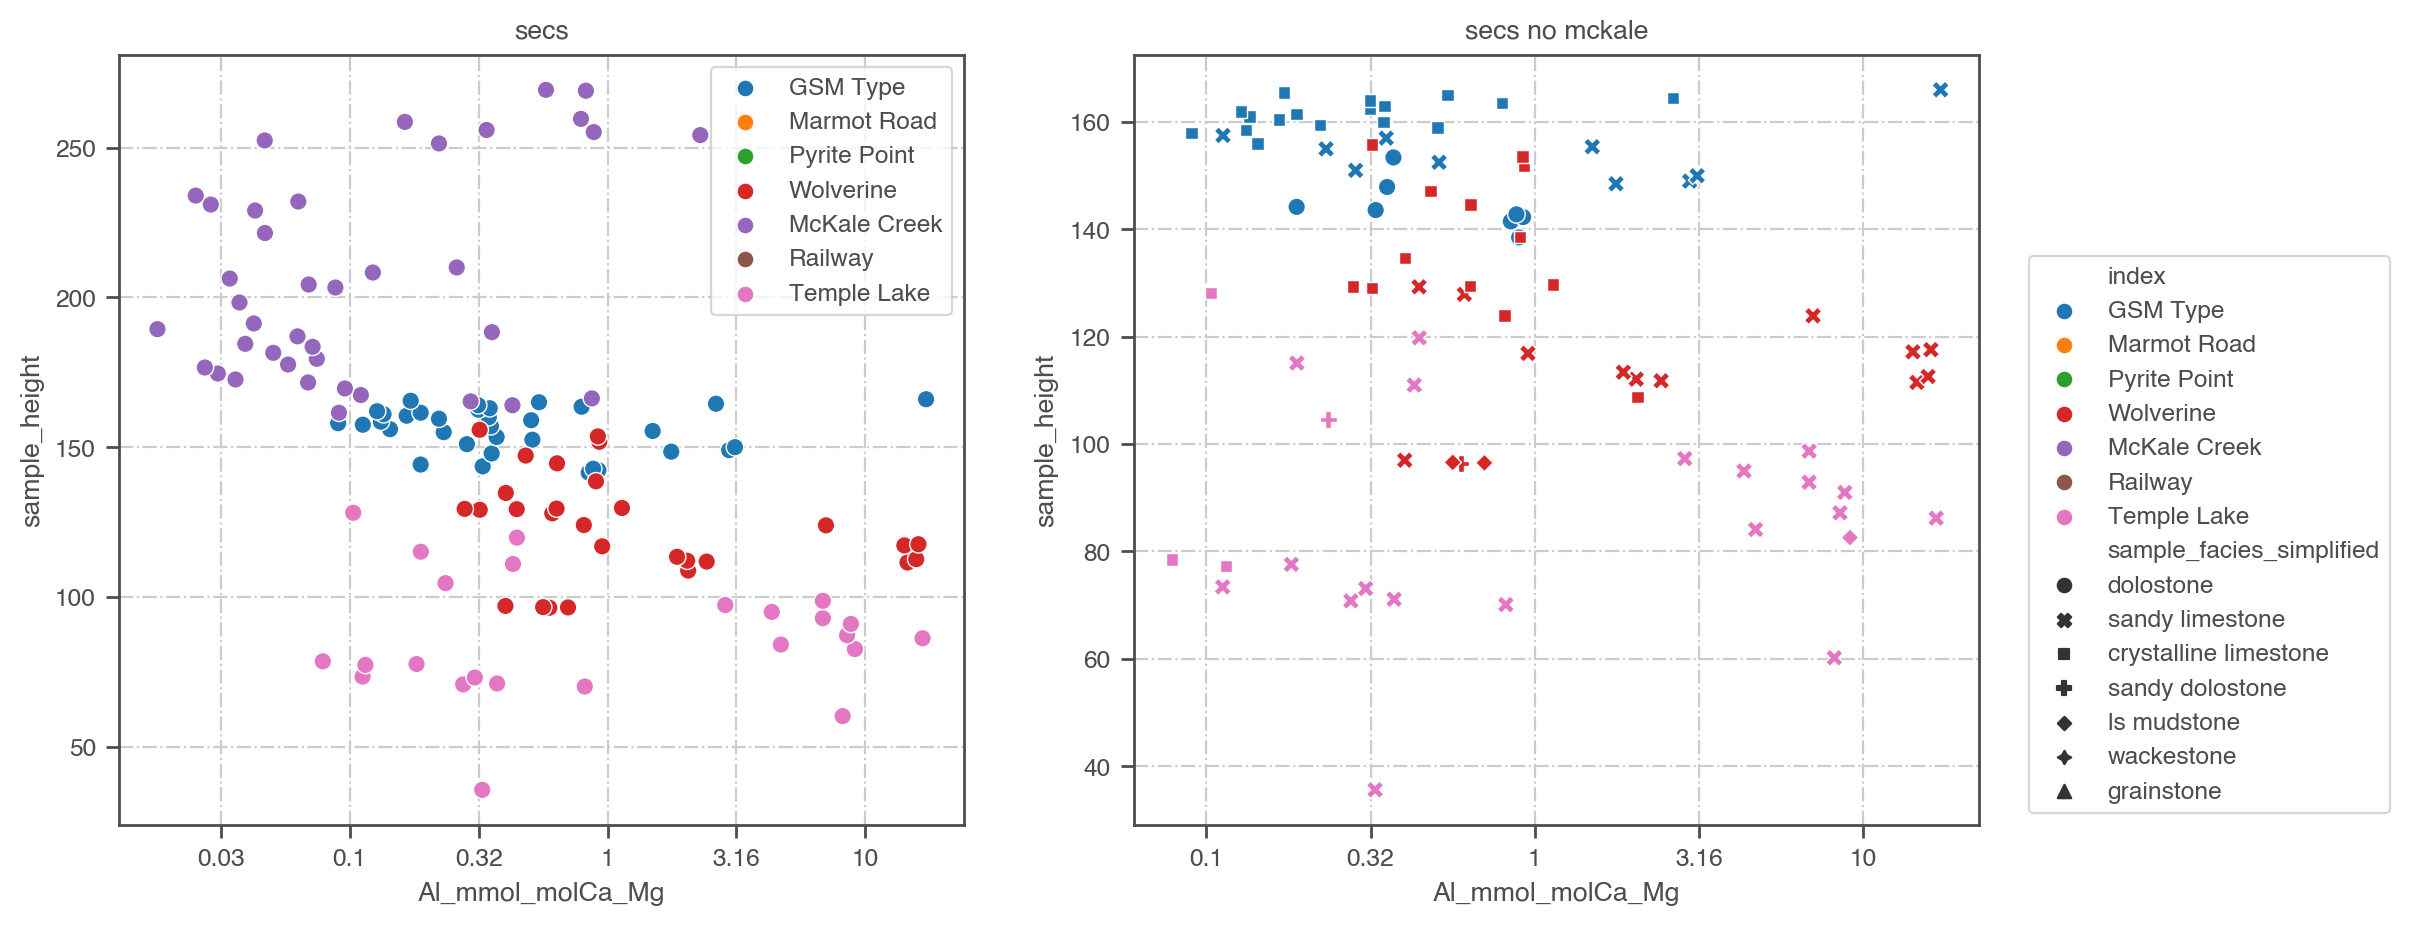

In [55]:
fig,ax = plt.subplots(1,2,figsize=(12,5),sharey=False)

t = 'Al_mmol_molCa_Mg'
b = 'sample_height'
sub = secs[secs['index']!='McKale Creek']
#sns.scatterplot(x=np.log10(comb[t]),y=comb[b],hue=comb['index'],s=40,ax=ax[0])

sns.scatterplot(x=np.log10(secs[t]),y=secs[b],hue=secs['index'],s=40,ax=ax[0])
sns.scatterplot(x=np.log10(sub[t]),y=sub[b],hue=secs['index'],s=40,ax=ax[1],style=secs['sample_facies_simplified'])

ticks_x = FuncFormatter(lambda x, pos: '{0:g}'.format(round(10**x,2)))
ax[0].xaxis.set_major_formatter(ticks_x)
ax[0].legend()
ax[0].grid()
ax[1].xaxis.set_major_formatter(ticks_x)
ax[1].legend(loc=4,bbox_to_anchor=(1.5,0))
ax[1].grid()
ax[0].set_title('secs')
ax[1].set_title('secs no mckale')
max(secs[t])

In [56]:
def trplot(df,xt,yt,zt,ax=None,logx=True,logy=True,logz=False,cmap='coolwarm',clip_on=False,style=None,**kwargs):
    ax0 = plt.gca() if ax==None else ax[0]
    x = np.log10(df[xt]) if logx else df[xt]
    y = np.log10(df[yt]) if logy else df[yt]
    z = np.log10(df[zt]) if logz else df[zt]
    style = df[style]
    s = ax0.scatter(x=x,y=y,s=100,edgecolor='.3',clip_on=False,c=z,cmap=cmap,zorder=1000,**kwargs)
    if len(ax)>1:
        sns.scatterplot(x=x,y=y,s=100,edgecolor='.3',ax=ax[1],clip_on=False,zorder=1000,style=style,facecolor='none')
    for a in ax:
        a.grid()
        a.set_xlim(min(x),max(x))
        a.set_xticks(np.linspace(min(x),max(x),6))
        a.set_ylim(min(y),max(y))
        a.set_yticks(np.linspace(min(y),max(y),6))
        if yt=='d13c_carb':
            a.set_ylabel('$\delta^{13}$C (‰)')
        else:  
            a.set_ylabel('log$_{10}$ '+yt.split('_')[0]+'/Ca')
        a.set_xlabel('log$_{10}$ '+xt.split('_')[0]+'/Ca')
        ticks = FuncFormatter(lambda x, pos: '{0:g}'.format(round(10**x,2)))
        if logx:
            a.xaxis.set_major_formatter(ticks)
    if logy:
            a.yaxis.set_major_formatter(ticks)
    fmt = ticks if logz else None
    cax = plt.colorbar(s,format=fmt,label='log$_{10}$ '+zt.split('_')[0]+'/Ca')
    cax.set_ticks(np.linspace(min(z),max(z),6)) # 21 to guarantee 20 is included.


# Higgins and Blattler Data

In [57]:
clr = pd.read_excel('/Users/cvanwieren/Library/CloudStorage/Dropbox/GitHub/OFP/OFP/data/Trace/examples/blattler/blattler2015.xlsx')
#ahm = pd.read_excel('/Users/cvanwieren/Library/CloudStorage/Dropbox/GitHub/OFP/OFP/data/Trace/examples/ahm/ahm2018.xls').iloc[1:].dropna(subset=['d13C','Mn/Ca'])
hig = pd.read_csv('/Users/cvanwieren/Library/CloudStorage/Dropbox/GitHub/OFP/OFP/data/Trace/examples/higgins/higgins_comp_C_O_trace.csv')
hig['Mn_mmol_molCa'] = hig['Mn_umol_molCa']/1000
hig = hig[(hig['Sr_mmol_molCa']<30)&(hig['Sr_mmol_molCa']>=0)] # one weird one that higgins did not include in his 2018 manuscript so removing here
hig = hig[(hig['Mn_mmol_molCa']>=0)]

/Users/cvanwieren/anaconda3/envs/connor/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [58]:
clr.columns

Index(['sample name', 'depth     (ft)', 'depth    (m)', 'soluble fraction***',
       'δ13C vPDB*', 'δ18O vPDB*', 'δ26Mg        (‰ vs DSM-3)',
       'δ25Mg        (‰ vs DSM-3)', 'δ44/40Ca   (‰ vs SW)',
       'method of Ca isotope separation**', 'Unnamed: 10', 'Al/Ca (μmol/mol)',
       'Cd/Ca (μmol/mol)', 'Fe/Ca (μmol/mol)', 'Li/Ca (μmol/mol)',
       'Mg/Ca (mmol/mol)', 'Mn/Ca (mmol/mol)', 'K/Ca (μmol/mol)',
       'Na/Ca (mmol/mol)', 'Sr/Ca (mmol/mol)', 'U/Ca (μmol/mol)',
       'V/Ca (μmol/mol)'],
      dtype='object')

In [59]:
# rename clara columns
clr = clr.rename(columns={'δ13C vPDB*':'d13c_carb','δ18O vPDB*':'d18o_carb','Sr/Ca (mmol/mol)':'Sr_mmol_molCa','Mn/Ca (mmol/mol)':'Mn_mmol_molCa',
                             'Mg/Ca (mmol/mol)':'Mg_mmol_molCa','U/Ca (μmol/mol)':'U_umol_molCa'})

In [60]:
clr.columns

Index(['sample name', 'depth     (ft)', 'depth    (m)', 'soluble fraction***',
       'd13c_carb', 'd18o_carb', 'δ26Mg        (‰ vs DSM-3)',
       'δ25Mg        (‰ vs DSM-3)', 'δ44/40Ca   (‰ vs SW)',
       'method of Ca isotope separation**', 'Unnamed: 10', 'Al/Ca (μmol/mol)',
       'Cd/Ca (μmol/mol)', 'Fe/Ca (μmol/mol)', 'Li/Ca (μmol/mol)',
       'Mg_mmol_molCa', 'Mn_mmol_molCa', 'K/Ca (μmol/mol)', 'Na/Ca (mmol/mol)',
       'Sr_mmol_molCa', 'U_umol_molCa', 'V/Ca (μmol/mol)'],
      dtype='object')

## Convert Higgins, Blattler, and Wonoka to X/Ca+Mg

### Higgins

In [61]:
# hig.head()

In [62]:
# higgins
targs_hig = hig.columns[hig.columns.str.contains('mol')]

for i in targs_hig:
    new_col_h = i+'_Mg'
    hig[new_col_h] = mgca(hig[i],hig['Mg_mmol_molCa'],df_ca=None,out_ca=False)

### Blättler

In [63]:
# clr.columns

In [64]:
# clara
targs_cl = clr.columns[clr.columns.str.contains('mol')]

for i in targs_cl:
    new_col_clr = i+'_Mg'
    clr[new_col_clr] = mgca(clr[i],clr['Mg_mmol_molCa'],df_ca=None,out_ca=False)

### Wonoka

In [65]:
# jon2.head()

In [66]:
# clara
targs_w = jon2.columns[jon2.columns.str.contains('mol')]

for i in targs_w:
    new_col_w = i+'_Mg'
    jon2[new_col_w] = mgca(jon2[i],jon2['Mg_mmol_molCa'],df_ca=None,out_ca=False)

In [67]:
# jon2.head()

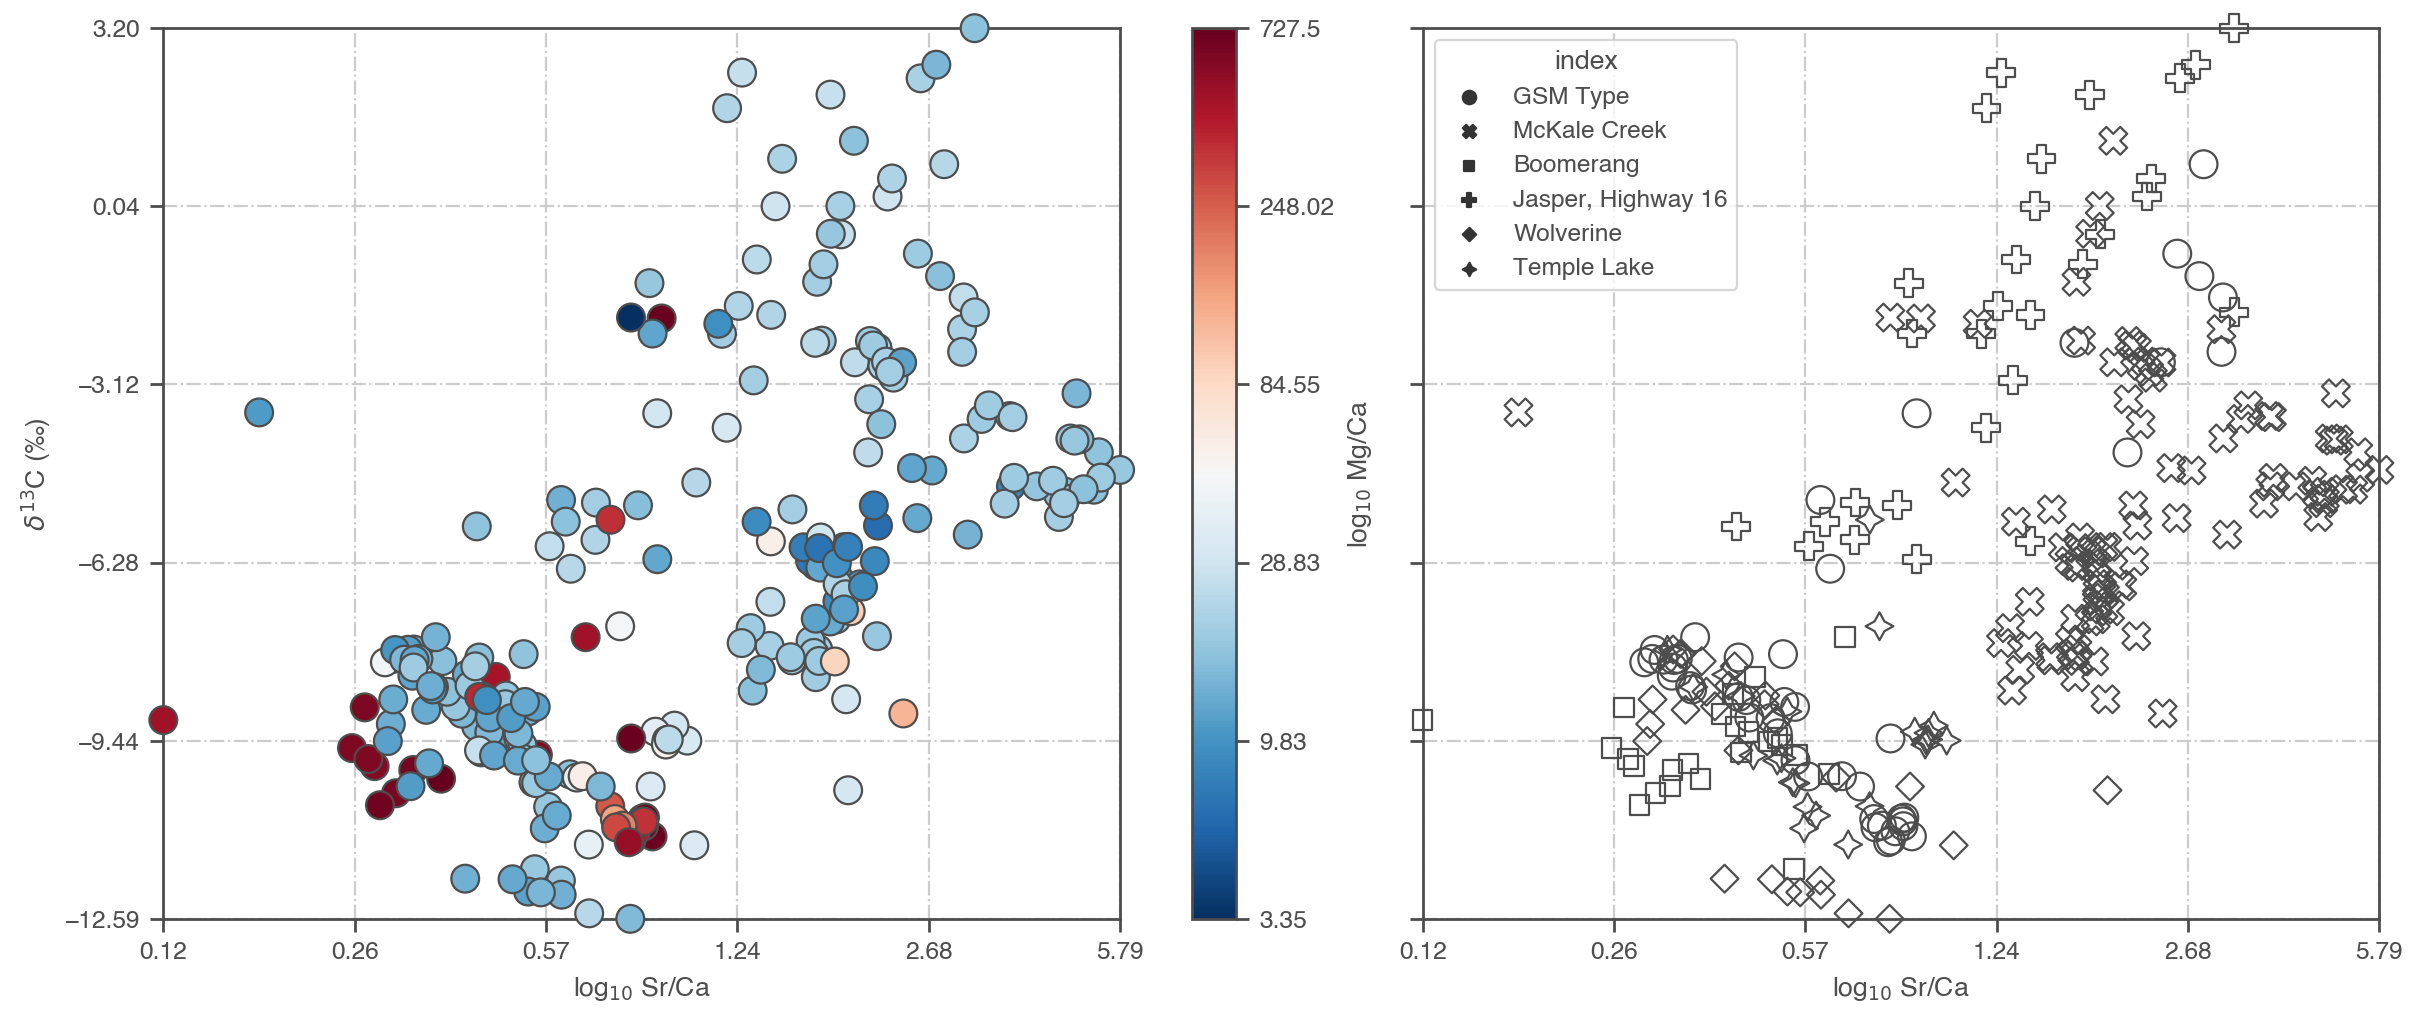

In [68]:
sns.set_context('paper')
tlm = secs[secs['index']!='McKale Creek']
wmm = secs[secs['index']=='McKale Creek']
fig,ax = plt.subplots(1,2,figsize=(12,5),width_ratios=(1,1),layout='constrained',sharey=True)
trplot(df=comb,yt='d13c_carb',xt='Sr_mmol_molCa',zt='Mg_mmol_molCa',ax=[ax[0],ax[1]],logy=False,logz=True,cmap='RdBu_r',style='index')


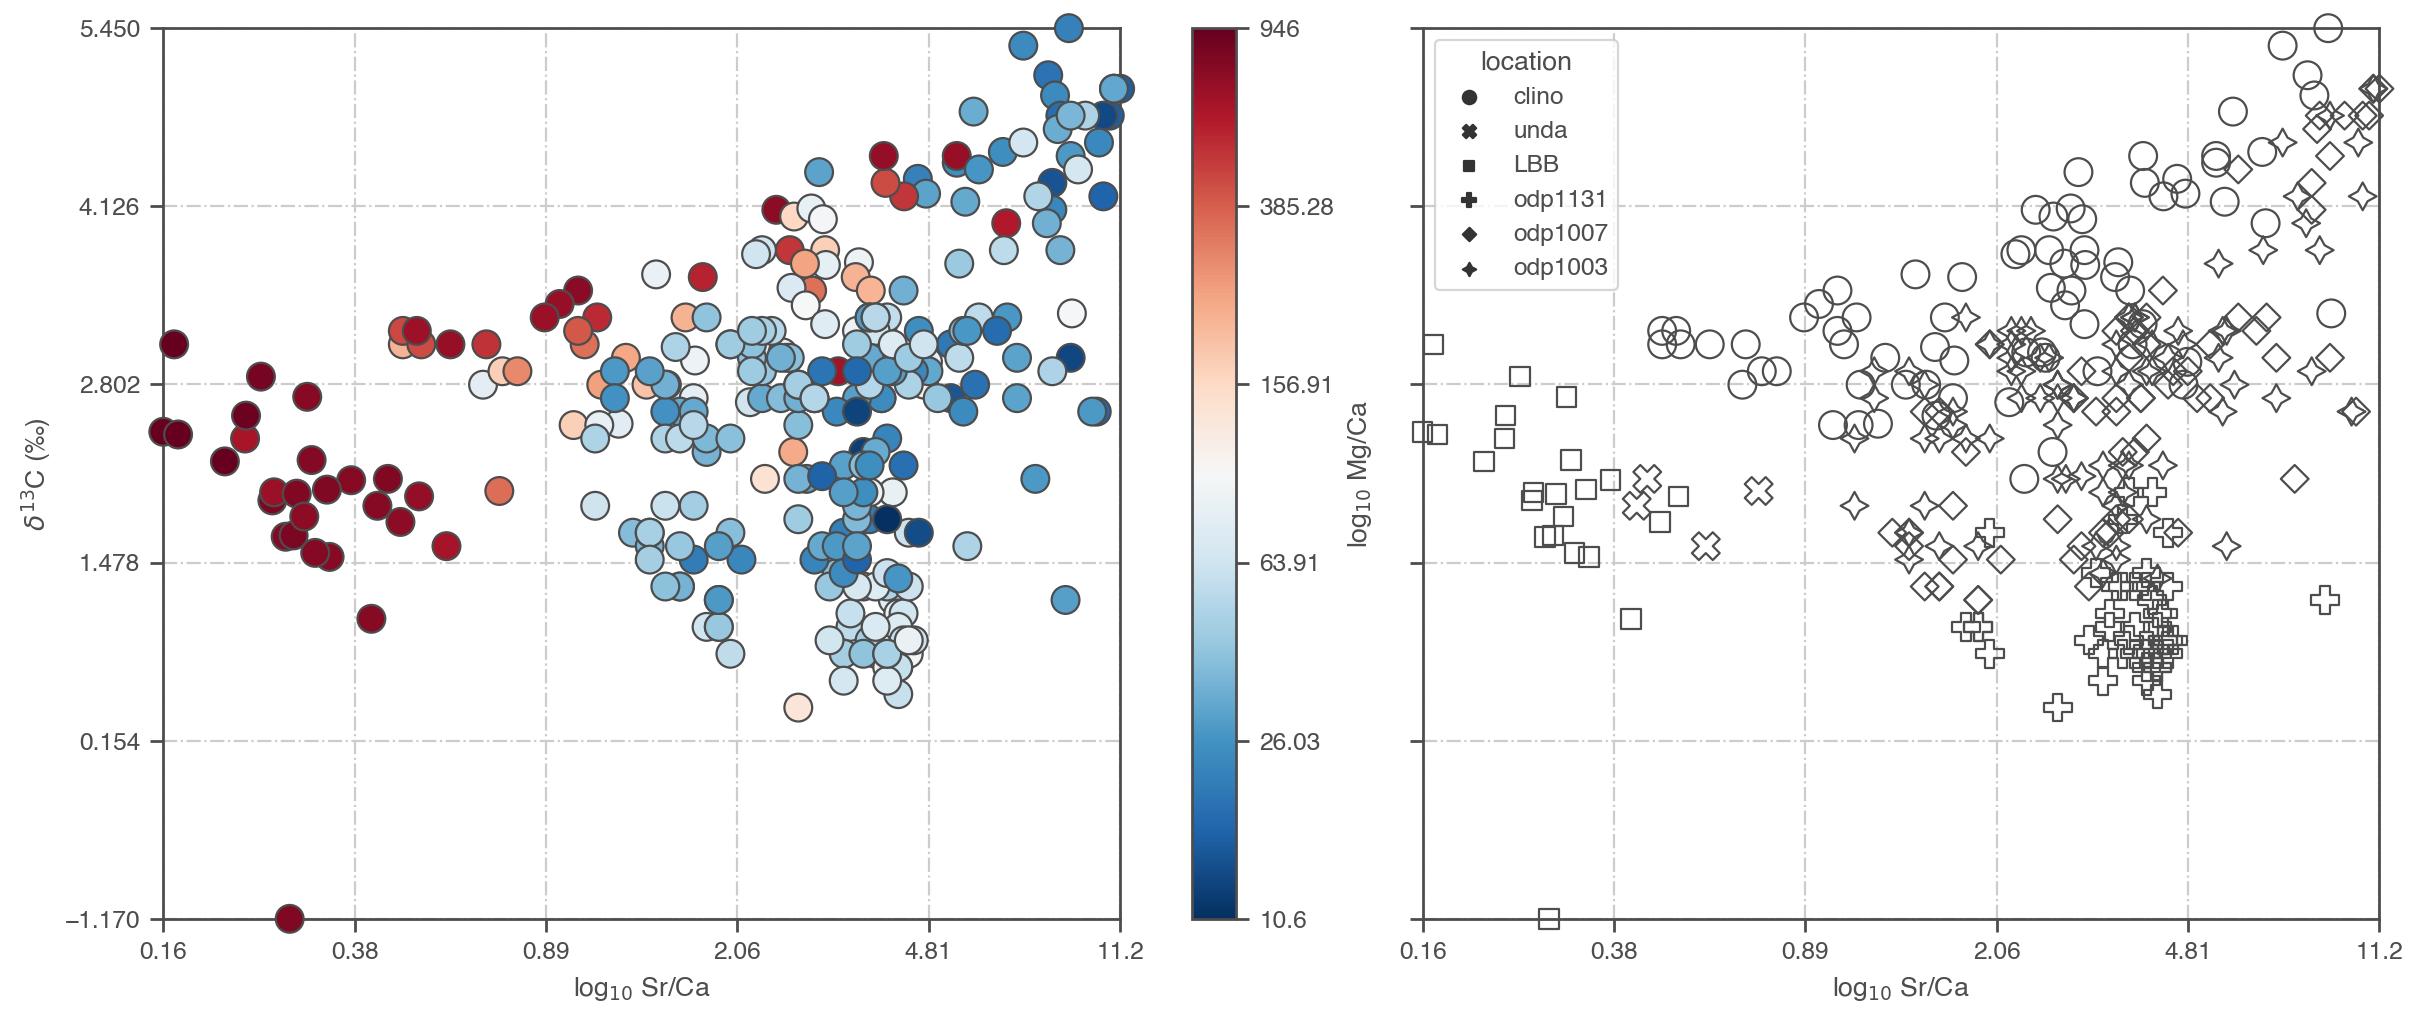

In [69]:
fig,ax = plt.subplots(1,2,figsize=(12,5),width_ratios=(1,1),layout='constrained',sharey=True)
trplot(df=hig,yt='d13c_carb',xt='Sr_mmol_molCa',zt='Mg_mmol_molCa',ax=[ax[0],ax[1]],logy=False,logz=True,cmap='RdBu_r',style='location')

In [70]:
def scat(df,ax,xt,yt,zt,logx=True,logy=True,logz=False,vdfs=[comb,hig],vmin=None,vmax=None,**kwargs):
    totz = pd.concat(vdfs)
    x = np.log10(df[xt]) if logx else df[xt]
    y = np.log10(df[yt]) if logy else df[yt]
    z = np.log10(df[zt]) if logz else df[zt]
    tz = np.log10(totz[zt]) if logz else totz[zt]
    
    vmin = min(tz) if not vmin else vmin
    vmax = max(tz) if not vmax else vmax
    s = ax.scatter(x=x,y=y,c=z,vmin=vmin,vmax=vmax,**kwargs)
    return s


In [71]:
# #sns.set_context('paper')
# fig,ax = plt.subplots(figsize=(6.5,5))
# x = 'Mn_mmol_molCa'
# y = 'Sr_mmol_molCa'
# z = 'd13c_carb'
# s = scat(df=jon2,ax=ax,xt=x,yt=y,zt=z,vdfs=vd,logz=False,s=60,cmap='RdBu_r',edgecolor='.3',marker='^',label='WMM')
# ticks = FuncFormatter(lambda x, pos: '{0:g}'.format(round(10**x,2)))
# ax.xaxis.set_major_formatter(ticks)
# ax.yaxis.set_major_formatter(ticks)
# ax.set_xlabel('Mn/Ca (mmol/mol)')
# ax.set_ylabel('Sr/Ca (mmol/mol)')
# cax = plt.colorbar(s,label=clab)
# ax.grid()
# ax.set_title('wonoka')


## Figure with bahamas and Wonoka data

In [72]:
# fig,ax = plt.subplots(figsize=(6.5,5))
# ax.grid()
# x = 'Mn_mmol_molCa'
# y = 'Sr_mmol_molCa'
# z = 'Mg_mmol_molCa'
# lz= True
# hig1 = hig[hig['location']!='LBB']
# vd = [tlm_secs,wmm_secs]
# ax.scatter(x=np.log10(hig1[x]),y=np.log10(hig1[y]),color='lightgrey',edgecolor='none',s=40,label='Bahamas',marker='o')
# ax.scatter(x=np.log10(clr[x]),y=np.log10(clr[y]),color='lightgrey',edgecolor='none',marker='v',s=60,label='Monterey')
# ax.scatter(x=np.log10(jon2[x]),y=np.log10(jon2[y]),color='lightgrey',edgecolor='.3',s=40,label='Wonoka',marker='.')

# #s = scat(df=clasts,ax=ax,xt=x,yt=y,zt=z,vdfs=vd,logz=False,s=60,cmap='RdBu_r',edgecolor='.3',marker='v',label='clasts',alpha=0.8)
# s = scat(df=wmm_secs,ax=ax,xt=x,yt=y,zt=z,vdfs=vd,logz=lz,s=60,cmap='RdBu_r',edgecolor='.3',marker='^',label='WMM')
# s = scat(df=tlm_secs,ax=ax,xt=x,yt=y,zt=z,vdfs=vd,logz=lz,s=60,cmap='RdBu_r',edgecolor='.3',marker='o',label='TLM')
# ticks = FuncFormatter(lambda x, pos: '{0:g}'.format(round(10**x,2)))
# ax.xaxis.set_major_formatter(ticks)
# ax.yaxis.set_major_formatter(ticks)
# clab = 'Mg/Ca (mmol/mol)'
# if lz == False:
#     cax = plt.colorbar(s,label=clab,pad=0)
# else:
#     cax = plt.colorbar(s,format=ticks,label=clab,pad=0.03)
# ax.set_xlabel('Mn/Ca (mmol/mol)')
# ax.set_ylabel('Sr/Ca (mmol/mol)')
# leg = ax.legend(loc=3,borderaxespad=1)
# frame = leg.get_frame()
# frame.set_edgecolor('.3')
# frame.set_linewidth(.75)
# frame.set_boxstyle('square')

# # label environments
# ax.text(0.15,0.925,'platform\naragonite',transform=ax.transAxes,va='center',ha='center',fontsize=12)#,bbox=dict(facecolor='none',edgecolor='.3',boxstyle='square,pad=0.5'))
# ax.text(0.6,0.9,'sediment\nbuffered',transform=ax.transAxes,va='center',ha='center',fontsize=12)#,bbox=dict(facecolor='none',edgecolor='.3',boxstyle='square,pad=0.5'))
# ax.text(0.85,0.075,'fluid\nbuffered',transform=ax.transAxes,va='center',ha='center',fontsize=12)#,bbox=dict(facecolor='none',edgecolor='.3',boxstyle='square,pad=0.5'))

# # clean up ticks
# #cax.set_ticks([np.log10(i) for i in [3,10,30,90,250,800]])
# ax.set_yticks([np.log10(i) for i in [0.1,0.3,1,3,10]])

# # save fig 
# fig.savefig(fig_dir+'srmn.pdf',format='pdf',bbox_inches='tight',transparent=True)

# For Figures 9 and 11 converting from $\dfrac{X}{Ca}$ to $\dfrac{X}{Ca+Mg}$ (see function at start of notebook)

## Fig 9; Bahamas

/Users/cvanwieren/anaconda3/envs/connor/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


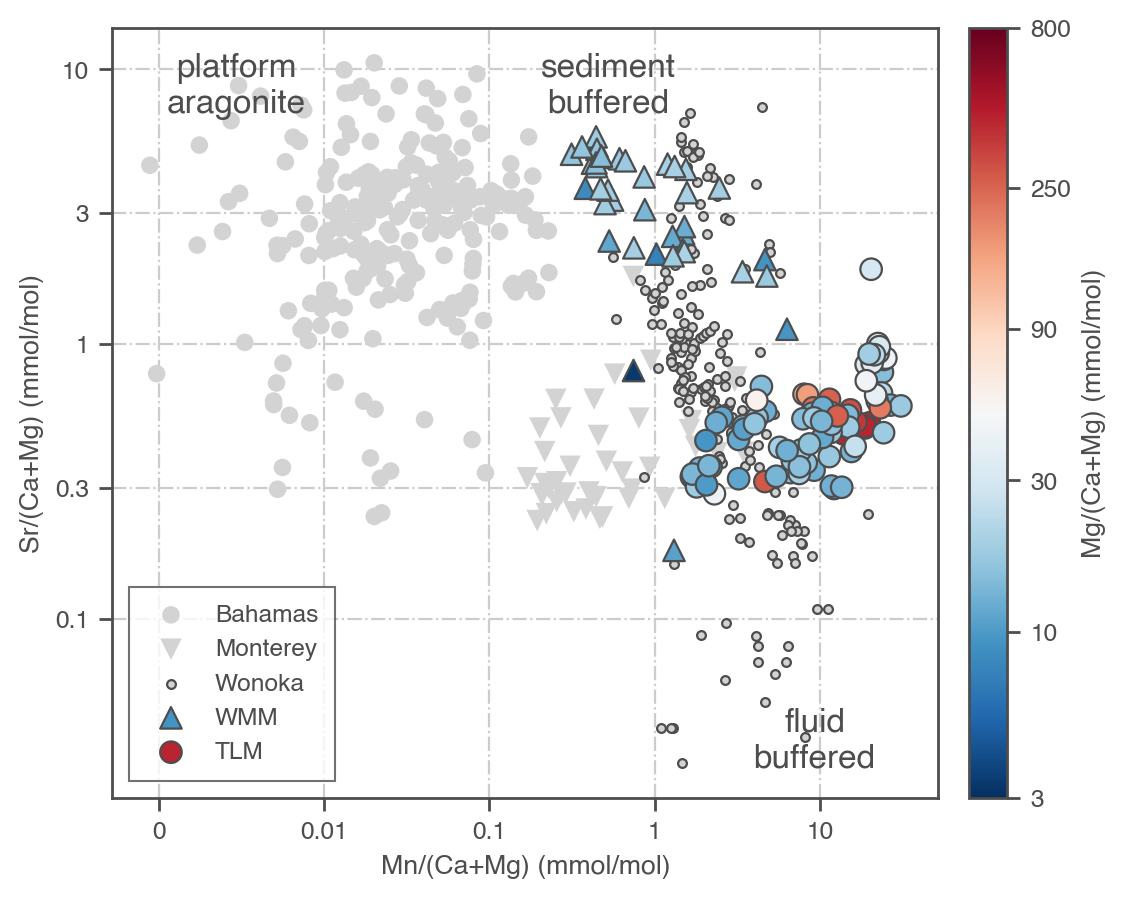

In [104]:
fig,ax = plt.subplots(figsize=(6.5,5))
ax.grid()
x = 'Mn_mmol_molCa_Mg'
y = 'Sr_mmol_molCa_Mg'
z = 'Mg_mmol_molCa_Mg'
lz= True
hig1 = hig[hig['location']!='LBB']
vd = [tlm_secs,wmm_secs]
ax.scatter(x=np.log10(hig1[x]),y=np.log10(hig1[y]),color='lightgrey',edgecolor='none',s=40,label='Bahamas',marker='o')
ax.scatter(x=np.log10(clr[x]),y=np.log10(clr[y]),color='lightgrey',edgecolor='none',marker='v',s=60,label='Monterey')
ax.scatter(x=np.log10(jon2[x]),y=np.log10(jon2[y]),color='lightgrey',edgecolor='.3',s=40,label='Wonoka',marker='.')

#s = scat(df=clasts,ax=ax,xt=x,yt=y,zt=z,vdfs=vd,logz=False,s=60,cmap='RdBu_r',edgecolor='.3',marker='v',label='clasts',alpha=0.8)
s = scat(df=wmm_secs,ax=ax,xt=x,yt=y,zt=z,vdfs=vd,logz=lz,s=60,cmap='RdBu_r',edgecolor='.3',marker='^',label='WMM',vmin=np.log10(3),vmax=np.log10(800))
s = scat(df=tlm_secs,ax=ax,xt=x,yt=y,zt=z,vdfs=vd,logz=lz,s=60,cmap='RdBu_r',edgecolor='.3',marker='o',label='TLM',vmin=np.log10(3),vmax=np.log10(800))
ticks = FuncFormatter(lambda x, pos: '{0:g}'.format(round(10**x,2)))
ax.xaxis.set_major_formatter(ticks)
ax.yaxis.set_major_formatter(ticks)
clab = 'Mg/(Ca+Mg) (mmol/mol)'
if lz == False:
    cax = plt.colorbar(s,label=clab,pad=0)
else:
    cax = plt.colorbar(s,format=ticks,label=clab,pad=0.03)

ax.set_xlabel('Mn/(Ca+Mg) (mmol/mol)')
ax.set_ylabel('Sr/(Ca+Mg) (mmol/mol)')
leg = ax.legend(loc=3,borderaxespad=1)
frame = leg.get_frame()
frame.set_edgecolor('.3')
frame.set_linewidth(.75)
frame.set_boxstyle('square')

# label environments
ax.text(0.15,0.925,'platform\naragonite',transform=ax.transAxes,va='center',ha='center',fontsize=12)#,bbox=dict(facecolor='none',edgecolor='.3',boxstyle='square,pad=0.5'))
ax.text(0.6,0.925,'sediment\nbuffered',transform=ax.transAxes,va='center',ha='center',fontsize=12)#,bbox=dict(facecolor='none',edgecolor='.3',boxstyle='square,pad=0.5'))
ax.text(0.85,0.075,'fluid\nbuffered',transform=ax.transAxes,va='center',ha='center',fontsize=12)#,bbox=dict(facecolor='none',edgecolor='.3',boxstyle='square,pad=0.5'))

# # adding rectangles for the environments to make more clear
# ar = Rectangle((np.log10(1e-3),np.log10(10)),np.log10(2),np.log10(2),zorder=0,alpha=0.25)
# ax.add_patch(ar)

# clean up ticks
cax.set_ticks([np.log10(i) for i in [3,10,30,90,250,800]])
ax.set_yticks([np.log10(i) for i in [0.1,0.3,1,3,10]])

# save fig 
fig.savefig(fig_dir+'srmn_mgca.pdf',format='pdf',bbox_inches='tight',transparent=True)

In [74]:
# fig,ax = plt.subplots(figsize=(6.5,5))
# ax.grid()
# x = 'Mn_mmol_molCa'
# y = 'Sr_mmol_molCa'
# z = 'd13c_carb'
# lz= False
# hig1 = hig[hig['location']!='LBB']
# vd = [tlm_secs,wmm_secs]
# ax.scatter(x=np.log10(hig1[x]),y=np.log10(hig1[y]),color='lightgrey',edgecolor='none',s=40,label='Bahamas',marker='o')
# ax.scatter(x=np.log10(clr['Mn/Ca (mmol/mol)']),y=np.log10(clr['Sr/Ca (mmol/mol)']),color='lightgrey',edgecolor='none',marker='v',s=60,label='Monterey')
# # ax.scatter(x=np.log10(jon2[x]),y=np.log10(jon2[y]),color='lightgrey',edgecolor='.3',s=40,label='Wonoka',marker='.')

# #s = scat(df=clasts,ax=ax,xt=x,yt=y,zt=z,vdfs=vd,logz=lz,s=60,cmap='RdBu_r',edgecolor='.3',marker='v',label='clasts',alpha=0.8)
# s = scat(df=jon2,ax=ax,xt=x,yt=y,zt=z,vdfs=vd,logz=lz,s=60,cmap='RdBu_r',edgecolor='.3',marker='s',label='Wonoka')
# #s = scat(df=wmm_secs,ax=ax,xt=x,yt=y,zt=z,vdfs=vd,logz=lz,s=60,cmap='RdBu_r',edgecolor='.3',marker='^',label='WMM')
# #s = scat(df=tlm_secs,ax=ax,xt=x,yt=y,zt=z,vdfs=vd,logz=lz,s=60,cmap='RdBu_r',edgecolor='.3',marker='o',label='TLM')

# ticks = FuncFormatter(lambda x, pos: '{0:g}'.format(round(10**x,2)))
# ax.xaxis.set_major_formatter(ticks)
# ax.yaxis.set_major_formatter(ticks)
# clab = 'Mg/Ca (mmol/mol)'
# if lz == False:
#     cax = plt.colorbar(s,label=clab,pad=0)
# else:
#     cax = plt.colorbar(s,format=ticks,label=clab,pad=0.03)
# ax.set_xlabel('Mn/Ca (mmol/mol)')
# ax.set_ylabel('Sr/Ca (mmol/mol)')
# leg = ax.legend(loc=3,borderaxespad=1)
# frame = leg.get_frame()
# frame.set_edgecolor('.3')
# frame.set_linewidth(.75)
# frame.set_boxstyle('square')

# # label environments
# ax.text(0.15,0.925,'platform\naragonite',transform=ax.transAxes,va='center',ha='center',fontsize=12)#,bbox=dict(facecolor='none',edgecolor='.3',boxstyle='square,pad=0.5'))
# ax.text(0.6,0.9,'sediment\nbuffered',transform=ax.transAxes,va='center',ha='center',fontsize=12)#,bbox=dict(facecolor='none',edgecolor='.3',boxstyle='square,pad=0.5'))
# ax.text(0.85,0.075,'fluid\nbuffered',transform=ax.transAxes,va='center',ha='center',fontsize=12)#,bbox=dict(facecolor='none',edgecolor='.3',boxstyle='square,pad=0.5'))

# # save fig
# #fig.savefig(fig_dir+'srmn.pdf',format='pdf',bbox_inches='tight',transparent=True)

## Comparing Mg/Ca ratios of Bahamas, Monterey Fm., and OFP

[]

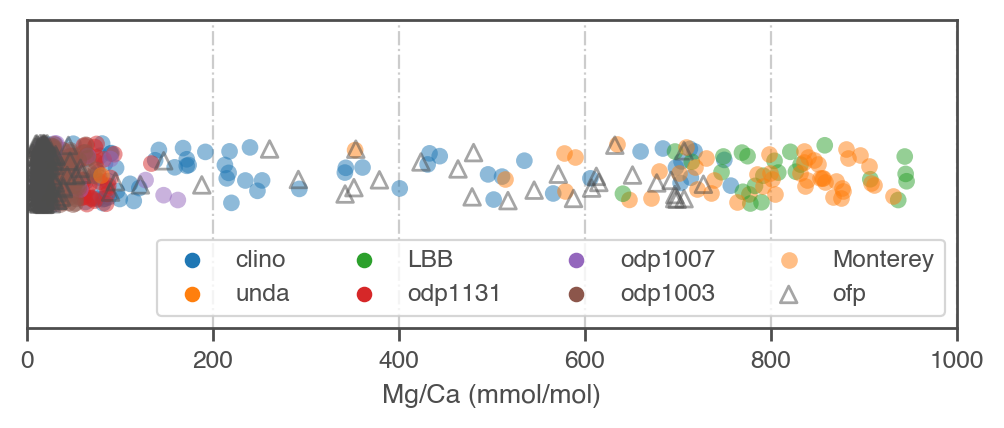

In [75]:
fig,ax = plt.subplots(1,1,figsize=(6,2))

sns.stripplot(x=hig['Mg_mmol_molCa'],hue=hig['location'],alpha=0.5,s=6)
sns.stripplot(x=clr['Mg_mmol_molCa'],label='Monterey',alpha=0.5,s=6)
sns.stripplot(x=comb['Mg_mmol_molCa'],label='ofp',alpha=0.5,s=6,facecolor='none',edgecolor='.3',linewidth=1,marker='^')

ax.legend(loc=4,ncols=4)
ax.xaxis.grid()
ax.set_xlim(0,1000)
ax.set_xlabel('Mg/Ca (mmol/mol)')
ax.set_yticks([])


## Trace Figure with Mn/Ca and Sr/Ca and d13C seperated by clasts and sections for more explicit viewing
- 2x2 panel

In [76]:
# fig,ax = plt.subplots(2,2,figsize=(9,7),sharey='row',sharex='col')#,layout='constrained')
# axs = ax.ravel()
# for i in axs:
#     i.grid()
# targs = ['Sr_mmol_molCa','Mn_mmol_molCa']
# xl = ['Sr/Ca (mmol/mol)','Mn/Ca (mmol/mol)']
# z = np.log10(comb['Mg_mmol_molCa'])
# pal = 'RdBu_r'
# ho = ['GSM Type','McKale Creek','Boomerang','Jasper, Highway 16','Wolverine','Temple Lake']
# markers = ['o',(4,0,0),'X',(4,1,0),'P','s']
# s = 70
# ticks = FuncFormatter(lambda x, pos: '{0:g}'.format(round(10**x,2)))
# #hn = (z.min(), z.max())
# hn = (np.log10(3),np.log10(800))
# for a,a1,t,l in zip(axs[:2],axs[2:],targs,xl):
#     sns.scatterplot(x=np.log10(secs[t]),y=secs['d13c_carb'],ax=a,hue=np.log10(secs['Mg_mmol_molCa']),style=secs['index'],style_order=ho,palette=pal,
#                     s=s,edgecolor='.3',legend=True,hue_norm=hn)
#     sns.scatterplot(x=np.log10(clasts[t]),y=clasts['d13c_carb'],ax=a1,hue=np.log10(clasts['Mg_mmol_molCa']),style=clasts['index'],style_order=ho,palette=pal,
#                     s=s,edgecolor='.3',legend=False,hue_norm=hn)
#     a1.set_xlabel(l)
#     a1.set_ylabel('$\delta^{13}$C$_{carb}$ (‰)')
#     a.set_ylabel('$\delta^{13}$C$_{carb}$ (‰)')
#     a.xaxis.set_major_formatter(ticks)
#     if a!=axs[0]:
#         a.legend().remove()
# # format
# h,l = ax[0,0].get_legend_handles_labels()
# leg = ax[0,0].legend(h[8:],l[8:],framealpha=1,loc=1,ncol=1,bbox_to_anchor=(1.315,0.4),fontsize=8)
# ax[0,0].set_zorder(1000)
# frame = leg.get_frame()
# frame.set_edgecolor('.3')
# frame.set_linewidth(.75)
# frame.set_boxstyle('square')
# plt.subplots_adjust(wspace=0.1,hspace=0.1)
# norm = plt.Normalize(hn[0], hn[1])
# sm = plt.cm.ScalarMappable(cmap=pal, norm=norm)
# sm.set_array([])
# cbar = axs[-1].figure.colorbar(sm,ax=ax.ravel(),format=ticks,orientation='vertical',location='right',shrink=1,aspect=30,pad=0.025,label='Mg/Ca (mmol/mol)')
# #cbar.set_ticks(np.linspace(min(z),max(z),6)) 
# cbar.set_ticks([np.log10(i) for i in [3,10,30,90,250,800]]) 

# # label 
# labs = string.ascii_uppercase[:len(axs)]
# for i,l in zip(axs,labs):
#     if l!='D':
#         i.text(0.05,0.87,l,transform=i.transAxes,fontsize=22,zorder=1000)
#     else:
#         i.text(0.85,0.87,l,transform=i.transAxes,fontsize=22,zorder=1000)

# #axs[0].arrow(0.25,0.1,.5,.6,width=0.05,transform=axs[0].transAxes,head_length=0.1,head_width=0.1,zorder=0,facecolor='grey',alpha=0.4,edgecolor='none')
# #axs[1].arrow(0.9,0.1,-.6,.6,width=0.05,transform=axs[1].transAxes,head_length=0.1,head_width=0.1,zorder=0,facecolor='grey',alpha=0.4,edgecolor='none')
# axs[0].text(0.85,0.9,'sediment\nbuffered',transform=axs[0].transAxes,va='center',ha='center',fontsize=12)#,bbox=dict(facecolor='none',edgecolor='.3',boxstyle='square,pad=0.5'))
# axs[0].text(0.15,0.075,'fluid\nbuffered',transform=axs[0].transAxes,va='center',ha='center',fontsize=12)#,bbox=dict(facecolor='none',edgecolor='.3',boxstyle='square,pad=0.5'))
# # axs[1].text(0.85,0.9,'sediment\nbuffered',transform=axs[1].transAxes,va='center',ha='center',fontsize=12)#,bbox=dict(facecolor='none',edgecolor='.3',boxstyle='square,pad=0.5'))
# # axs[1].text(0.15,0.075,'fluid\nbuffered',transform=axs[1].transAxes,va='center',ha='center',fontsize=12)#,bbox=dict(facecolor='none',edgecolor='.3',boxstyle='square,pad=0.5'))

# # adjust ticks for individual elements to match those in the other plot
# axs[0].set_xticks([np.log10(i) for i in [0.1,0.3,1,3,6]])
# axs[1].set_xticks([np.log10(i) for i in [0.3,1,3,10,32]])

# # savefig
# fig.savefig(fig_dir+'mnsrzoom.pdf',format='pdf',bbox_inches='tight',transparent=True)

## Version with clasts and sections labelled and with ratios X/Ca+Mg

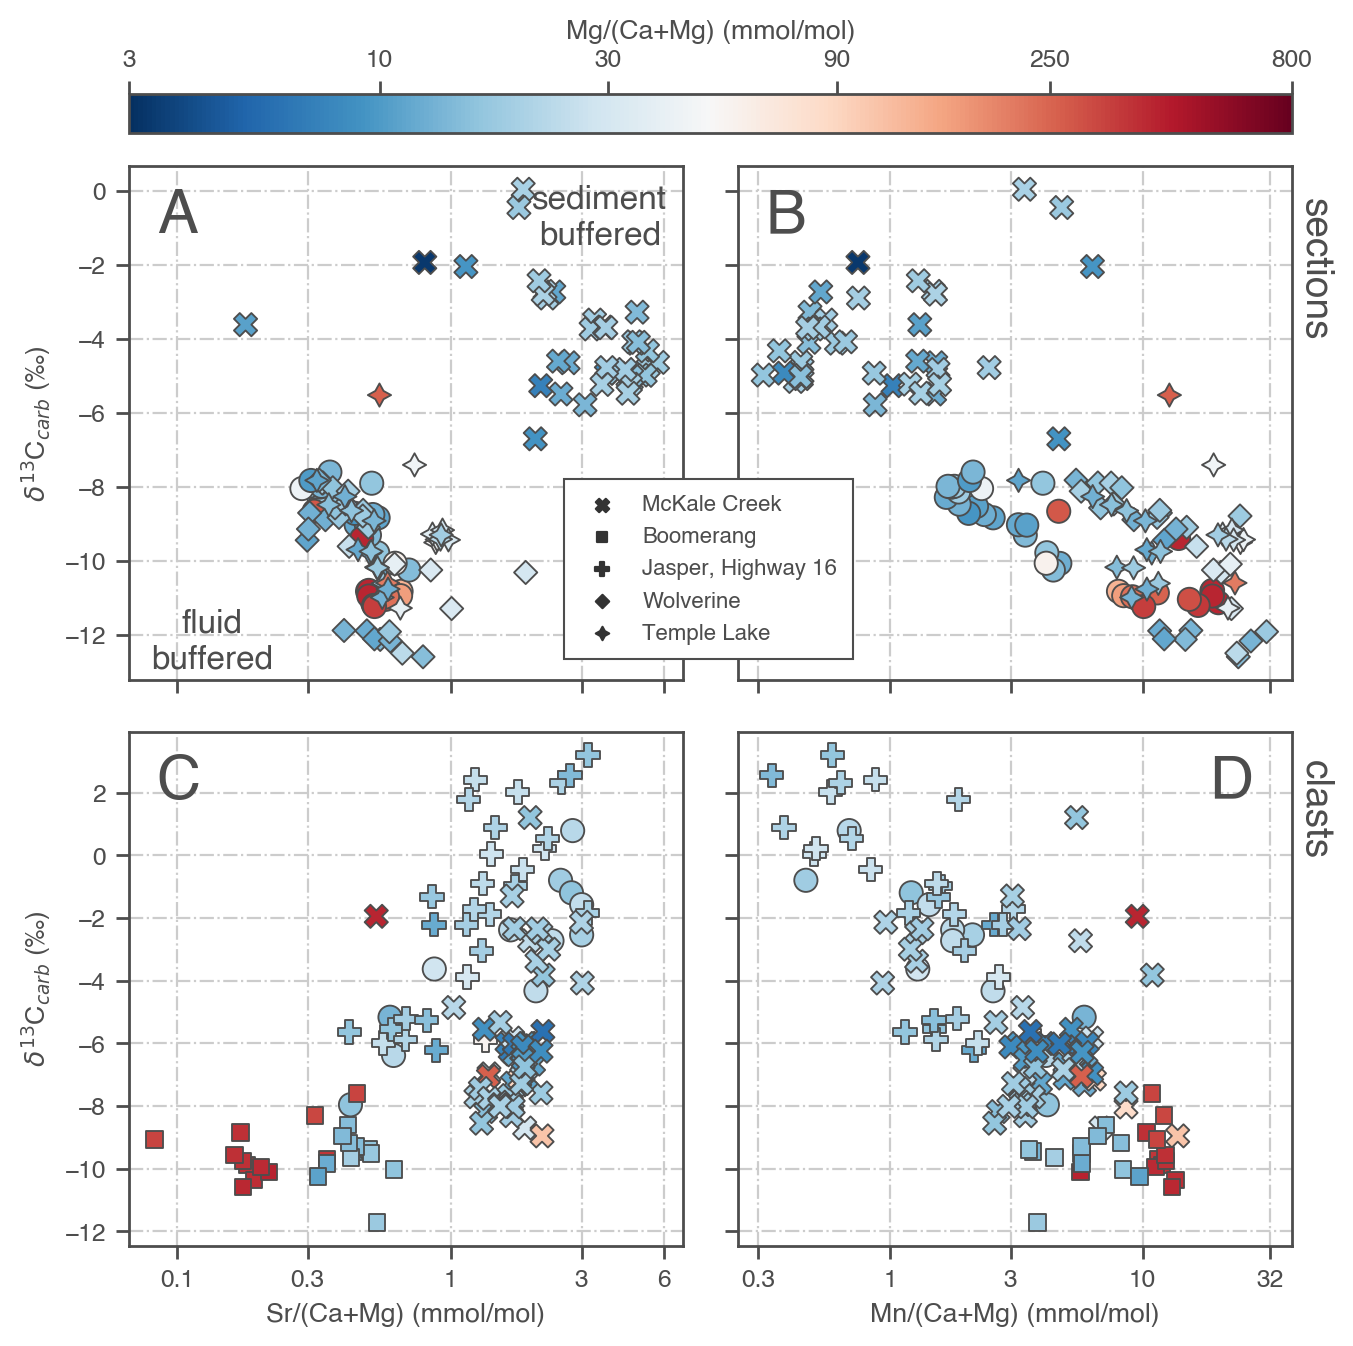

In [77]:
fig,ax = plt.subplots(2,2,figsize=(7.5,8.5),sharey='row',sharex='col')#,layout='constrained')
axs = ax.ravel()
for i in axs:
    i.grid()
targs = ['Sr_mmol_molCa_Mg','Mn_mmol_molCa_Mg']
xl = ['Sr/(Ca+Mg) (mmol/mol)','Mn/(Ca+Mg) (mmol/mol)']
z = np.log10(comb['Mg_mmol_molCa'])
pal = 'RdBu_r'
ho = ['GSM Type','McKale Creek','Boomerang','Jasper, Highway 16','Wolverine','Temple Lake']
markers = ['o',(4,0,0),'X',(4,1,0),'P','s']
s = 70
ticks = FuncFormatter(lambda x, pos: '{0:g}'.format(round(10**x,2)))
#hn = (z.min(), z.max())
hn = (np.log10(3),np.log10(800))
for a,a1,t,l in zip(axs[:2],axs[2:],targs,xl):
    sns.scatterplot(x=np.log10(secs[t]),y=secs['d13c_carb'],ax=a,hue=np.log10(secs['Mg_mmol_molCa_Mg']),style=secs['index'],style_order=ho,palette=pal,
                    s=s,edgecolor='.3',legend=True,hue_norm=hn)
    sns.scatterplot(x=np.log10(clasts[t]),y=clasts['d13c_carb'],ax=a1,hue=np.log10(clasts['Mg_mmol_molCa_Mg']),style=clasts['index'],style_order=ho,palette=pal,
                    s=s,edgecolor='.3',legend=False,hue_norm=hn)
    a1.set_xlabel(l)
    a1.set_ylabel('$\delta^{13}$C$_{carb}$ (‰)')
    a.set_ylabel('$\delta^{13}$C$_{carb}$ (‰)')
    a.xaxis.set_major_formatter(ticks)
    if a!=axs[0]:
        a.legend().remove()
# format
h,l = ax[0,0].get_legend_handles_labels()
leg = ax[0,0].legend(h[8:],l[8:],framealpha=1,loc=1,ncol=1,bbox_to_anchor=(1.315,0.4),fontsize=8)
ax[0,0].set_zorder(1000)
frame = leg.get_frame()
frame.set_edgecolor('.3')
frame.set_linewidth(.75)
frame.set_boxstyle('square')
plt.subplots_adjust(wspace=0.1,hspace=0.1)
norm = plt.Normalize(hn[0], hn[1])
sm = plt.cm.ScalarMappable(cmap=pal, norm=norm)
sm.set_array([])
cbar = axs[-1].figure.colorbar(sm,ax=ax.ravel(),format=ticks,orientation='horizontal',location='top',shrink=1,aspect=30,pad=0.025,label='Mg/(Ca+Mg) (mmol/mol)')
#cbar.set_ticks(np.linspace(min(z),max(z),6)) 
cbar.set_ticks([np.log10(i) for i in [3,10,30,90,250,800]]) 

# label 
labs = string.ascii_uppercase[:len(axs)]
for i,l in zip(axs,labs):
    if l!='D':
        i.text(0.05,0.87,l,transform=i.transAxes,fontsize=22,zorder=1000)
    else:
        i.text(0.85,0.87,l,transform=i.transAxes,fontsize=22,zorder=1000)

#axs[0].arrow(0.25,0.1,.5,.6,width=0.05,transform=axs[0].transAxes,head_length=0.1,head_width=0.1,zorder=0,facecolor='grey',alpha=0.4,edgecolor='none')
#axs[1].arrow(0.9,0.1,-.6,.6,width=0.05,transform=axs[1].transAxes,head_length=0.1,head_width=0.1,zorder=0,facecolor='grey',alpha=0.4,edgecolor='none')
axs[0].text(0.85,0.9,'sediment\nbuffered',transform=axs[0].transAxes,va='center',ha='center',fontsize=12)#,bbox=dict(facecolor='none',edgecolor='.3',boxstyle='square,pad=0.5'))
axs[0].text(0.15,0.075,'fluid\nbuffered',transform=axs[0].transAxes,va='center',ha='center',fontsize=12)#,bbox=dict(facecolor='none',edgecolor='.3',boxstyle='square,pad=0.5'))
# axs[1].text(0.85,0.9,'sediment\nbuffered',transform=axs[1].transAxes,va='center',ha='center',fontsize=12)#,bbox=dict(facecolor='none',edgecolor='.3',boxstyle='square,pad=0.5'))
# axs[1].text(0.15,0.075,'fluid\nbuffered',transform=axs[1].transAxes,va='center',ha='center',fontsize=12)#,bbox=dict(facecolor='none',edgecolor='.3',boxstyle='square,pad=0.5'))

# adjust ticks for individual elements to match those in the other plot
axs[0].set_xticks([np.log10(i) for i in [0.1,0.3,1,3,6]])
axs[1].set_xticks([np.log10(i) for i in [0.3,1,3,10,32]])

# label clasts and sections
axs[1].text(1.01,0.8,'sections',transform=axs[1].transAxes,rotation=270,fontsize=14,weight='bold',va='center')
axs[-1].text(1.01,0.85,'clasts',transform=axs[-1].transAxes,rotation=270,fontsize=14,weight='bold',va='center')

# savefig
fig.savefig(fig_dir+'mnsrzoom_camg.pdf',format='pdf',bbox_inches='tight',transparent=True)

In [78]:
mck = secs[secs['index']=='McKale Creek']
frac = len(mck[mck['Mn_mmol_molCa']<3])/len(mck['Mn_mmol_molCa'].dropna())
print(f'{frac*100:.2f}%')

89.74%


## Oxygen version

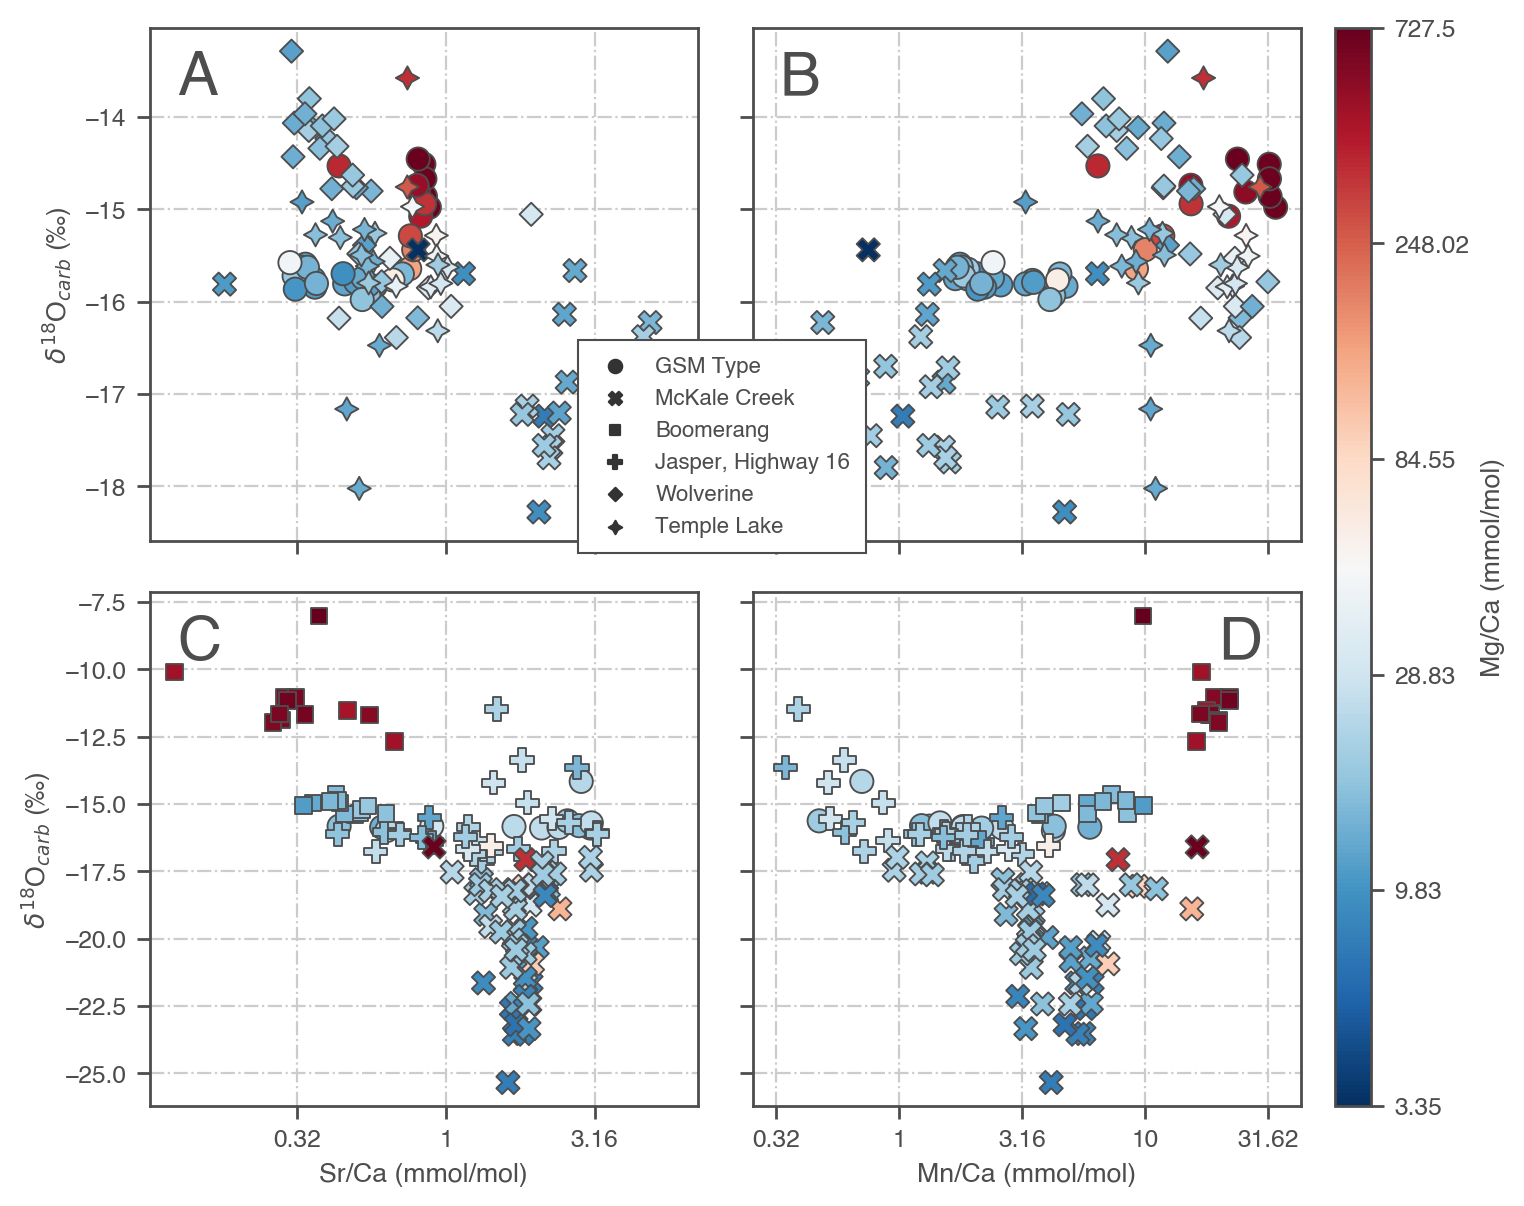

In [79]:
fig,ax = plt.subplots(2,2,figsize=(9,7),sharey='row',sharex='col')#,layout='constrained')
axs = ax.ravel()
for i in axs:
    i.grid()
targs = ['Sr_mmol_molCa','Mn_mmol_molCa']
xl = ['Sr/Ca (mmol/mol)','Mn/Ca (mmol/mol)']
z = np.log10(comb['Mg_mmol_molCa'])
pal = 'RdBu_r'
ho = ['GSM Type','McKale Creek','Boomerang','Jasper, Highway 16','Wolverine','Temple Lake']
markers = ['o',(4,0,0),'X',(4,1,0),'P','s']
s = 70
ticks = FuncFormatter(lambda x, pos: '{0:g}'.format(round(10**x,2)))
for a,a1,t,l in zip(axs[:2],axs[2:],targs,xl):
    sns.scatterplot(x=np.log10(secs[t]),y=secs['d18o_carb'],ax=a,hue=np.log10(secs['Mg_mmol_molCa']),style=secs['index'],style_order=ho,palette=pal,
                    s=s,edgecolor='.3',legend=True,hue_norm=(z.min(), z.max()))
    sns.scatterplot(x=np.log10(clasts[t]),y=clasts['d18o_carb'],ax=a1,hue=np.log10(clasts['Mg_mmol_molCa']),style=clasts['index'],style_order=ho,palette=pal,
                    s=s,edgecolor='.3',legend=False,hue_norm=(z.min(), z.max()))
    a1.set_xlabel(l)
    a1.set_ylabel('$\delta^{18}$O$_{carb}$ (‰)')
    a.set_ylabel('$\delta^{18}$O$_{carb}$ (‰)')
    a.xaxis.set_major_formatter(ticks)
    if a!=axs[0]:
        a.legend().remove()
# format
h,l = ax[0,0].get_legend_handles_labels()
leg = ax[0,0].legend(h[8:],l[8:],framealpha=1,loc=1,ncol=1,bbox_to_anchor=(1.315,0.4),fontsize=8)
ax[0,0].set_zorder(1000)
frame = leg.get_frame()
frame.set_edgecolor('.3')
frame.set_linewidth(.75)
frame.set_boxstyle('square')
plt.subplots_adjust(wspace=0.1,hspace=0.1)
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap=pal, norm=norm)
sm.set_array([])
cbar = axs[-1].figure.colorbar(sm,ax=ax.ravel(),format=ticks,orientation='vertical',location='right',shrink=1,aspect=30,pad=0.025,label='Mg/Ca (mmol/mol)')
cbar.set_ticks(np.linspace(min(z),max(z),6)) 

# label 
labs = string.ascii_uppercase[:len(axs)]
for i,l in zip(axs,labs):
    if l!='D':
        i.text(0.05,0.87,l,transform=i.transAxes,fontsize=22,zorder=1000)
    else:
        i.text(0.85,0.87,l,transform=i.transAxes,fontsize=22,zorder=1000) 

#axs[0].arrow(0.25,0.1,.5,.6,width=0.05,transform=axs[0].transAxes,head_length=0.1,head_width=0.1,zorder=0,facecolor='grey',alpha=0.4,edgecolor='none')
#axs[1].arrow(0.9,0.1,-.6,.6,width=0.05,transform=axs[1].transAxes,head_length=0.1,head_width=0.1,zorder=0,facecolor='grey',alpha=0.4,edgecolor='none')
#axs[0].text(0.85,0.9,'sediment\nbuffered',transform=axs[0].transAxes,va='center',ha='center',fontsize=12)#,bbox=dict(facecolor='none',edgecolor='.3',boxstyle='square,pad=0.5'))
#axs[0].text(0.15,0.075,'fluid\nbuffered',transform=axs[0].transAxes,va='center',ha='center',fontsize=12)#,bbox=dict(facecolor='none',edgecolor='.3',boxstyle='square,pad=0.5'))
# axs[1].text(0.85,0.9,'sediment\nbuffered',transform=axs[1].transAxes,va='center',ha='center',fontsize=12)#,bbox=dict(facecolor='none',edgecolor='.3',boxstyle='square,pad=0.5'))
# axs[1].text(0.15,0.075,'fluid\nbuffered',transform=axs[1].transAxes,va='center',ha='center',fontsize=12)#,bbox=dict(facecolor='none',edgecolor='.3',boxstyle='square,pad=0.5'))

# savefig
fig.savefig(fig_dir+'mnsrzoom_O.pdf',format='pdf',bbox_inches='tight',transparent=True)

## Proportion dolomite in clasts vs sections

In [80]:
prop_dol_clast = len(clasts[clasts['sample_facies_simplified'].str.contains('dol')])/len(clasts)
prop_dol_sec = len(secs[secs['sample_facies_simplified'].str.contains('dol')])/len(secs)
print(f'clasts: {prop_dol_clast*100:.0f}% dolomite; sections: {prop_dol_sec*100:.0f}% dolomite')

clasts: 11% dolomite; sections: 4% dolomite


## Version with Mn on xaxis and Sr on yaxis

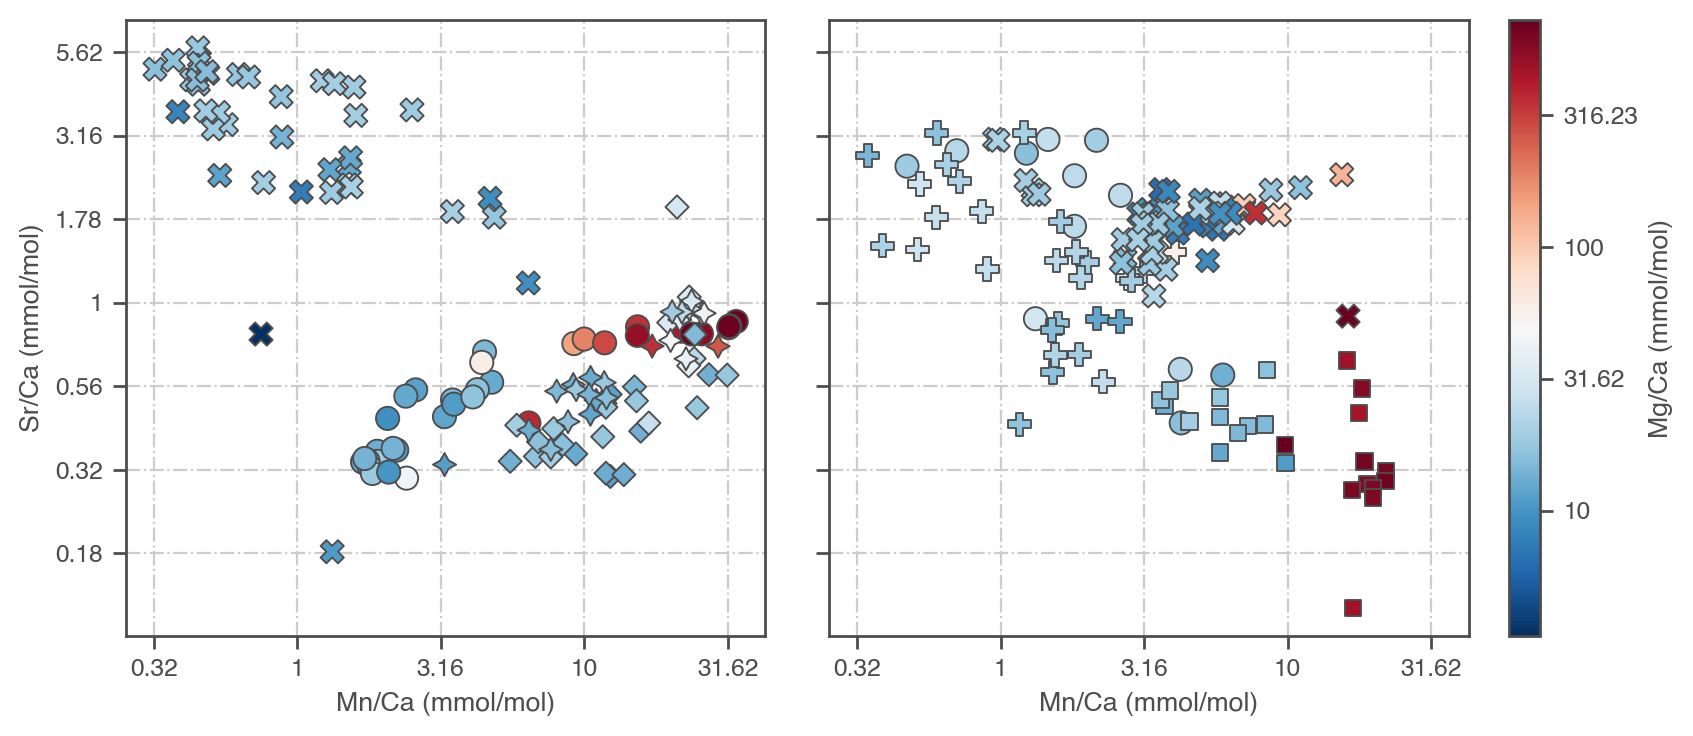

In [81]:
fig,ax = plt.subplots(1,2,figsize=(10.5,4),sharey=True,sharex=True)#,layout='constrained')
axs = ax.ravel()
for i in axs:
    i.grid()
targs = ['Sr_mmol_molCa','Mn_mmol_molCa']
xl = ['Sr/Ca (mmol/mol)','Mn/Ca (mmol/mol)']
z = np.log10(comb['Mg_mmol_molCa'])
pal = 'RdBu_r'
ho = ['GSM Type','McKale Creek','Boomerang','Jasper, Highway 16','Wolverine','Temple Lake']
markers = ['o',(4,0,0),'X',(4,1,0),'P','s']
s = 70
ticks = FuncFormatter(lambda x, pos: '{0:g}'.format(round(10**x,2)))
for a,t,l in zip([ax[0],ax[1]],[secs,clasts],xl):
    sns.scatterplot(x=np.log10(t['Mn_mmol_molCa']),y=np.log10(t['Sr_mmol_molCa']),ax=a,hue=np.log10(t['Mg_mmol_molCa']),style=t['index'],style_order=ho,palette=pal,
                    s=s,edgecolor='.3',legend=True,hue_norm=(z.min(), z.max()))
    a.set_xlabel(xl[1])
    a.set_ylabel(xl[0])
    a.xaxis.set_major_formatter(ticks)
    a.yaxis.set_major_formatter(ticks)
    # a.scatter(x=np.log10(hig1['Mn_mmol_molCa']),y=np.log10(hig1['Sr_mmol_molCa']),color='lightgrey',edgecolor='none',s=40,label='Bahamas',marker='o',zorder=0)
    # a.scatter(x=np.log10(clr['Mn/Ca (mmol/mol)']),y=np.log10(clr['Sr/Ca (mmol/mol)']),color='lightgrey',edgecolor='none',marker='v',s=60,label='Monterey',zorder=0)

    #if a!=axs[0]:
    a.legend().remove()
plt.subplots_adjust(wspace=0.1)
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap=pal, norm=norm)
sm.set_array([])
axs[-1].figure.colorbar(sm,ax=ax.ravel(),format=ticks,orientation='vertical',location='right',shrink=1,aspect=20,pad=0.025,label='Mg/Ca (mmol/mol)')


## Higher resolution Mn vs Sr figure

Text(0, 0.5, 'log$_{10}$ Sr/Ca (mmol/mol)')

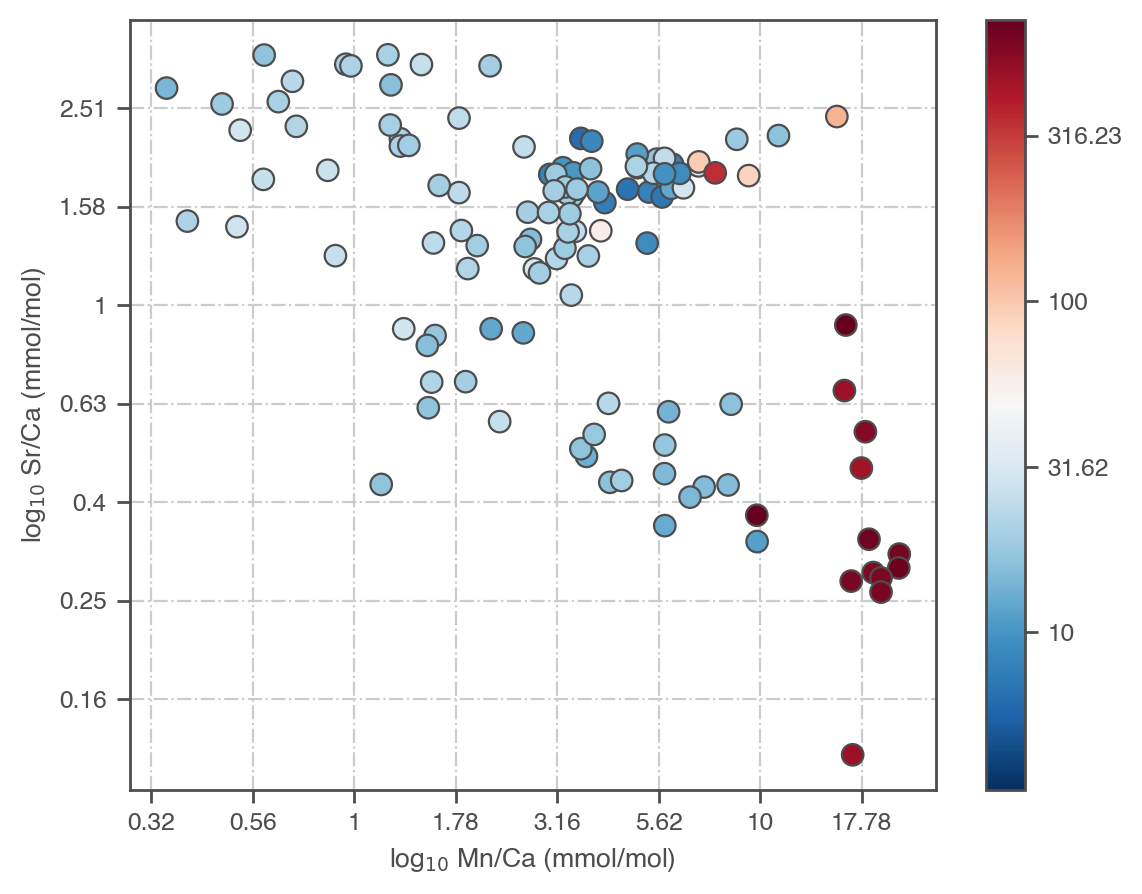

In [82]:
fig,ax = plt.subplots(1,1,figsize=(6.5,5))
ax.grid()
x = 'Mn_mmol_molCa'
y = 'Sr_mmol_molCa'
z = 'Mg_mmol_molCa'
s = scat(df=clasts,ax=ax,xt=x,yt=y,zt=z,vdfs=[tlm_secs,wmm_secs],logz=True,s=60,cmap='RdBu_r',edgecolor='.3',marker='o',label='OFP')
ticks = FuncFormatter(lambda x, pos: '{0:g}'.format(round(10**x,2)))
ax.xaxis.set_major_formatter(ticks)
ax.yaxis.set_major_formatter(ticks)
cax = plt.colorbar(s,format=ticks)
ax.set_xlabel('log$_{10}$ Mn/Ca (mmol/mol)')
ax.set_ylabel('log$_{10}$ Sr/Ca (mmol/mol)')

# Tables of Elemental Correlations
- see [this github post](https://github.com/pandas-dev/pandas/issues/45020)

In [83]:
sns.set_context('paper')
cmap = sns.color_palette('vlag')
cmap

[(0.4305964, 0.56276546, 0.74956387),
 (0.66563334, 0.72242871, 0.81414642),
 (0.89443865, 0.89721298, 0.9202854),
 (0.94742246, 0.87278899, 0.86691076),
 (0.85164413, 0.65142189, 0.64145983),
 (0.76133542, 0.43410655, 0.42592523)]

In [84]:
# # styling: use the absolute value so strong negative and positive correlations work together
# def abs_style(s,cmap):
#     cm=sns.color_palette(cmap, as_cmap=True)
#     max_val = max(s.max(), abs(s.min()))
#     norm = colors.Normalize(0,max_val)
#     normed = norm(abs(s.values))
#     c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cm)(normed)]
#     return ['background-color: %s' % color for color in c]


In [85]:
# styling: 
def df_style(s,cmap,vmin,vmax):
    cm=sns.color_palette(cmap, as_cmap=True)
    norm = colors.Normalize(vmin=vmin,vmax=vmax)
    normed = norm(s)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cm)(normed)]
    return ['background-color: %s' % color for color in c]


In [86]:
def cor_dict(loc,rtype='spearman',by='d13c_carb',rounded=4):
    corrs = []
    names = []
    for col in loc.columns[2:]:
        if rtype=='spearman':
            r = np.round(stats.spearmanr(loc[by],np.log10(loc[col]))[0],rounded)
        elif rtype=='pearson':
            r = np.round(stats.pearsonr(loc[by],np.log10(loc[col]))[0],rounded)
        corrs.append(r)
        names.append(col)
    cors_dict = dict(zip(names,corrs))
    return cors_dict

## Sections

In [87]:
set(secs['index'][~secs['Sr_mmol_molCa'].isna()])

{'GSM Type', 'McKale Creek', 'Temple Lake', 'Wolverine'}

In [88]:
secs.columns

Index(['index', 'member', 'thickness', 'lithology', 'facies', 'grade',
       'features', 'sample_name', 'sample_height', 'sample_facies',
       'sample_features', 'facies_simplified', 'sample_facies_simplified',
       'trace_facies_simplified', 'sample_lith', 'trace_facies', 'd13c_carb',
       'd18o_carb', 'Li_umol_molCa', 'Na_mmol_molCa', 'Mg_mmol_molCa',
       'Al_mmol_molCa', 'K_mmol_molCa', 'V_umol_molCa', 'Mn_mmol_molCa',
       'Fe_mmol_molCa', 'Rb_umol_molCa', 'Sr_mmol_molCa', 'Th_umol_molCa',
       'U_umol_molCa', 'Li_umol_molCa_Mg', 'Na_mmol_molCa_Mg',
       'Mg_mmol_molCa_Mg', 'Al_mmol_molCa_Mg', 'K_mmol_molCa_Mg',
       'V_umol_molCa_Mg', 'Mn_mmol_molCa_Mg', 'Fe_mmol_molCa_Mg',
       'Rb_umol_molCa_Mg', 'Sr_mmol_molCa_Mg', 'Th_umol_molCa_Mg',
       'U_umol_molCa_Mg', 'label', 'Mn/Sr (mmol/mmol)', 'd18o_smow'],
      dtype='object')

In [89]:
# removing elements with bad data (K, V, Th)
drop = ['index', 'member', 'thickness', 'lithology', 'facies', 'grade',
       'features', 'sample_name', 'sample_height', 'sample_facies',
       'sample_features', 'facies_simplified', 'sample_facies_simplified',
       'trace_facies_simplified', 'sample_lith', 'trace_facies','label','K_mmol_molCa','V_umol_molCa','Th_umol_molCa']
gsm_sec = secs[secs['index']=='GSM Type'].drop(drop,axis=1).dropna(subset=['Sr_mmol_molCa']).reset_index(drop=True)
mck_sec = secs[secs['index']=='McKale Creek'].drop(drop,axis=1).dropna(subset=['Sr_mmol_molCa']).reset_index(drop=True)
temple_sec = secs[secs['index']=='Temple Lake'].drop(drop,axis=1).dropna(subset=['Sr_mmol_molCa']).reset_index(drop=True)
wolv_sec = secs[secs['index']=='Wolverine'].drop(drop,axis=1).dropna(subset=['Sr_mmol_molCa']).reset_index(drop=True)

### get correlations with carbon

In [90]:
gsm_sec_cors = cor_dict(loc=gsm_sec,rtype='pearson')
mck_sec_cors = cor_dict(loc=mck_sec,rtype='pearson')
temple_sec_cors = cor_dict(loc=temple_sec,rtype='pearson')
wolv_sec_cors = cor_dict(loc=wolv_sec,rtype='pearson')

/Users/cvanwieren/anaconda3/envs/connor/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: array must not contain infs or NaNs

In [ ]:
sort_sec = ['GSM Type', 'McKale Creek', 'Temple Lake', 'Wolverine']

In [ ]:
df_sec = pd.DataFrame(columns = sort_sec,index = gsm_sec_cors.keys())

In [ ]:
df_sec['GSM Type']=gsm_sec_cors.values()
df_sec['McKale Creek']=mck_sec_cors.values()
df_sec['Temple Lake']=temple_sec_cors.values()
df_sec['Wolverine']=wolv_sec_cors.values()

In [ ]:
# grab Mn, Sr, Mg, Mn/Sr only
df_sec = df_sec.iloc[[2,4,7,8,-1],:]

In [ ]:
reidx = dict(zip(df_sec.index.values,['Mg/Ca','Mn/Ca','Sr/Ca','U/Ca','Mn/Sr']))

In [ ]:
df_sec = df_sec.rename(index=reidx)
df_sec.index.names = ['$r$ ($\delta^{13}$C -X)']
df_sec = df_sec.reset_index() # to make r its own column for cleaner latex table
df_sec

In [ ]:
vmin_sec = -1 #min(df_sec.min())
vmax_sec = 1 #max(df_sec.max())

# .apply(df_style,axis=0,cmap='coolwarm',vmin=vmin_sec,vmax=vmax_sec)\
secs_styled = df_sec.style\
  .background_gradient(axis=None,cmap='vlag',vmin=vmin_sec,vmax=vmax_sec)\
  .format(precision=3,)\
  .hide(axis='index')
  #.format_index(escape='latex', axis=0)\
  #.format_index(escape='latex', axis=1)

secs_styled

In [ ]:
print(secs_styled.to_latex(
    convert_css=True, hrules=True, position_float='centering',
    caption='caption',label='table:seccors',position='htb!'))

## Clasts

In [ ]:
set(clasts['index'][~clasts['Sr_mmol_molCa'].isna()])

In [ ]:
drop = ['index', 'member', 'sample_name', 'sample_height', 'sample_facies',
       'sample_features', 'sample_facies_simplified', 'sample_lith',
        'id', 'clast_len_cm', 'clast_width_cm','min_drildist_from_matrix_mm',
        'Beam Area', 'facies', 'label','type',
       'trace_facies', 'length_cm', 'width_cm', 'colour','K_mmol_molCa','V_umol_molCa','Th_umol_molCa']
gsm_ict = clasts[clasts['index']=='GSM Type'].drop(drop,axis=1).dropna(subset=['Sr_mmol_molCa']).reset_index(drop=True)
mck_ict = clasts[clasts['index']=='McKale Creek'].drop(drop,axis=1).dropna(subset=['Sr_mmol_molCa']).reset_index(drop=True)
hidden_ict = clasts[clasts['index']=='Jasper, Highway 16'].drop(drop,axis=1).dropna(subset=['Sr_mmol_molCa']).reset_index(drop=True)
boom_ict = clasts[clasts['index']=='Boomerang'].drop(drop,axis=1).dropna(subset=['Sr_mmol_molCa']).reset_index(drop=True)

### get correlations with carbon

In [ ]:
gsm_ict_cors = cor_dict(loc=gsm_ict,rtype='pearson')
mck_ict_cors = cor_dict(loc=mck_ict,rtype='pearson')
hidden_ict_cors = cor_dict(loc=hidden_ict,rtype='pearson')
boom_ict_cors = cor_dict(loc=boom_ict,rtype='pearson')

In [ ]:
sort_ict = ['Jasper, Highway 16','GSM Type', 'Boomerang', 'McKale Creek']

In [ ]:
df_ict = pd.DataFrame(columns = sort_ict,index = gsm_ict_cors.keys())

In [ ]:
df_ict['GSM Type']=gsm_ict_cors.values()
df_ict['McKale Creek']=mck_ict_cors.values()
df_ict['Jasper, Highway 16']=hidden_ict_cors.values()
df_ict['Boomerang']=boom_ict_cors.values()

In [ ]:
# grab Mn, Sr, Mg, Mn/Sr only
df_ict = df_ict.iloc[[2,4,7,8,-1],:]

In [ ]:
reidx = dict(zip(df_ict.index.values,['Mg/Ca','Mn/Ca','Sr/Ca','U/Ca','Mn/Sr']))

In [ ]:
df_ict = df_ict.rename(index=reidx)
df_ict.index.names = ['$r$ ($\delta^{13}$C -X)']
df_ict = df_ict.reset_index() # to make r its own column for cleaner latex table
df_ict

In [ ]:
vmin_ict = -1 # min(df_ict.min())
vmax_ict = 1 # max(df_ict.max())

#   .apply(df_style,axis=0,cmap='coolwarm',vmin=vmin_ict,vmax=vmax_ict)\
icts_styled = df_ict.style\
  .background_gradient(axis=None,cmap='vlag',vmin=vmin_ict,vmax=vmax_ict)\
  .format(precision=3,)\
  .hide(axis='index')
  #.format_index(escape='latex', axis=0)\
  #.format_index(escape='latex', axis=1)

icts_styled

In [ ]:
print(icts_styled.to_latex(
    convert_css=True, hrules=True, position_float='centering',
    caption='caption',label='table:clastcors',position='htb!'))